In [1]:
import os, sys, time, re, json, glob, shutil
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
from tqdm import tqdm
import scipy.stats as ss
from functools import reduce
import statsmodels.api as sm
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib import style
import warnings
style.use('seaborn-white')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
celltype_map_1k = {'CD4T': ['cd4et', 'cd4nc', 'cd4sox4'],
                   'CD8T': ['cd8et', 'cd8nc', 'cd8s100b'],
                   'monocyte': ['monoc', 'mononc'],
                   'B': ['bin', 'bmem', 'plasma'],
                   'NK': ['nk', 'nkr'],
                   'DC': ['dc']}
celltype_map_1k_inv = {}
for k, v in celltype_map_1k.items():
    for x in v:
        celltype_map_1k_inv[x] = k
sorted_cell_ids_map = {0: 'B', 1: 'CD4T', 2: 'CD8T', 3: 'NK', 4: 'monocyte', 5: 'DC', 6: 'gtex'}
sorted_cell_ids_map_inv = {v: k for k, v in sorted_cell_ids_map.items()}
sorted_cell_names = {'B': 'B', 'CD4T': 'CD4', 'CD8T': 'CD8', 'NK': 'NK', 'monocyte': 'Monocyte', 'DC': 'DC', 'neutrophil': 'Neutrophil'}
sorted_cell_types = ['B', 'CD4T', 'CD8T', 'NK', 'monocyte', 'DC', 'neutrophil']

In [4]:
df_bp = pd.read_csv('/data2/xiaojiashun/eQTL/data/BLUEPRINT/QTD000026.all.tsv.gz', sep='\t', compression='gzip')
print(df_bp.shape)
df_bp.head()

(104097891, 19)


,molecular_trait_id,chromosome,position,ref,alt,variant,ma_samples,maf,pvalue,beta,se,type,ac,an,r2,molecular_trait_object_id,gene_id,median_tpm,rsid
0,ENSG00000187608,1,14464,A,T,chr1_14464_A_T,42,0.109694,0.717210,0.049802,0.137288,SNP,43,392,NaN,ENSG00000187608,ENSG00000187608,81.301,rs546169444
1,ENSG00000187961,1,14464,A,T,chr1_14464_A_T,42,0.109694,0.154967,0.250693,0.175535,SNP,43,392,NaN,ENSG00000187961,ENSG00000187961,1.171,rs546169444
2,ENSG00000188290,1,14464,A,T,chr1_14464_A_T,42,0.109694,0.114498,0.258077,0.162728,SNP,43,392,NaN,ENSG00000188290,ENSG00000188290,0.666,rs546169444
3,ENSG00000188976,1,14464,A,T,chr1_14464_A_T,42,0.109694,0.864794,-0.020978,0.123027,SNP,43,392,NaN,ENSG00000188976,ENSG00000188976,2.535,rs546169444
4,ENSG00000224969,1,14464,A,T,chr1_14464_A_T,42,0.109694,0.069698,0.297776,0.163193,SNP,43,392,NaN,ENSG00000224969,ENSG00000224969,0.320,rs546169444


In [815]:
gene_id_map = pd.read_csv('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/gene_randmol_lookup.csv', sep='\t')
gene_id_map

,GENEID,GENENAME,MOLID
0,ENSG00000188976,NOC2L,ILMN_1792820
1,ENSG00000187608,ISG15,ILMN_2054019
2,ENSG00000186827,TNFRSF4,ILMN_1710204
3,ENSG00000078808,SDF4,ILMN_1696065
4,ENSG00000131584,ACAP3,ILMN_1743847
...,...,...,...
5116,ENSG00000160284,SPATC1L,ILMN_1716838
5117,ENSG00000160294,MCM3AP,ILMN_1784766
5118,ENSG00000182362,YBEY,ILMN_1656297
5119,ENSG00000160305,DIP2A,ILMN_1729272


# eGene number

## Fig 2c

In [487]:
## load
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_egenes_lowres_1e-5_hij0.0001.json', 'r') as f:
    stats_lowres = json.load(f)
nums_lowres = {'1M vs OneK1K':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only OneK1K genes': {}},
               '1M vs GTEx':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only GTEx genes': {}},
                 '1M vs 1M-Blue':
                 {'Shared genes': {}, 'Only 1M genes': {}, 'Only 1M-Blue genes': {}},
                 '1M-Blue vs OneK1K':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only OneK1K genes': {}},
                 '1M-Blue vs GTEx':
                 {'Shared genes': {}, 'Only 1M-Blue genes': {}, 'Only GTEx genes': {}}
                }
for k, v, in stats_lowres.items():
    for k2, v2 in v.items():
        for k3, v3 in v2.items():
            nums_lowres[k][k2][k3] = len(v3)

In [779]:
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_lowres_egenes_1e-5_hij0.0001.json', 'r') as f:
    pbmc_egenes = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_neutrophil_egenes_1e-5_hij0.0001.json', 'r') as f:
    neutro_egenes = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_lowres_egenes_bh0.01_hij0.0001.json', 'r') as f:
    pbmc_bh1 = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_neutrophil_egenes_bh0.01_hij0.0001.json', 'r') as f:
    neutro_bh1 = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_lowres_egenes_bh0.05_hij0.0001.json', 'r') as f:
    pbmc_bh2 = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_neutrophil_egenes_bh0.05_hij0.0001.json', 'r') as f:
    neutro_bh2 = json.load(f)

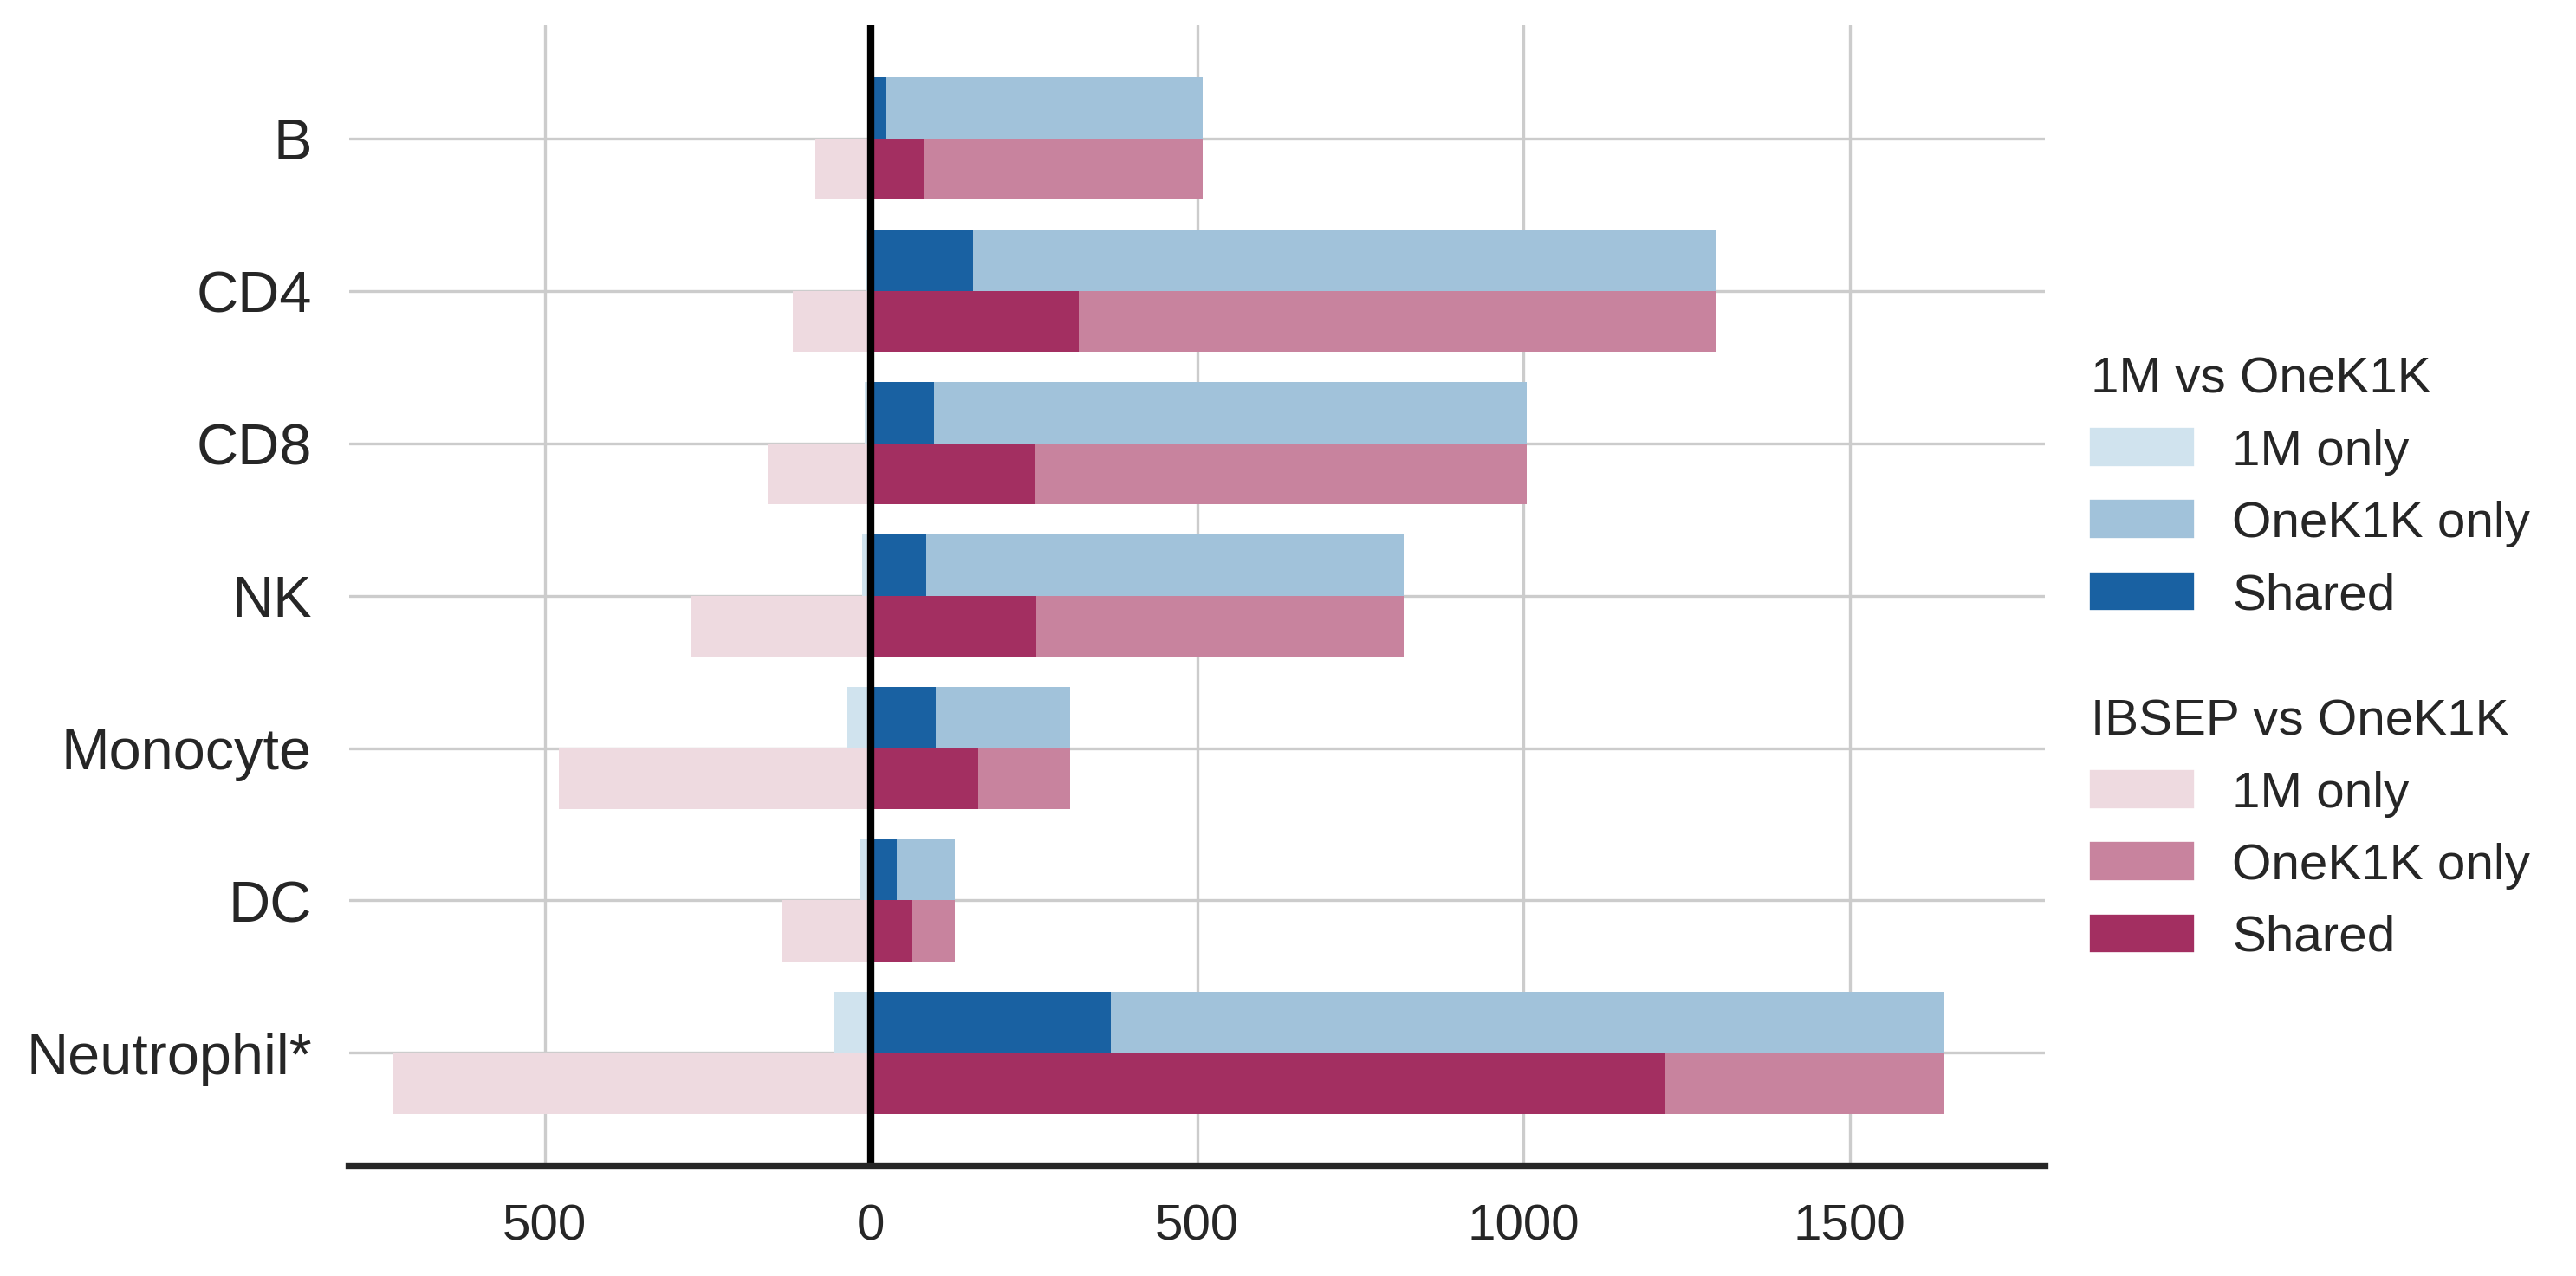

In [806]:
### 1m/ibsep vs onek1k
height = 0.4
tick_font = 14
label_font = 16
lgd_font = 14
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
left = np.zeros(6)
reds = ['#a32f61', '#c8839e', '#c8839e', '#eedae0']
blues = ['#1961a2', '#a1c2da', '#84b8d4', '#d0e3ee']
bars1, bars2 = [], []
labels = {'Only 1M genes': 'Only 1M-scBlood', 'Only 1M-Blue genes': 'Only 1M-scBlood-IBSEP'}
reorder = np.arange(6)[::-1]
alpha1, alpha2 = 1, 1
## novel on the left
tmp = nums_lowres['1M vs OneK1K']['Only 1M genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(1,7)+0.5*height, -v, height, label='1M only', left=left, 
            color=blues[3], alpha=alpha1)
bars1.append(p)
tmp = nums_lowres['1M-Blue vs OneK1K']['Only 1M-Blue genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(1,7)-0.5*height, -v, height, label='IBSEP only', left=left, 
            color=reds[3], alpha=alpha2)
bars2.append(p)

## shared with 1k1k on the right
left1, left2 = np.zeros(6), np.zeros(6)
tmp = nums_lowres['1M vs OneK1K']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(1,7)+0.5*height, v, height, label='Shared', left=left1, 
            color=blues[0], alpha=alpha1)
bars1.append(p)
left1 = v
tmp = nums_lowres['1M-Blue vs OneK1K']['Shared genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(1,7)-0.5*height, v, height, label='Shared', left=left2, 
            color=reds[0], alpha=alpha2)
left2 = v
bars2.append(p)

## 1k1k novel on the right
tmp = nums_lowres['1M vs OneK1K']['Only OneK1K genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(1,7)+0.5*height, v, height, label='OneK1K only', left=left1, 
            color=blues[1], alpha=alpha1)
bars1.append(p)
tmp = nums_lowres['1M-Blue vs OneK1K']['Only OneK1K genes']
v = np.array(list(tmp.values()))[reorder]
p = ax.barh(np.arange(1,7)-0.5*height, v, height, label='OneK1K only', left=left2, 
            color=reds[1], alpha=alpha2)
bars2.append(p)

## add neutrophil
neutro_loc = 0
left = 0
v = len(np.setdiff1d(neutro_egenes['Neutro2015'], neutro_egenes['BLUEPRINT']))
p = ax.barh(neutro_loc+0.5*height, -v, height, label='Neutro2015 only', left=left, color=blues[3], alpha=alpha1)
# bars1.append(p)
v = len(np.setdiff1d(neutro_egenes['IBSEP'], neutro_egenes['BLUEPRINT']))
p = ax.barh(neutro_loc-0.5*height, -v, height, label='BLUEPRINT only', left=left, color=reds[3], alpha=alpha2)
# bars2.append(p)

left1, left2 = 0, 0
v = len(np.intersect1d(neutro_egenes['Neutro2015'], neutro_egenes['BLUEPRINT']))
p = ax.barh(neutro_loc+0.5*height, v, height, label='Neutro2015 only', left=left1, color=blues[0], alpha=alpha1)
# bars1.append(p)
left1 = v
v = len(np.intersect1d(neutro_egenes['IBSEP'], neutro_egenes['BLUEPRINT']))
p = ax.barh(neutro_loc-0.5*height, v, height, label='BLUEPRINT only', left=left2, color=reds[0], alpha=alpha2)
# bars2.append(p)
left2 = v

v = len(np.setdiff1d(neutro_egenes['BLUEPRINT'], neutro_egenes['Neutro2015']))
p = ax.barh(neutro_loc+0.5*height, v, height, label='Neutro2015 only', left=left1, color=blues[1], alpha=alpha1)
# bars1.append(p)
v = len(np.setdiff1d(neutro_egenes['BLUEPRINT'], neutro_egenes['IBSEP']))
p = ax.barh(neutro_loc-0.5*height, v, height, label='BLUEPRINT only', left=left2, color=reds[1], alpha=alpha2)
# bars2.append(p)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(-800, 1800)
# ax.set_ylim(-1, 6)
ax.set_xticks([-500, 0, 500, 1000, 1500])
ax.set_xticklabels(['500', '0', '500', '1000', '1500'])
ax.set_yticks(np.arange(7))
ylabels = list(sorted_cell_names.values())[::-1]
ylabels[0] = 'Neutrophil*'
ax.set_yticklabels(ylabels, fontsize=label_font)
ax.tick_params(axis='x', which='both', labelsize=tick_font)
ax.tick_params(axis='y', which='both', labelsize=label_font)
ax.axvline(x=0, color='black', lw=2)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
## legend on the right
legend1_patches = [mpatches.Patch(color=blues[3], label='1M only', alpha=alpha1),
                   mpatches.Patch(color=blues[1], label='OneK1K only', alpha=alpha1),
                   mpatches.Patch(color=blues[0], label='Shared', alpha=alpha1)]
legend1 = ax.legend(handles=legend1_patches, loc='upper left', bbox_to_anchor=(1, 0.75), title='1M vs OneK1K', alignment='left', fontsize=lgd_font, title_fontsize=lgd_font)
ax.add_artist(legend1)
legend2_patches = [mpatches.Patch(color=reds[3], label='1M only', alpha=alpha2),
                   mpatches.Patch(color=reds[1], label='OneK1K only', alpha=alpha2),
                   mpatches.Patch(color=reds[0], label='Shared', alpha=alpha2)]
legend2 = ax.legend(handles=legend2_patches, loc='upper left', bbox_to_anchor=(1, 0.45), title='IBSEP vs OneK1K', alignment='left', fontsize=lgd_font, title_fontsize=lgd_font)

ax.grid(True)
plt.tight_layout()
plt.show()

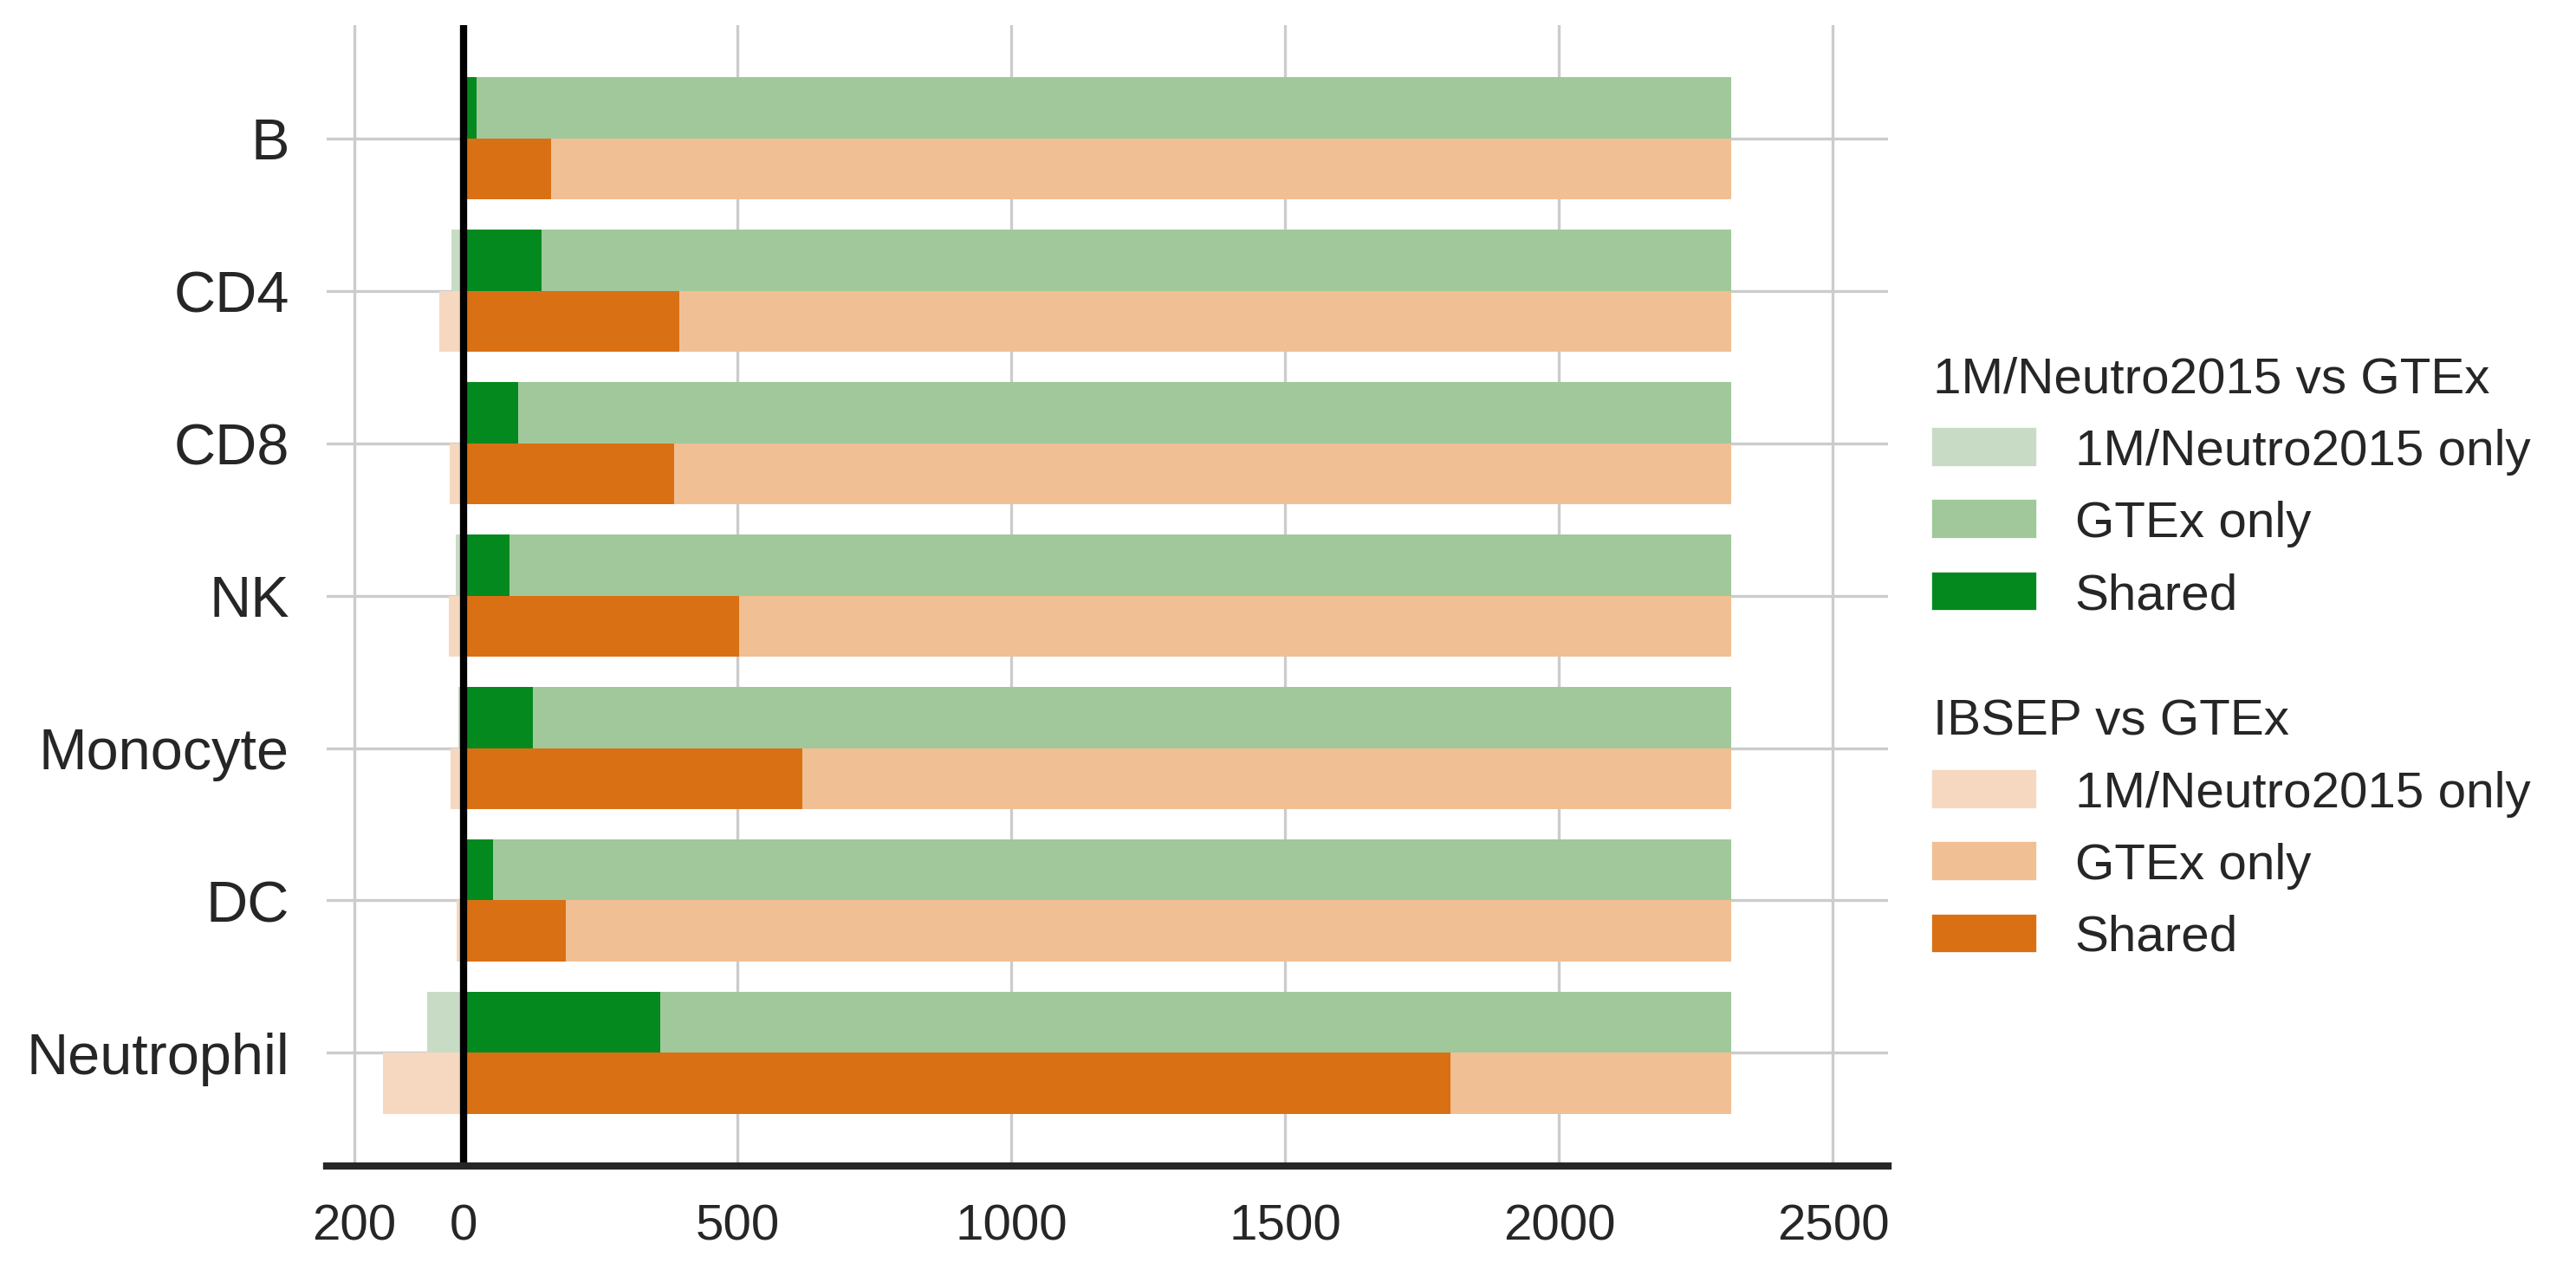

In [810]:
### 1m/ibsep vs gtex
height = 0.4
tick_font = 14
label_font = 16
lgd_font = 14
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=300)
left = np.zeros(6)
reds = ['#da7014', '#f1bf94', '#f1bf94', '#f5d8bf']
blues = ['#04891e', '#a0c89b', '#9dc59e', '#c8dcc5']
bars1, bars2 = [], []
# labels = {'Only 1M genes': 'Only 1M-scBlood', 'Only 1M-Blue genes': 'Only 1M-scBlood-IBSEP'}
reorder = np.arange(6)[::-1]
alpha1, alpha2 = 1, 1
## novel on the left
v = []
for k in pbmc_egenes.keys():
    v.append(len(np.setdiff1d(pbmc_egenes[k]['1M-Blood'], pbmc_egenes[k]['GTEx'])))
v = np.array(v)[reorder]
p = ax.barh(np.arange(1,7)+0.5*height, -v, height, label='1M only', left=left, 
            color=blues[3], alpha=alpha1)
bars1.append(p)
v = []
for k in pbmc_egenes.keys():
    v.append(len(np.setdiff1d(pbmc_egenes[k]['1M-Blood-IBSEP'], pbmc_egenes[k]['GTEx'])))
v = np.array(v)[reorder]
p = ax.barh(np.arange(1,7)-0.5*height, -v, height, label='IBSEP only', left=left, 
            color=reds[3], alpha=alpha2)
bars2.append(p)

## shared with 1k1k on the right
left1, left2 = np.zeros(6), np.zeros(6)
v = []
for k in pbmc_egenes.keys():
    v.append(len(np.intersect1d(pbmc_egenes[k]['1M-Blood'], pbmc_egenes[k]['GTEx'])))
v = np.array(v)[reorder]
p = ax.barh(np.arange(1,7)+0.5*height, v, height, label='Shared', left=left1, 
            color=blues[0], alpha=alpha1)
bars1.append(p)
left1 = v
v = []
for k in pbmc_egenes.keys():
    v.append(len(np.intersect1d(pbmc_egenes[k]['1M-Blood-IBSEP'], pbmc_egenes[k]['GTEx'])))
v = np.array(v)[reorder]
p = ax.barh(np.arange(1,7)-0.5*height, v, height, label='Shared', left=left2, 
            color=reds[0], alpha=alpha2)
left2 = v
bars2.append(p)

## 1k1k novel on the right
v = []
for k in pbmc_egenes.keys():
    v.append(len(np.setdiff1d(pbmc_egenes[k]['GTEx'], pbmc_egenes[k]['1M-Blood'])))
v = np.array(v)[reorder]
p = ax.barh(np.arange(1,7)+0.5*height, v, height, label='GTEx only', left=left1, 
            color=blues[1], alpha=alpha1)
bars1.append(p)
v = []
for k in pbmc_egenes.keys():
    v.append(len(np.setdiff1d(pbmc_egenes[k]['GTEx'], pbmc_egenes[k]['1M-Blood-IBSEP'])))
v = np.array(v)[reorder]
p = ax.barh(np.arange(1,7)-0.5*height, v, height, label='GTEx only', left=left2, 
            color=reds[1], alpha=alpha2)
bars2.append(p)

## add neutrophil
neutro_loc = 0
left = 0
v = len(np.setdiff1d(neutro_egenes['Neutro2015'], pbmc_egenes['B']['GTEx']))
p = ax.barh(neutro_loc+0.5*height, -v, height, label='Neutro2015 only', left=left, color=blues[3], alpha=alpha1)
# bars1.append(p)
v = len(np.setdiff1d(neutro_egenes['IBSEP'], pbmc_egenes['B']['GTEx']))
p = ax.barh(neutro_loc-0.5*height, -v, height, label='GTEx only', left=left, color=reds[3], alpha=alpha2)
# bars2.append(p)

left1, left2 = 0, 0
v = len(np.intersect1d(neutro_egenes['Neutro2015'], pbmc_egenes['B']['GTEx']))
p = ax.barh(neutro_loc+0.5*height, v, height, label='Neutro2015 only', left=left1, color=blues[0], alpha=alpha1)
# bars1.append(p)
left1 = v
v = len(np.intersect1d(neutro_egenes['IBSEP'], pbmc_egenes['B']['GTEx']))
p = ax.barh(neutro_loc-0.5*height, v, height, label='GTEx only', left=left2, color=reds[0], alpha=alpha2)
# bars2.append(p)
left2 = v

v = len(np.setdiff1d(pbmc_egenes['B']['GTEx'], neutro_egenes['Neutro2015']))
p = ax.barh(neutro_loc+0.5*height, v, height, label='Neutro2015 only', left=left1, color=blues[1], alpha=alpha1)
# bars1.append(p)
v = len(np.setdiff1d(pbmc_egenes['B']['GTEx'], neutro_egenes['IBSEP']))
p = ax.barh(neutro_loc-0.5*height, v, height, label='GTEx only', left=left2, color=reds[1], alpha=alpha2)
# bars2.append(p)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(-250, 2600)
# ax.set_ylim(-1, 6)
ax.set_xticks([-200, 0, 500, 1000, 1500, 2000, 2500])
ax.set_xticklabels(['200', '0', '500', '1000', '1500', '2000', '2500'])
ax.set_yticks(np.arange(7))
ylabels = list(sorted_cell_names.values())[::-1]
ylabels[0] = 'Neutrophil'
ax.set_yticklabels(ylabels, fontsize=label_font)
ax.tick_params(axis='x', which='both', labelsize=tick_font)
ax.tick_params(axis='y', which='both', labelsize=label_font)
ax.axvline(x=0, color='black', lw=2)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
## legend on the right
legend1_patches = [mpatches.Patch(color=blues[3], label='1M/Neutro2015 only', alpha=alpha1),
                   mpatches.Patch(color=blues[1], label='GTEx only', alpha=alpha1),
                   mpatches.Patch(color=blues[0], label='Shared', alpha=alpha1)]
legend1 = ax.legend(handles=legend1_patches, loc='upper left', bbox_to_anchor=(1, 0.75), title='1M/Neutro2015 vs GTEx', alignment='left', fontsize=lgd_font, title_fontsize=lgd_font)
ax.add_artist(legend1)
legend2_patches = [mpatches.Patch(color=reds[3], label='1M/Neutro2015 only', alpha=alpha2),
                   mpatches.Patch(color=reds[1], label='GTEx only', alpha=alpha2),
                   mpatches.Patch(color=reds[0], label='Shared', alpha=alpha2)]
legend2 = ax.legend(handles=legend2_patches, loc='upper left', bbox_to_anchor=(1, 0.45), title='IBSEP vs GTEx', alignment='left', fontsize=lgd_font, title_fontsize=lgd_font)

ax.grid(True)
plt.tight_layout()
plt.show()

## pvalue vs FDR

In [556]:
def Venn3Sets(dfA,dfB,dfC):
    A = set(dfA)
    B = set(dfB)
    C = set(dfC)
    AB_overlap = A & B  #compute intersection of set A & set B
    AC_overlap = A & C
    BC_overlap = B & C
    ABC_overlap = A & B & C
    A_rest = A - AB_overlap - AC_overlap #see left graphic
    B_rest = B - AB_overlap - BC_overlap
    C_rest = C - AC_overlap - BC_overlap
    AB_only = AB_overlap - ABC_overlap   #see right graphic
    AC_only = AC_overlap - ABC_overlap
    BC_only = BC_overlap - ABC_overlap

    sets = Counter()         
    sets['100'] = len(A_rest)
    sets['010'] = len(B_rest)
    sets['001'] = len(C_rest)
    sets['110'] = len(AB_only)
    sets['101'] = len(AC_only)
    sets['011'] = len(BC_only)
    sets['111'] = len(ABC_overlap)

    return sets

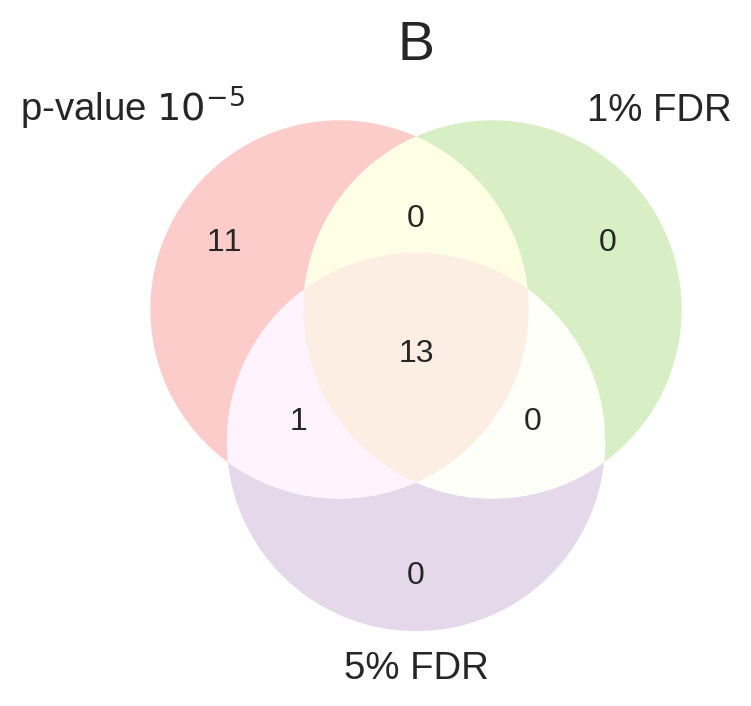

In [617]:
ct = 'B'
sns.set_context('paper',font_scale=1.2)
plt.figure(figsize=(4,4),dpi=200) 
cmap = plt.colormaps['Paired']
if ct != 'neutrophil':
    sets = Venn3Sets(pbmc_egenes[ct]['1M-Blood'], pbmc_bh1[ct]['1M-Blood'], pbmc_bh2[ct]['1M-Blood'])
else:
    sets = Venn3Sets(neutro_egenes['Neutro2015'], neutro_bh1['Neutro2015'], neutro_bh2['Neutro2015'])
venn3_unweighted(subsets=sets, set_labels=[r'p-value $10^{-5}$', '1% FDR', '5% FDR'], set_colors=(cmap.colors[4],cmap.colors[2],cmap.colors[8]), alpha=0.5)
plt.title(sorted_cell_names[ct], fontsize=20)
plt.show()

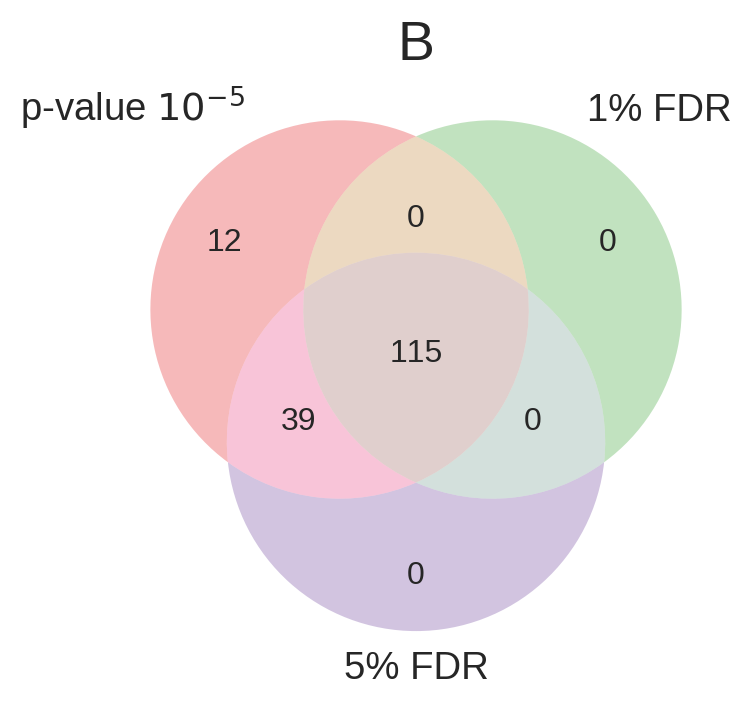

In [618]:
sns.set_context('paper',font_scale=1.2)
plt.figure(figsize=(4,4),dpi=200) 
if ct != 'neutrophil':
    sets = Venn3Sets(pbmc_egenes[ct]['1M-Blood-IBSEP'], pbmc_bh1[ct]['1M-Blood-IBSEP'], pbmc_bh2[ct]['1M-Blood-IBSEP'])
else:
    sets = Venn3Sets(neutro_egenes['IBSEP'], neutro_bh1['IBSEP'], neutro_bh2['IBSEP'])
venn3_unweighted(subsets=sets, set_labels=[r'p-value $10^{-5}$', '1% FDR', '5% FDR'], set_colors=(cmap.colors[5],cmap.colors[3],cmap.colors[9]), alpha=0.3)
plt.title(sorted_cell_names[ct], fontsize=20)
plt.show()

# Effective sample size

## Fig 2d

In [57]:
with open('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_effective_sample_sizes_truncorr_hij0.0001.json', 'r') as f:
    sample_sizes = json.load(f)

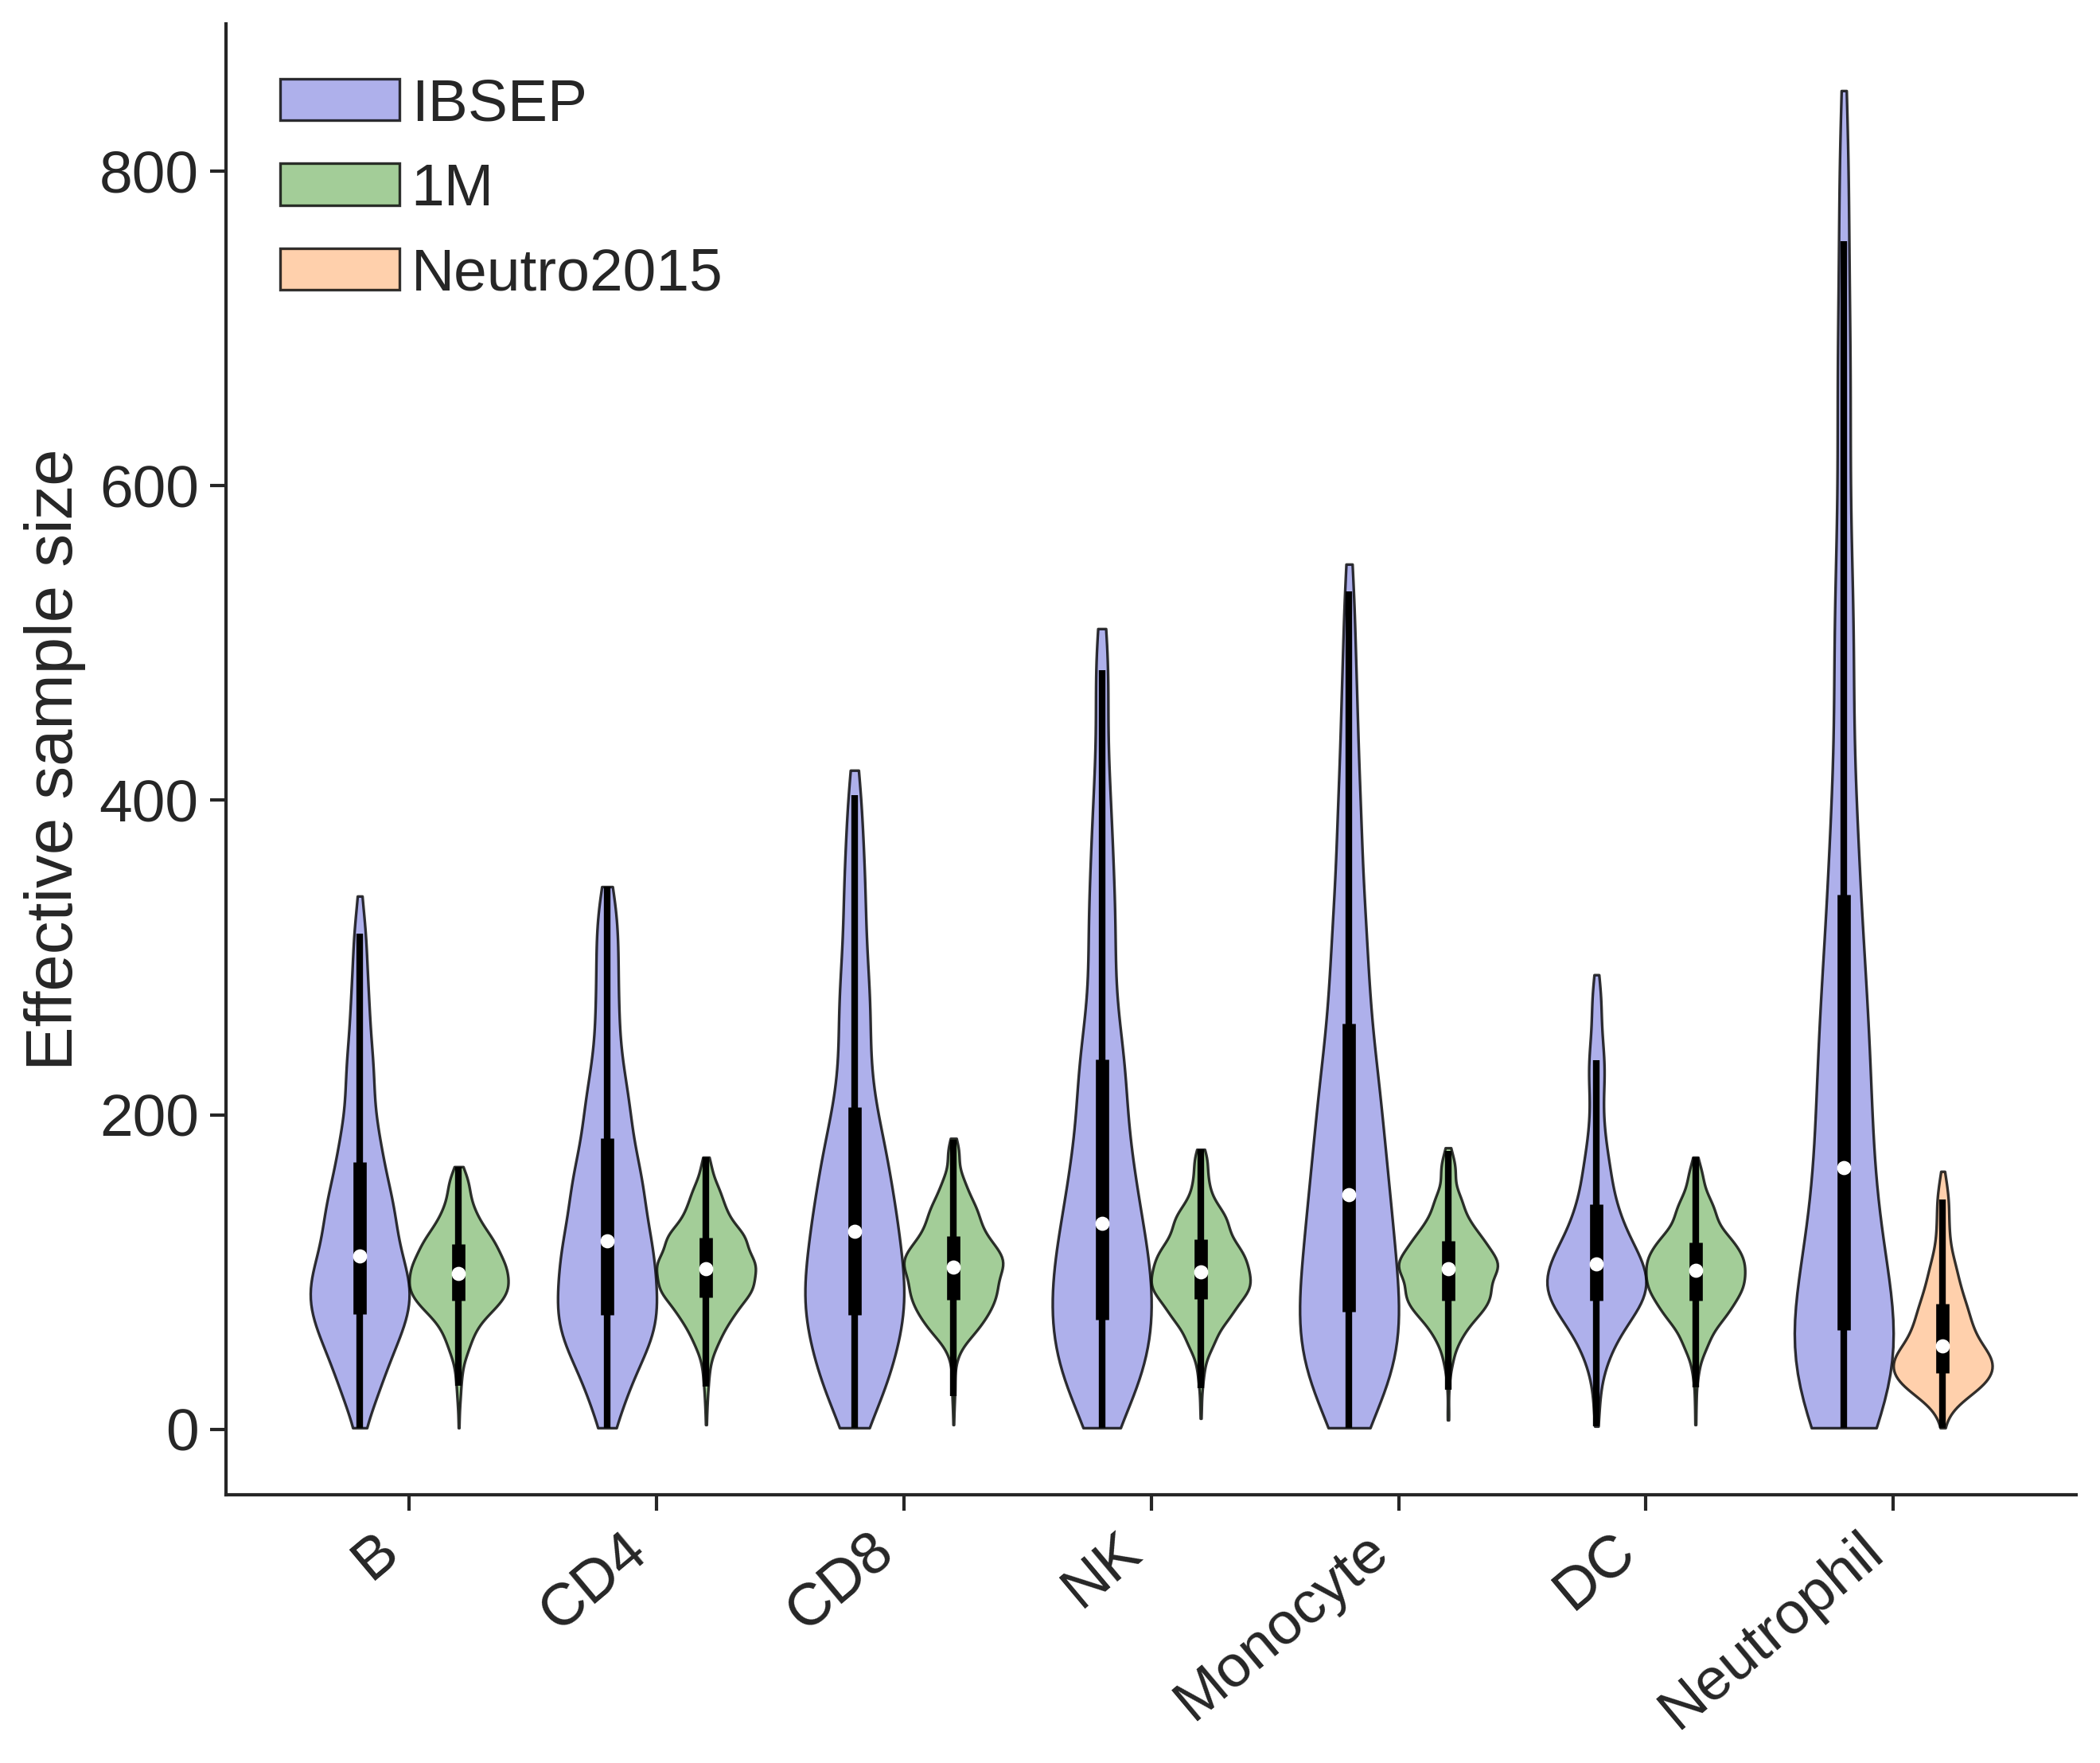

In [191]:
## violin plot: with neutrophil, hij=0.0001
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value
    
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(10, 8), dpi=300)
width = 0.4
a = 0.8
for i, k in enumerate(sorted_cell_types):
    v = sample_sizes['Neff_new'][k]
    v_plot = np.sort(np.array(v)[(np.array(v) > 0) & (v < np.percentile(v, 85))])
    vio1 = ax.violinplot(v_plot, positions=[i-0.5*width], widths=width, showextrema=False, showmedians=False,showmeans=False)
    for pc in vio1['bodies']:
        pc.set_facecolor('#9A9DE6') # '#9296F0'
        pc.set_edgecolor('black')
        pc.set_alpha(a)
    quartile1, medians, quartile3 = np.percentile(v_plot, [25, 50, 75])
    whiskers = adjacent_values(v_plot, quartile1, quartile3)
    whiskers_min, whiskers_max = whiskers[0], whiskers[1]
    
    ax.scatter([i-0.5*width], [medians], marker='o', color='white', s=12, zorder=4)
    ax.vlines([i-0.5*width], quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines([i-0.5*width], whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

for i, k in enumerate(sorted_cell_types):
    v = sample_sizes['Neff'][k]
    v_plot = np.sort(np.array(v)[(np.array(v) > 0) & (v < np.percentile(v, 95))])
    if i < 6:
        vio2 = ax.violinplot(v_plot, positions=[i+0.5*width], widths=width, showextrema=False, showmedians=False, showmeans=False)
        for pc in vio2['bodies']:
            pc.set_facecolor('#8CC17E') #'#7EC06F'
            pc.set_edgecolor('black')
            pc.set_alpha(a)
    else:
        vio3 = ax.violinplot(v_plot, positions=[i+0.5*width], widths=width, showextrema=False, showmedians=False, showmeans=False)
        for pc in vio3['bodies']:
            pc.set_facecolor('#FFC597')
            pc.set_edgecolor('black')
            pc.set_alpha(a)
    quartile1, medians, quartile3 = np.percentile(v_plot, [25, 50, 75])
    whiskers = adjacent_values(v_plot, quartile1, quartile3)
    whiskers_min, whiskers_max = whiskers[0], whiskers[1]
    
    ax.scatter([i+0.5*width], [medians], marker='o', color='white', s=12, zorder=4)
    ax.vlines([i+0.5*width], quartile1, quartile3, color='k', linestyle='-', lw=4)
    ax.vlines([i+0.5*width], whiskers_min, whiskers_max, color='k', linestyle='-', lw=2)

ax.legend(handles=[vio1["bodies"][0], vio2["bodies"][0], vio3["bodies"][0]], 
                 labels=["IBSEP", "1M", 'Neutro2015'],
                loc='upper left', fontsize=18,handletextpad=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Effective sample size', fontsize=20)
# ax.set_yticks([100, 200, 300, 400, 500])
ax.set_xticks(range(len(sorted_cell_types)))
ax.set_xticklabels(list(sorted_cell_names.values()), rotation=40, ha='right')
ax.tick_params(axis='both', which='major', labelsize=18)
# plt.grid(None)
plt.show()

## Fig 2e

In [72]:
prop_df = pd.read_csv('/data2/xiaojiashun/eQTL/data/cibersortx/mean_props_7.csv', sep='\t')
prop_df

,cell_type,prop
0,B,0.053477
1,CD4T,0.067026
2,CD8T,0.088101
3,DC,0.001488
4,monocyte,0.149771
5,NK,0.128194
6,neutrophil,0.479802


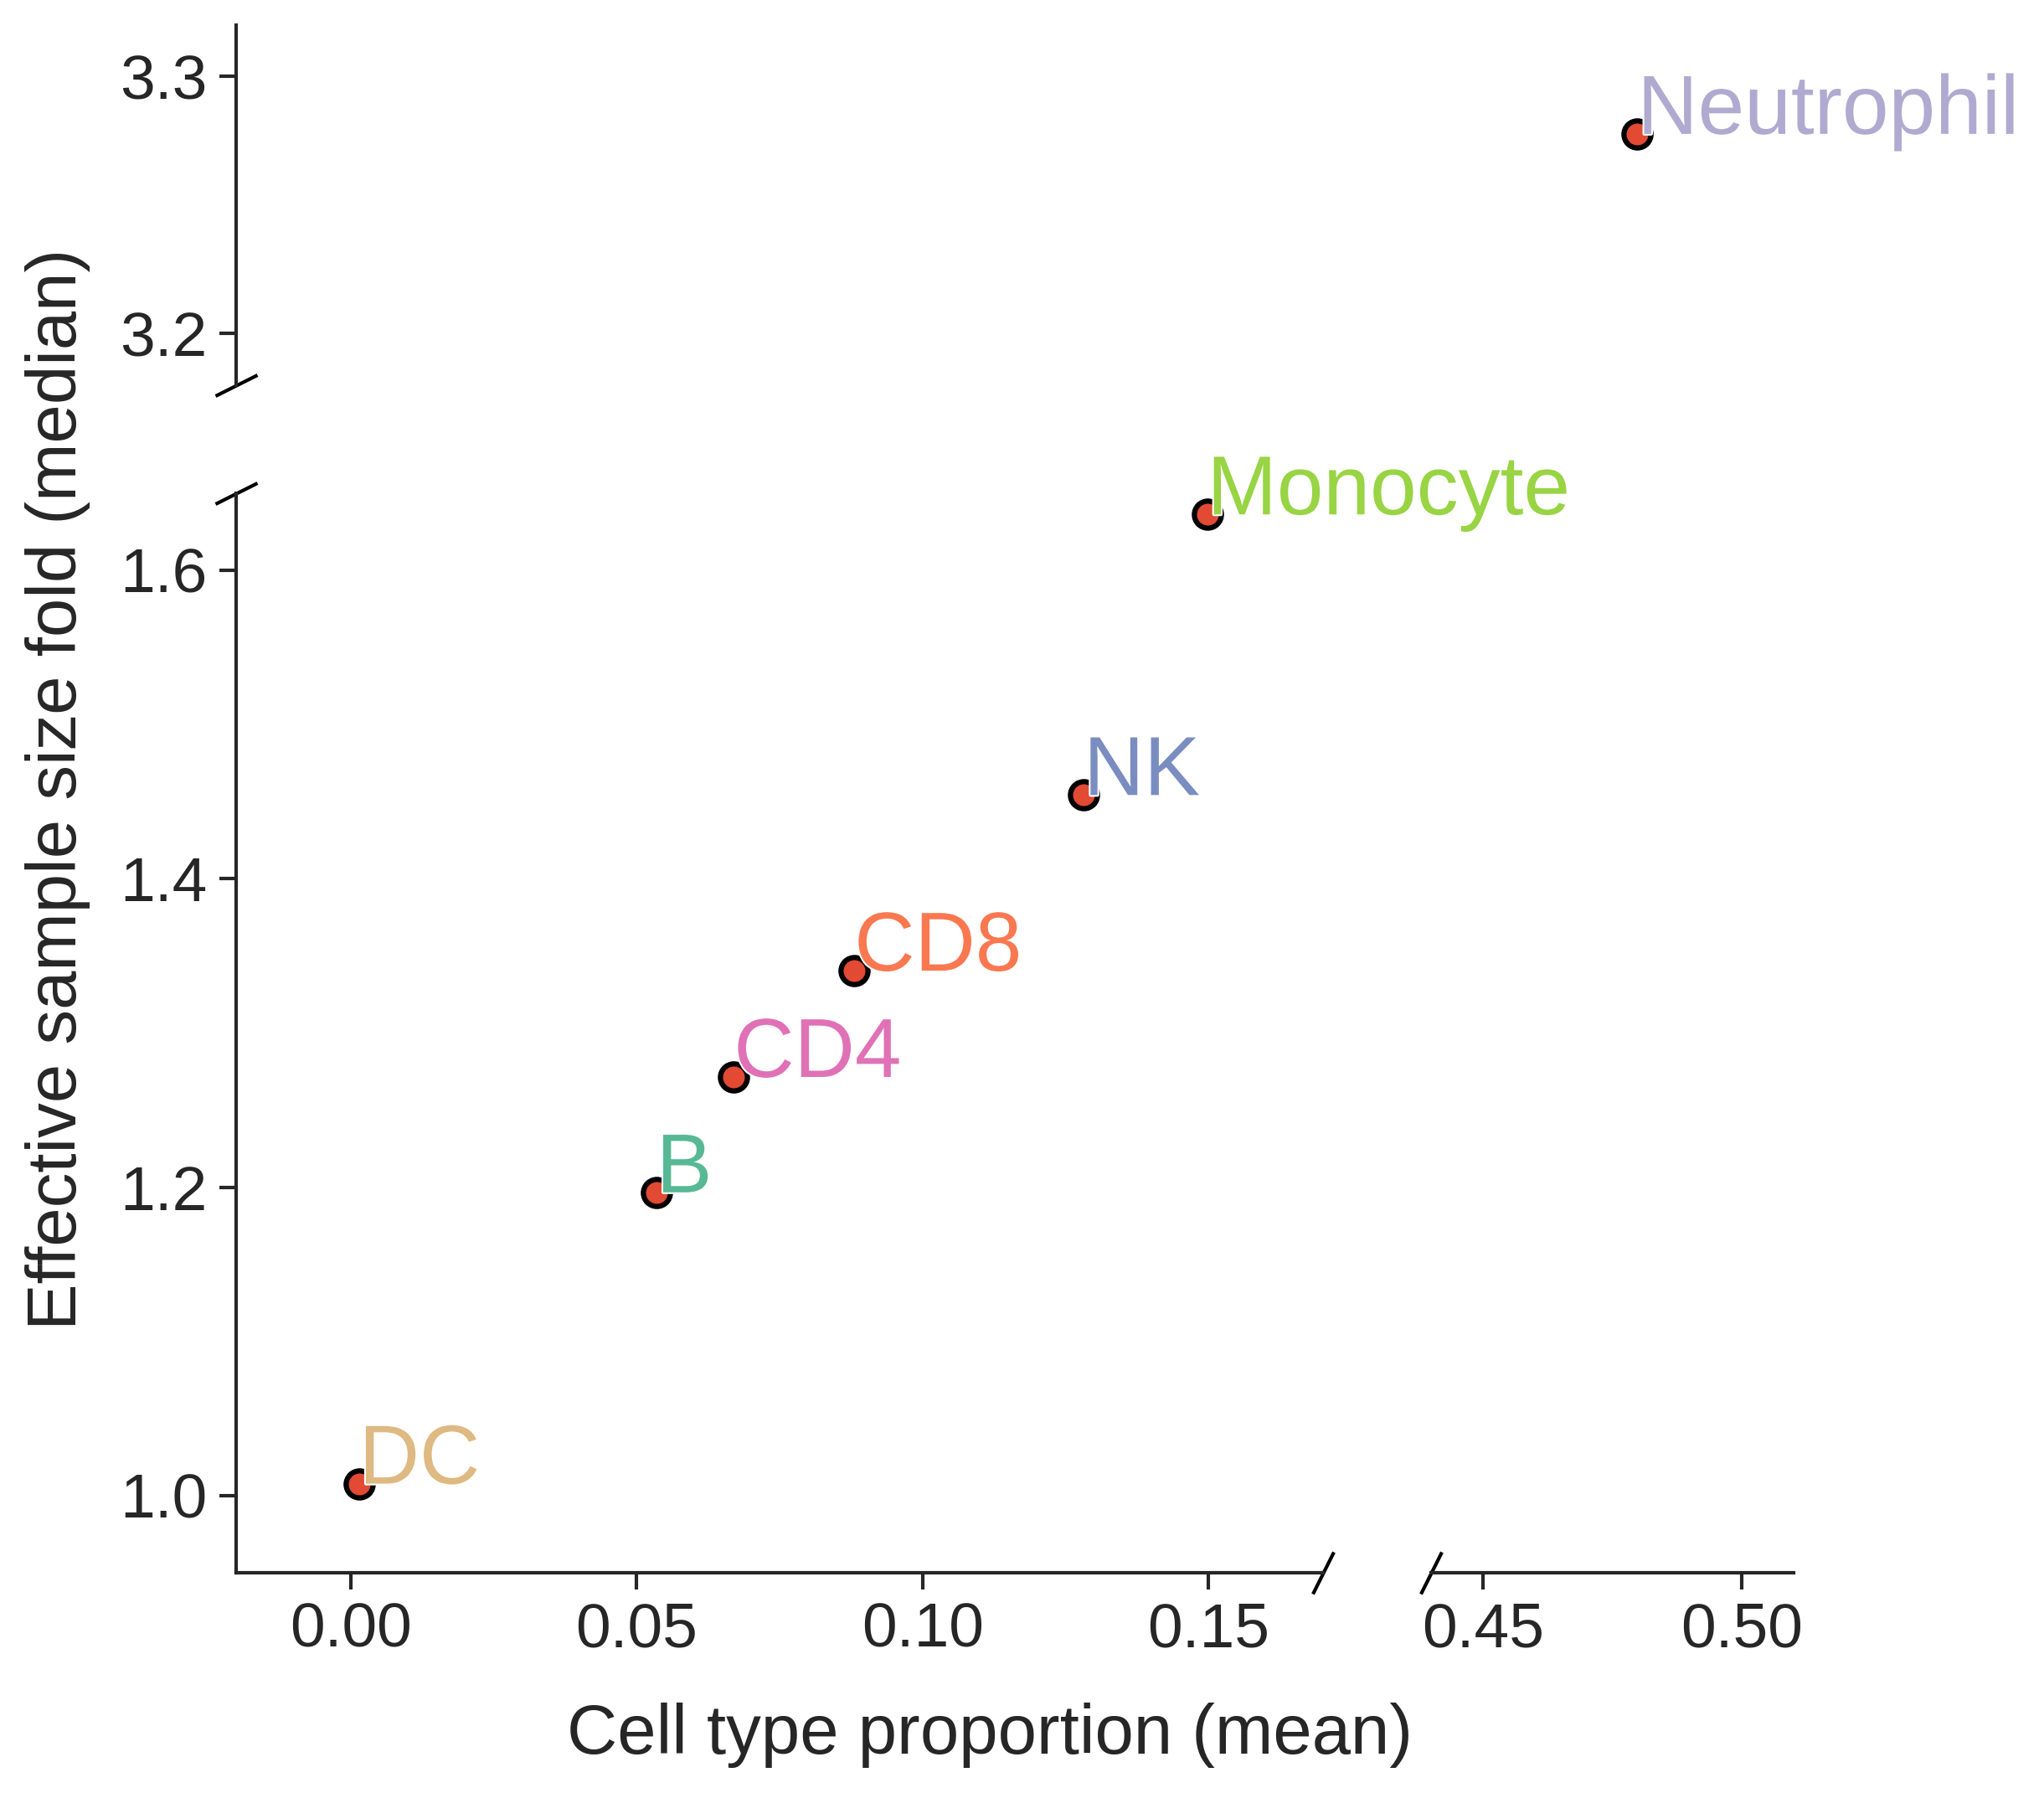

In [147]:
X2, Y2 = [], []
for c in sorted_cell_types:
    prop = prop_df.loc[prop_df.cell_type == c.replace('_', ' ')]['prop'].values[0]
    a = np.array(sample_sizes['Neff_f'][c])
    idx = np.where((a < np.percentile(a, 95)) & (a > 0))[0]
    X2.append(np.median(a[idx]))
    Y2.append(prop)
    
sns.set_context('paper',font_scale=1.)
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=300, gridspec_kw={'width_ratios': [3, 1], 'height_ratios': [1,3]})
lw = 1.5
fs = 24
s = 240
ax[1,0].scatter(Y2, X2, marker='.', s=s, edgecolor='black', linewidth=lw)
ax[0,1].scatter(Y2, X2, marker='.', s=s, edgecolor='black', linewidth=lw)
texts = []
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982', '#B0AAD1']
for i, (y2, x2) in enumerate(zip(Y2, X2)):
    if i < 6:
        texts.append(ax[1,0].text(x=y2, y=x2, s=list(sorted_cell_names.values())[i], 
                              bbox={'facecolor':'none', 'edgecolor':'none', 'pad':10},
                              path_effects=[pe.withStroke(linewidth=1, foreground='w')],
                              fontsize=fs, color=colors[i]))
    else:
        texts.append(ax[0,1].text(x=y2, y=x2, s=list(sorted_cell_names.values())[i], 
                              bbox={'facecolor':'none', 'edgecolor':'none', 'pad':10},
                              path_effects=[pe.withStroke(linewidth=1, foreground='w')],
                              fontsize=fs, color=colors[i]))
ax[1,0].set_zorder(1)

xlim1 = [-0.02, 0.17]
xlim2 = [0.44, 0.51]
ylim1 = [0.95, 1.65]
ylim2 = [3.18, 3.32]
xtick1 = [.0, 0.05, 0.1, 0.15]
xtick2 = [0.45,0.50]
ytick1 = [1.0,1.2,1.4,1.6]
ytick2 = [3.2,3.3]
ax[0,1].set_xlim(xlim2)
ax[0,1].set_ylim(ylim2)
ax[0,0].set_xlim(xlim1)
ax[0,0].set_ylim(ylim2)
ax[1,0].set_xlim(xlim1)
ax[1,0].set_ylim(ylim1)
ax[1,1].set_xlim(xlim2)
ax[1,1].set_ylim(ylim1)
ax[1,0].set_xticks(xtick1)
ax[1,0].set_yticks(ytick1)
ax[0,0].set_yticks(ytick2)
ax[1,1].set_xticks(xtick2)

ax[0,0].spines[['top','bottom','right']].set_visible(False)
ax[0,0].tick_params(bottom=False, labelbottom=False)
ax[0,1].spines[['top','bottom','left','right']].set_visible(False)
ax[0,1].tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
ax[1,0].spines[['top','right']].set_visible(False)
ax[1,1].spines[['top','left','right']].set_visible(False)
ax[1,1].tick_params(left=False, labelleft=False)

d1 = 0.5  # proportion of vertical to horizontal extent of the slanted line
d2 = 2
kwargs1 = dict(marker=[(-1, -d1), (1, d1)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
kwargs2 = dict(marker=[(-1, -d2), (1, d2)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

ax[0,0].plot([0], [0], transform=ax[0,0].transAxes, **kwargs1)
ax[1,0].plot([0], [1], transform=ax[1,0].transAxes, **kwargs1)
ax[1,0].plot([1], [0], transform=ax[1,0].transAxes, **kwargs2)
ax[1,1].plot([0], [0], transform=ax[1,1].transAxes, **kwargs2)

for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis='both', which='major', labelsize=18)
fig.text(0.5, 0.02, 'Cell type proportion (mean)', ha='center', fontsize=20)
fig.text(0.02, 0.5, 'Effective sample size fold (median)', va='center', rotation='vertical', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.15)

# Zscore scatter plot

## PBMC

In [250]:
cell_type = 'DC'
cell_ids = sorted_cell_ids_map_inv[cell_type]
sub_celltypes = celltype_map_1k[cell_type]
t0 = time.time()
df_blue = pd.read_csv(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/allChrMols_{cell_type}_blue_pval0.0001_tau1.0_truncorr.csv', sep='\t')
df_blue = df_blue.drop_duplicates(subset=['GENEID', 'SNP'], keep='first')
print(cell_type, df_blue.shape)
dfs_1k1k = []
for sub_celltype in sub_celltypes:
    df_1k1k_ = pd.read_csv(f'/data2/xiaojiashun/eQTL/data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
    dfs_1k1k.append(df_1k1k_[['SNP_1M', 'GENEID_1M', 'BETA_1K1K', 'SE_1K1K', 'PVAL_1K1K']])
    print(sub_celltype, df_1k1k_.shape)
df_1k1k = pd.concat(dfs_1k1k)
print(f'Concated df_1k1k: {df_1k1k.shape}')
idx = df_1k1k.groupby(['SNP_1M', 'GENEID_1M'])['PVAL_1K1K'].transform(min) == df_1k1k['PVAL_1K1K']
df_1k1k = df_1k1k[idx]
print(f'df_1k1k (min pval): {df_1k1k.shape}')
merged_1m_blue_1k1k = pd.merge(df_blue, df_1k1k, left_on=['SNP', 'GENEID'], right_on=['SNP_1M', 'GENEID_1M'], how='inner')
print(merged_1m_blue_1k1k.shape)
merged_1m_blue_1k1k['Z'] = merged_1m_blue_1k1k['BETA'] / merged_1m_blue_1k1k['SE']
merged_1m_blue_1k1k['Z_BLUE'] = merged_1m_blue_1k1k['BETA_BLUE'] / merged_1m_blue_1k1k['SE_BLUE']
merged_1m_blue_1k1k['Z_1K1K'] = merged_1m_blue_1k1k['BETA_1K1K'] / merged_1m_blue_1k1k['SE_1K1K']
t1 = time.time()
print(f'{t1 - t0:.1f}s')

DC (1229953, 13)
dc (2229461, 20)
Concated df_1k1k: (2229461, 5)
df_1k1k (min pval): (2218088, 5)
(1229959, 18)
12.3s


In [251]:
### 1m vs 1k1k
## sig
pval_thres = 1e-5
sig_merged_1m_1k1k = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL < pval_thres)]
sig_merged_only_1m = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL >= pval_thres)]
print(sig_merged_1m_1k1k.shape, sig_merged_only_1m.shape)
# both sig
z_1m = sig_merged_1m_1k1k.Z.values
z_1k1k = sig_merged_1m_1k1k.Z_1K1K.values
print(len(z_1m), len(z_1k1k))
concord_ids = np.where((z_1m * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_1m * z_1k1k) < 0)[0]
z_1m_con = z_1m[concord_ids]
z_1m_dis = z_1m[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_1m2 = sig_merged_only_1m.Z.values
z_1k1k2 = sig_merged_only_1m.Z_1K1K.values
concord_sig = sum((z_1m * z_1k1k) >= 0)/len((z_1m * z_1k1k) >= 0)
concord_all = (sum((z_1m * z_1k1k) >= 0) + sum((z_1m2 * z_1k1k2) >= 0)) / (len((z_1m * z_1k1k) >= 0) + len((z_1m2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_1m_1k1k) / (len(sig_merged_1m_1k1k) + len(sig_merged_only_1m))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(1547, 21) (5733, 21)
1547 1547
Concordance sig: 98.6%, concordance all: 97.5%
#Shared eSNPs/#OneK1K eSNPs: 21.2%


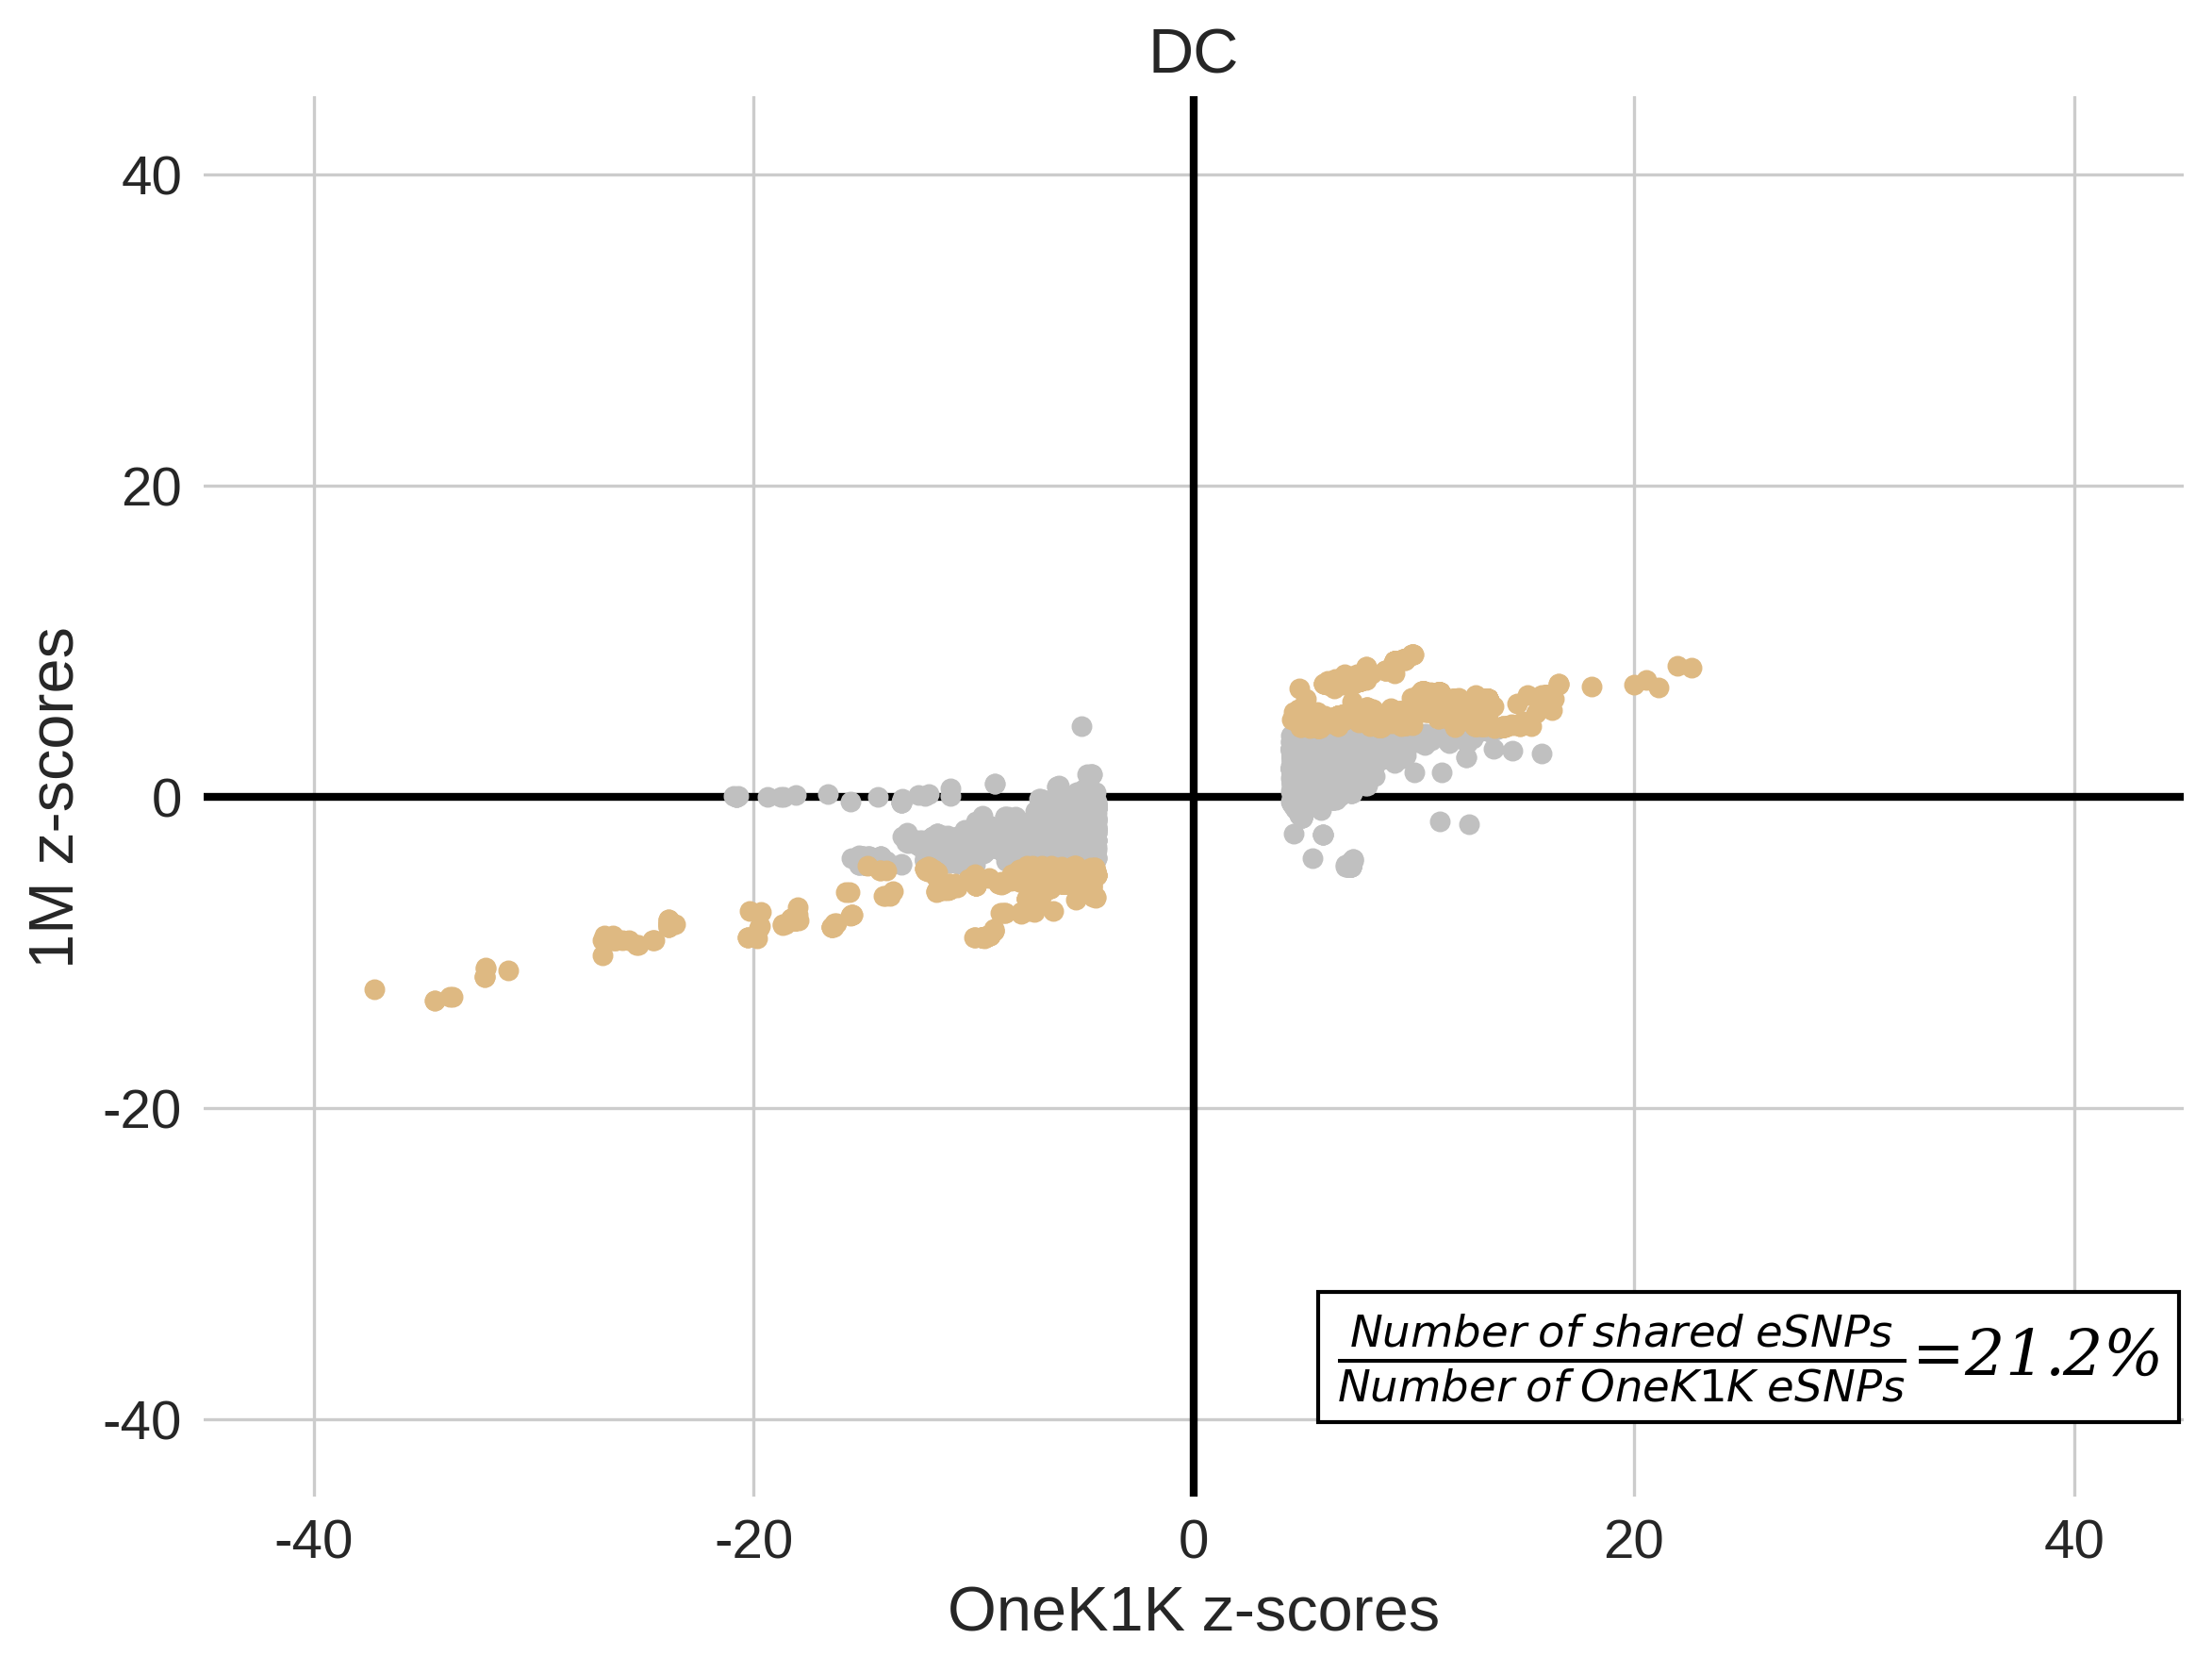

In [252]:
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982']
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['text.usetex'] = False
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[cell_ids]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_1m_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_1m2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_1m_con, color=c1, s=s)

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)
ax.set_xlabel('OneK1K z-scores', fontsize=label_font)
ax.set_ylabel('1M z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'normal',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;OneK1K\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

In [253]:
### ibsep vs 1k1k
## sig: blue
pval_thres = 1e-5
sig_merged_blue_1k1k = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL_BLUE < pval_thres)]
sig_merged_only_blue = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL_BLUE >= pval_thres)]
print(sig_merged_blue_1k1k.shape, sig_merged_only_blue.shape)
# both sig
z_blue = sig_merged_blue_1k1k.Z_BLUE.values
z_1k1k = sig_merged_blue_1k1k.Z_1K1K.values
print(len(z_blue), len(z_1k1k))
concord_ids = np.where((z_blue * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_blue * z_1k1k) < 0)[0]
z_blue_con = z_blue[concord_ids]
z_blue_dis = z_blue[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_blue2 = sig_merged_only_blue.Z_BLUE.values
z_1k1k2 = sig_merged_only_blue.Z_1K1K.values
z_thres = abs(ss.norm.ppf(1e-5))
concord_sig = sum((z_blue * z_1k1k) >= 0)/len((z_blue * z_1k1k) >= 0)
concord_all = (sum((z_blue * z_1k1k) >= 0) + sum((z_blue2 * z_1k1k2) >= 0)) / (len((z_blue * z_1k1k) >= 0) + len((z_blue2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_blue_1k1k) / (len(sig_merged_blue_1k1k) + len(sig_merged_only_blue))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K1 eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(2937, 21) (4343, 21)
2937 2937
Concordance sig: 98.8%, concordance all: 98.1%
#Shared eSNPs/#OneK1K1 eSNPs: 40.3%


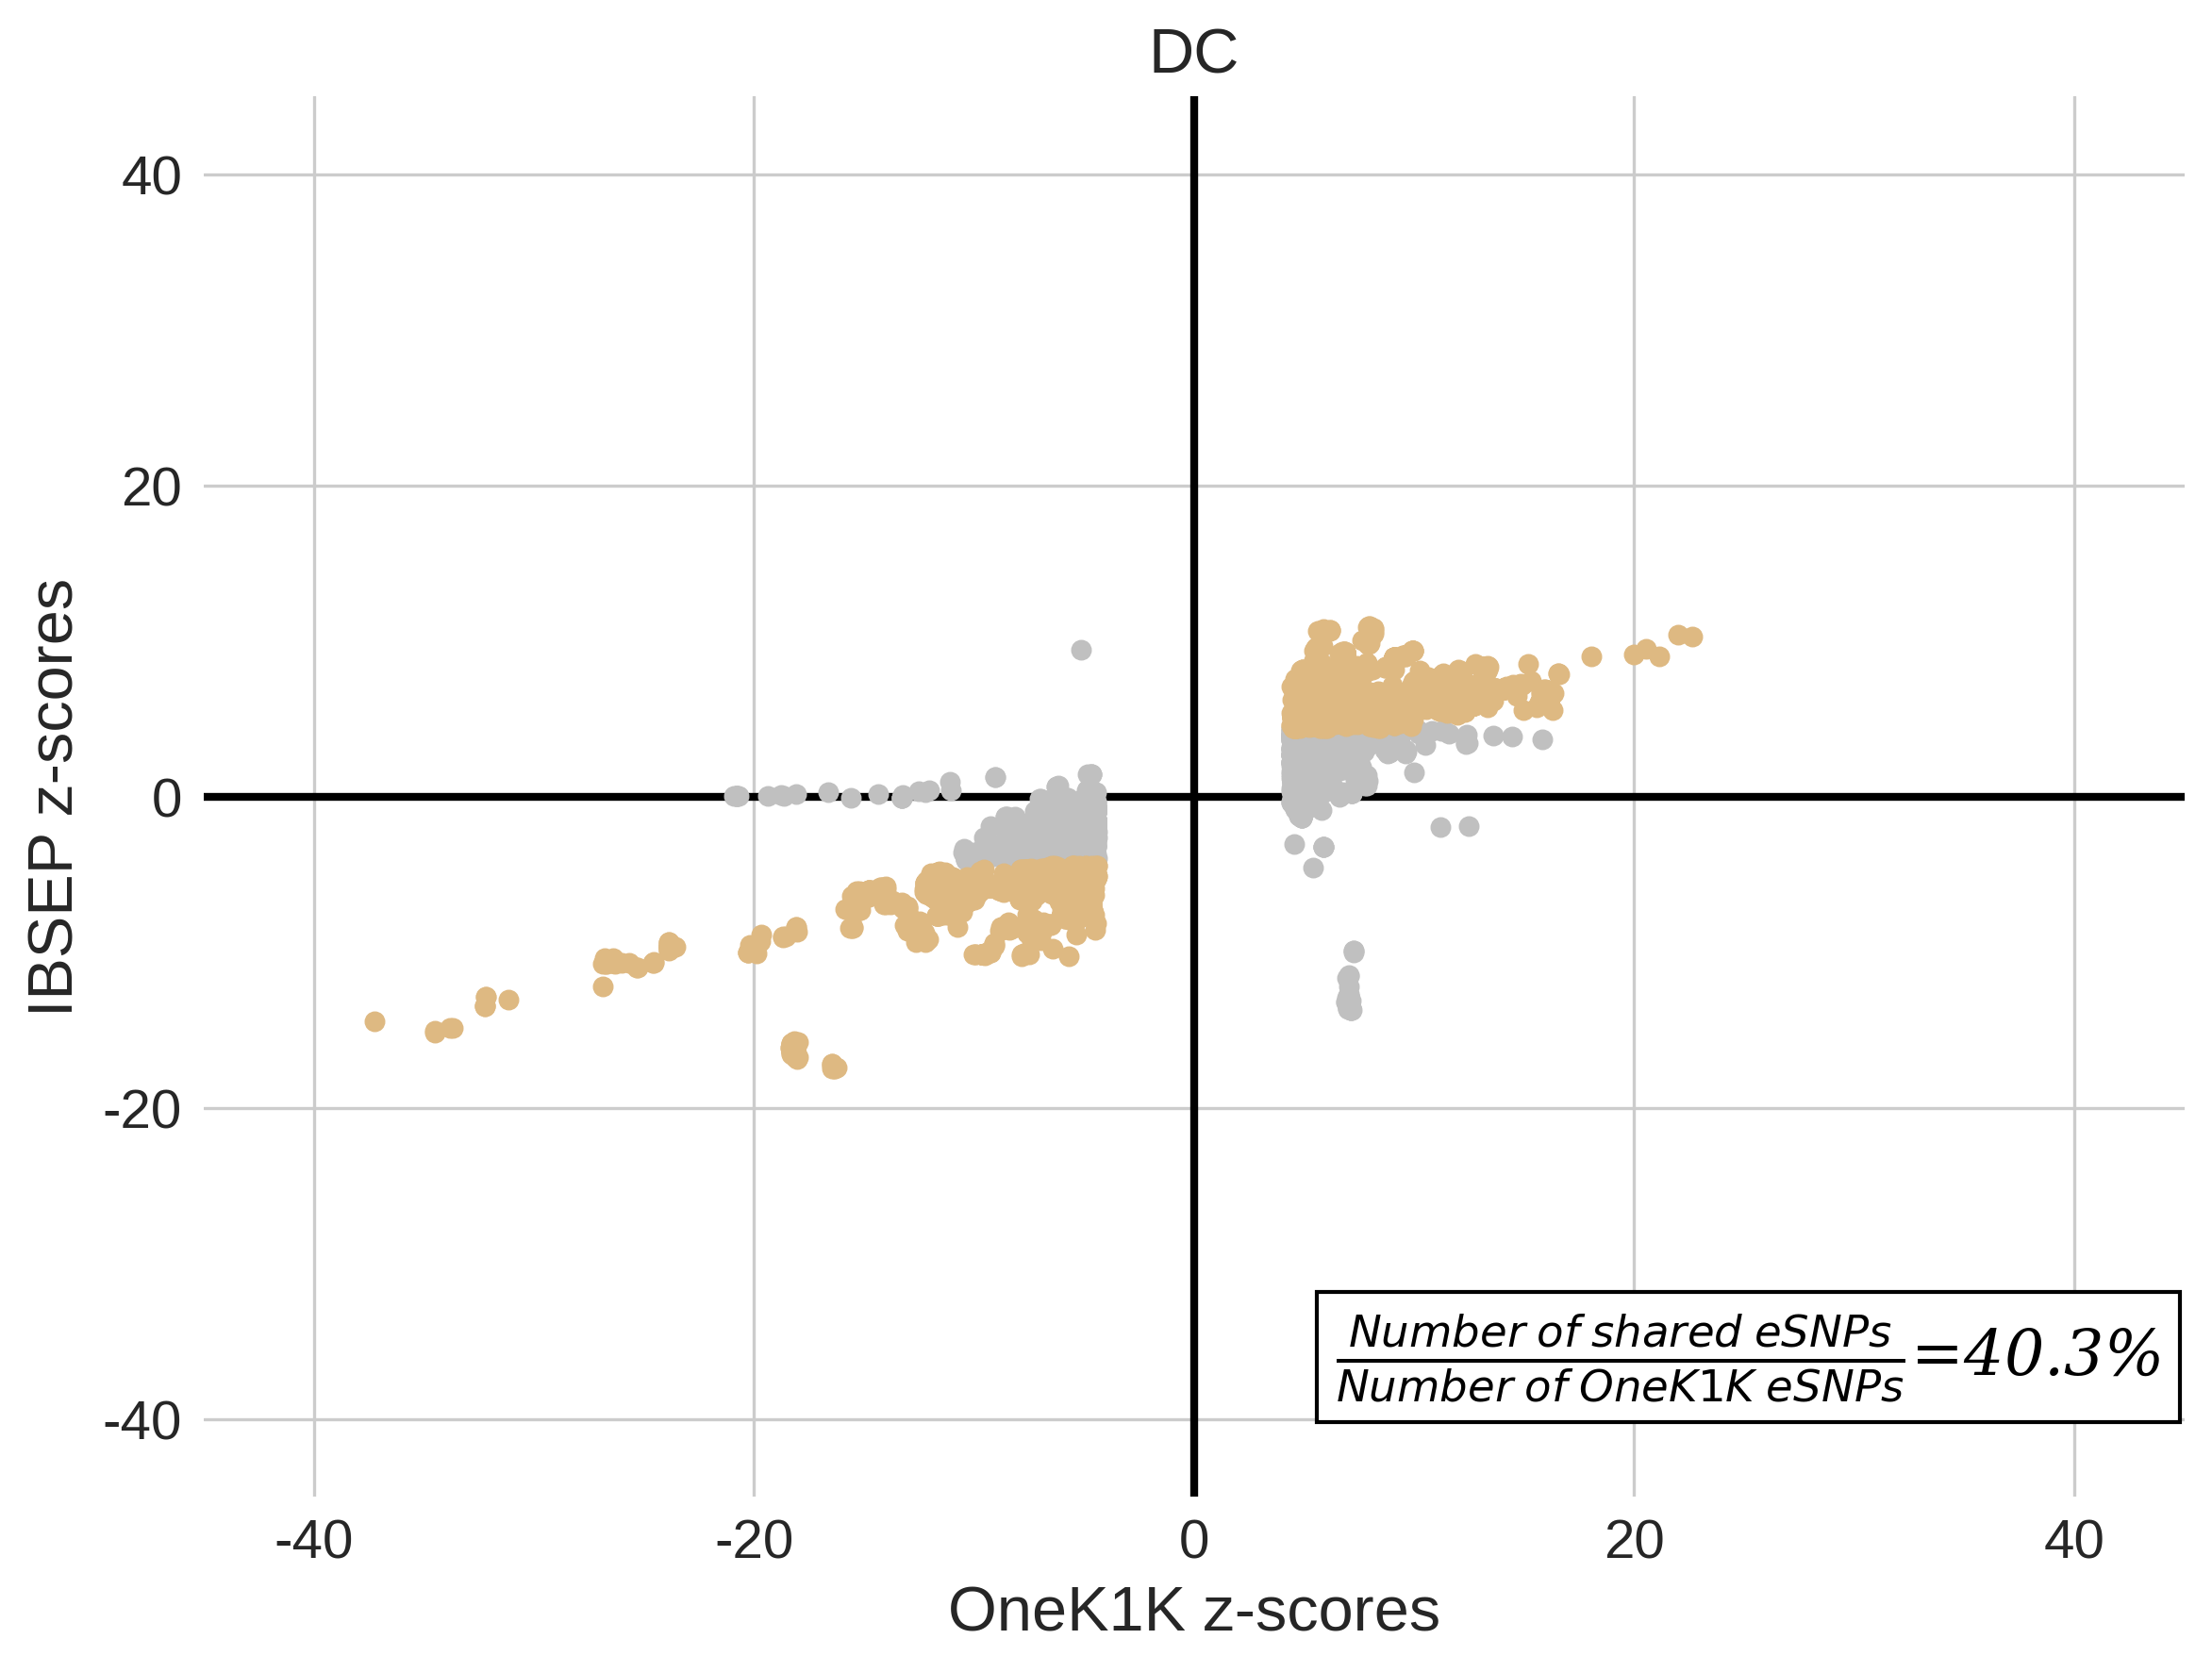

In [254]:
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-v0_8-whitegrid')
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[cell_ids]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_blue_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_blue2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_blue_con, color=c1, s=s)

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)

ax.set_xlabel('OneK1K z-scores', fontsize=label_font)
ax.set_ylabel('IBSEP z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'regular',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;OneK1K\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

## Neutrophil

In [6]:
cell_type = 'neutrophil'
res_neutro = pd.read_csv('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/allChrMols_neutrophil_blue_pval0.0001_tau1.0_truncorr.csv', sep='\t')
res_neutro.shape

(2140776, 13)

In [7]:
merged_n15_bp = pd.merge(res_neutro, df_bp[['rsid', 'ref', 'alt', 'gene_id', 'beta', 'se', 'pvalue']], left_on=['GENEID', 'SNP'], right_on=['gene_id', 'rsid'], how='inner')
print(merged_n15_bp.shape)
merged_n15_bp = merged_n15_bp.drop_duplicates(subset=['GENEID', 'SNP'], keep='first')
print(merged_n15_bp.shape)
rev_ids = (merged_n15_bp.alt != merged_n15_bp.A2)
print(len(rev_ids))
merged_n15_bp.loc[rev_ids, 'beta'] = -merged_n15_bp.loc[rev_ids, 'beta'].values
merged_n15_bp['Z'] = merged_n15_bp['BETA'] / merged_n15_bp['SE']
merged_n15_bp['Z_BLUE'] = merged_n15_bp['BETA_BLUE'] / merged_n15_bp['SE_BLUE']
merged_n15_bp['Z_BP'] = merged_n15_bp['beta'] / merged_n15_bp['se']

(1937609, 20)
(1114389, 20)
1114389


In [8]:
### neutro2015 vs bp
## sig
pval_thres = 1e-5
sig_merged_1m_1k1k = merged_n15_bp.loc[(merged_n15_bp.pvalue < pval_thres) & (merged_n15_bp.PVAL < pval_thres)]
sig_merged_only_1m = merged_n15_bp.loc[(merged_n15_bp.pvalue < pval_thres) & (merged_n15_bp.PVAL >= pval_thres)]
print(sig_merged_1m_1k1k.shape, sig_merged_only_1m.shape)
# both sig
z_1m = sig_merged_1m_1k1k.Z.values
z_1k1k = sig_merged_1m_1k1k.Z_BP.values
print(len(z_1m), len(z_1k1k))
concord_ids = np.where((z_1m * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_1m * z_1k1k) < 0)[0]
z_1m_con = z_1m[concord_ids]
z_1m_dis = z_1m[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_1m2 = sig_merged_only_1m.Z.values
z_1k1k2 = sig_merged_only_1m.Z_BP.values
z_thres = abs(ss.norm.ppf(1e-5))
concord_sig = sum((z_1m * z_1k1k) >= 0)/len((z_1m * z_1k1k) >= 0)
concord_all = (sum((z_1m * z_1k1k) >= 0) + sum((z_1m2 * z_1k1k2) >= 0)) / (len((z_1m * z_1k1k) >= 0) + len((z_1m2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_1m_1k1k) / (len(sig_merged_1m_1k1k) + len(sig_merged_only_1m))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(16745, 23) (98174, 23)
16745 16745
Concordance sig: 100.0%, concordance all: 85.2%
#Shared eSNPs/#OneK1K eSNPs: 14.6%


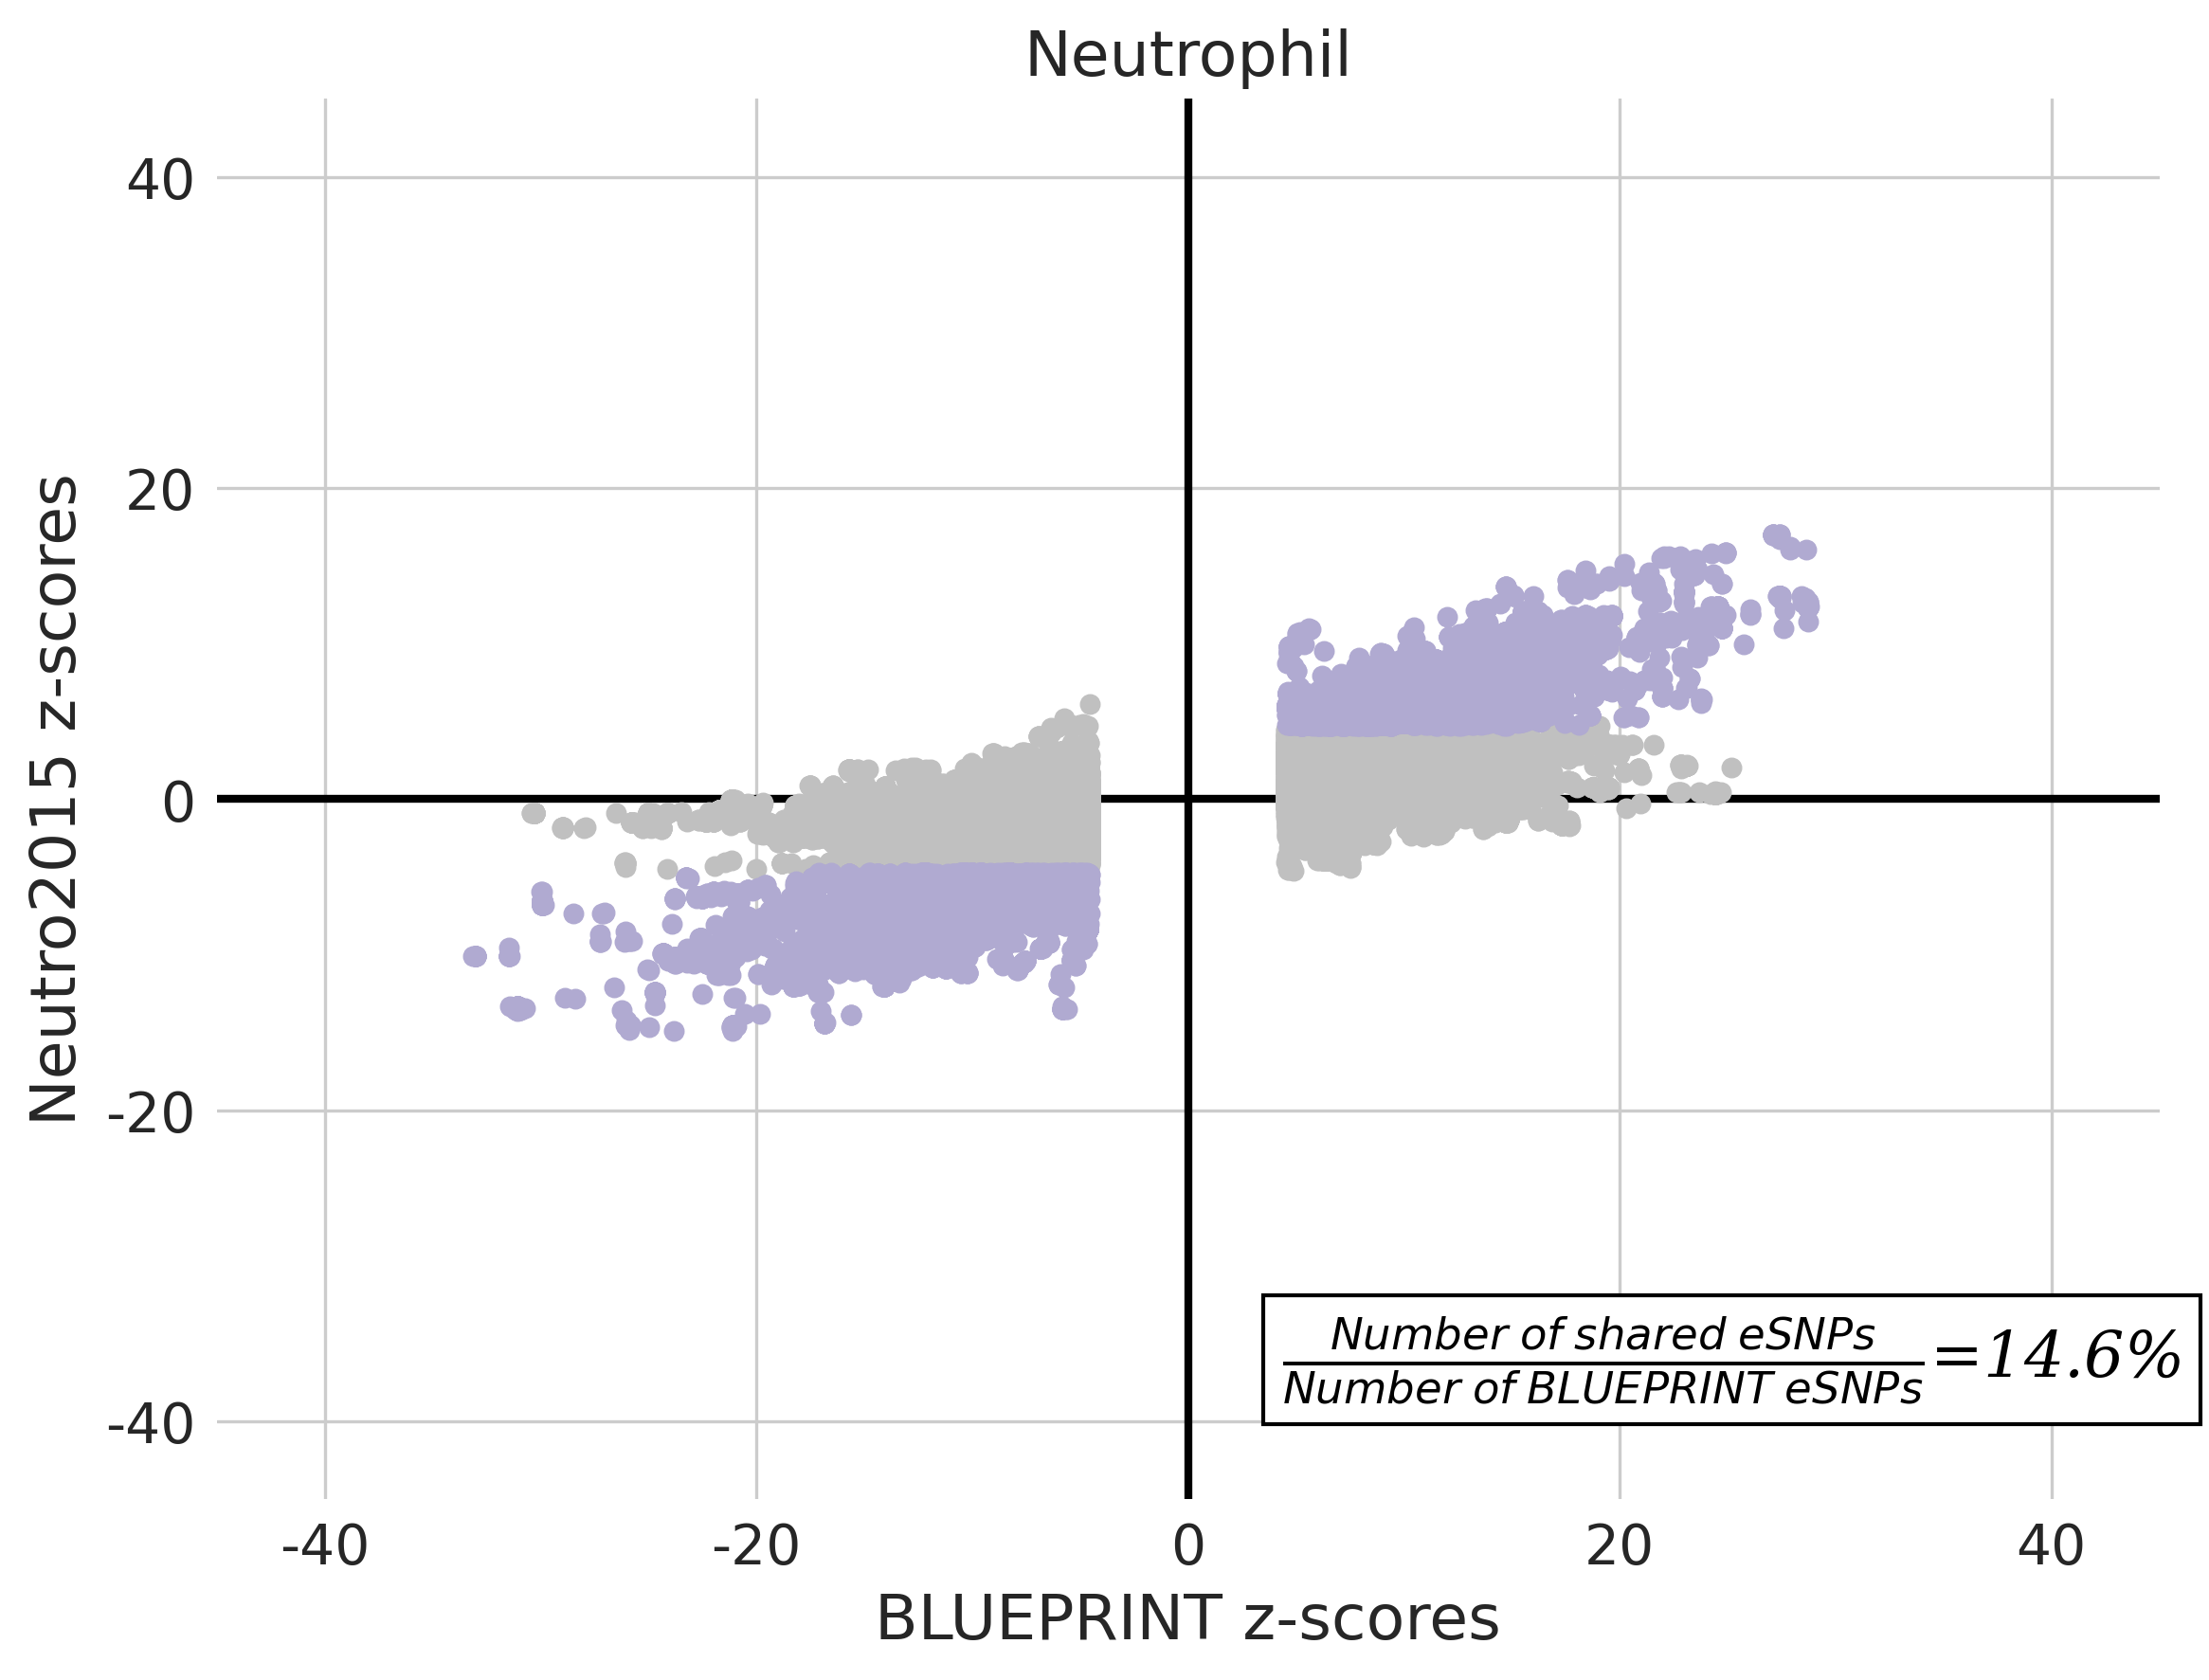

In [17]:
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982', '#B0AAD1']
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-whitegrid')
mpl.rcParams['text.usetex'] = False
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[-1]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_1m_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_1m2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_1m_con, color=c1, s=s)

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)
ax.set_xlabel('BLUEPRINT z-scores', fontsize=label_font)
ax.set_ylabel('Neutro2015 z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'normal',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;BLUEPRINT\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

In [18]:
### ibsep vs bp
## sig: blue
pval_thres = 1e-5
sig_merged_blue_1k1k = merged_n15_bp.loc[(merged_n15_bp.pvalue < pval_thres) & (merged_n15_bp.PVAL_BLUE < pval_thres)]
sig_merged_only_blue = merged_n15_bp.loc[(merged_n15_bp.pvalue < pval_thres) & (merged_n15_bp.PVAL_BLUE >= pval_thres)]
print(sig_merged_blue_1k1k.shape, sig_merged_only_blue.shape)
# both sig
z_blue = sig_merged_blue_1k1k.Z_BLUE.values
z_1k1k = sig_merged_blue_1k1k.Z_BP.values
print(len(z_blue), len(z_1k1k))
concord_ids = np.where((z_blue * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_blue * z_1k1k) < 0)[0]
z_blue_con = z_blue[concord_ids]
z_blue_dis = z_blue[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_blue2 = sig_merged_only_blue.Z_BLUE.values
z_1k1k2 = sig_merged_only_blue.Z_BP.values
z_thres = abs(ss.norm.ppf(1e-5))
concord_sig = sum((z_blue * z_1k1k) >= 0)/len((z_blue * z_1k1k) >= 0)
concord_all = (sum((z_blue * z_1k1k) >= 0) + sum((z_blue2 * z_1k1k2) >= 0)) / (len((z_blue * z_1k1k) >= 0) + len((z_blue2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_blue_1k1k) / (len(sig_merged_blue_1k1k) + len(sig_merged_only_blue))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K1 eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(67674, 23) (47245, 23)
67674 67674
Concordance sig: 97.0%, concordance all: 92.3%
#Shared eSNPs/#OneK1K1 eSNPs: 58.9%


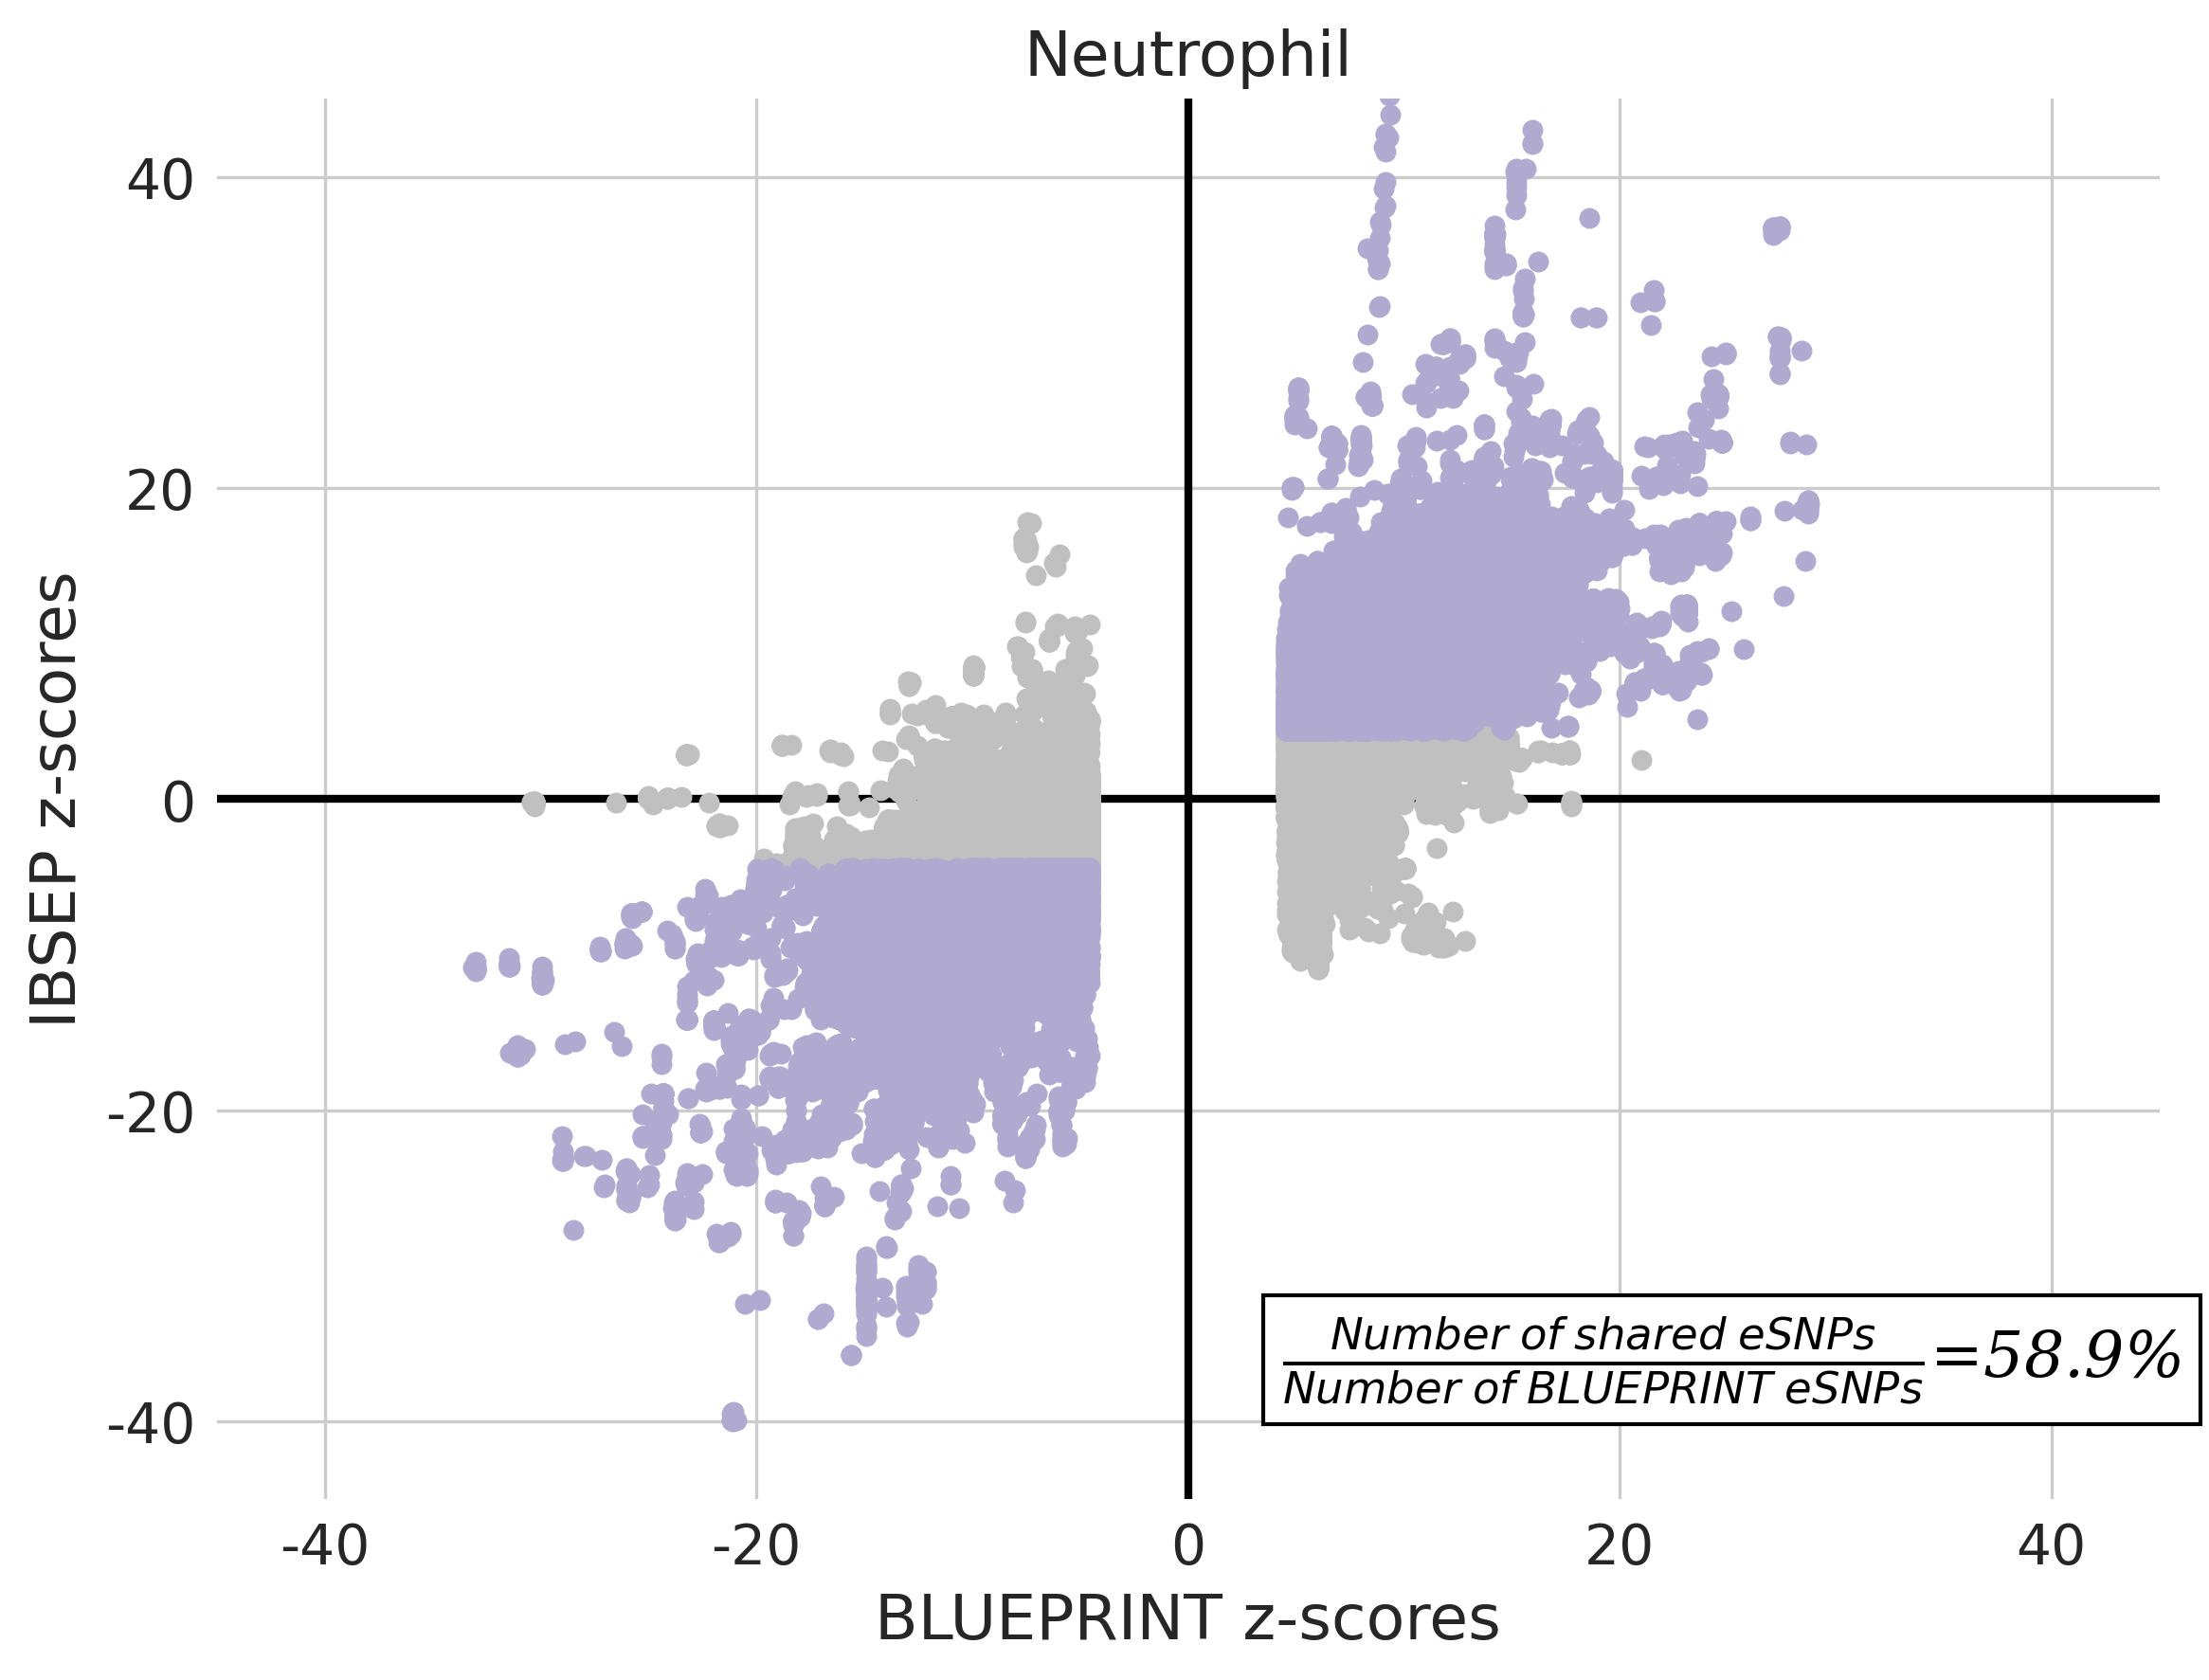

In [19]:
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-whitegrid')
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[-1]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_blue_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_blue2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_blue_con, color=c1, s=s)

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)

ax.set_xlabel('BLUEPRINT z-scores', fontsize=label_font)
ax.set_ylabel('IBSEP z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'regular',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;BLUEPRINT\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

## Add marker: CD4 CD247 rs7523907

In [811]:
cell_type = 'CD4T'
cell_ids = sorted_cell_ids_map_inv[cell_type]
sub_celltypes = celltype_map_1k[cell_type]
t0 = time.time()
df_blue = pd.read_csv(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/allChrMols_{cell_type}_blue_pval0.0001_tau1.0_truncorr.csv', sep='\t')
df_blue = df_blue.drop_duplicates(subset=['GENEID', 'SNP'], keep='first')
print(cell_type, df_blue.shape)
dfs_1k1k = []
for sub_celltype in sub_celltypes:
    df_1k1k_ = pd.read_csv(f'/data2/xiaojiashun/eQTL/data/blood_data/1M/merged_sumstats/sub_celltypes/{sub_celltype}.txt.gz', sep='\t', compression='gzip')
    dfs_1k1k.append(df_1k1k_[['SNP_1M', 'GENEID_1M', 'BETA_1K1K', 'SE_1K1K', 'PVAL_1K1K']])
    print(sub_celltype, df_1k1k_.shape)
df_1k1k = pd.concat(dfs_1k1k)
print(f'Concated df_1k1k: {df_1k1k.shape}')
idx = df_1k1k.groupby(['SNP_1M', 'GENEID_1M'])['PVAL_1K1K'].transform(min) == df_1k1k['PVAL_1K1K']
df_1k1k = df_1k1k[idx]
print(f'df_1k1k (min pval): {df_1k1k.shape}')
merged_1m_blue_1k1k = pd.merge(df_blue, df_1k1k, left_on=['SNP', 'GENEID'], right_on=['SNP_1M', 'GENEID_1M'], how='inner')
print(merged_1m_blue_1k1k.shape)
merged_1m_blue_1k1k['Z'] = merged_1m_blue_1k1k['BETA'] / merged_1m_blue_1k1k['SE']
merged_1m_blue_1k1k['Z_BLUE'] = merged_1m_blue_1k1k['BETA_BLUE'] / merged_1m_blue_1k1k['SE_BLUE']
merged_1m_blue_1k1k['Z_1K1K'] = merged_1m_blue_1k1k['BETA_1K1K'] / merged_1m_blue_1k1k['SE_1K1K']
t1 = time.time()
print(f'{t1 - t0:.1f}s')

CD4T (1229953, 13)
cd4et (2724967, 20)
cd4nc (3398925, 20)
cd4sox4 (1444781, 20)
Concated df_1k1k: (7568673, 5)
df_1k1k (min pval): (3170475, 5)
(1229970, 18)
18.4s


In [869]:
### 1m vs 1k1k
## sig
pval_thres = 1e-5
sig_merged_1m_1k1k = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL < pval_thres)]
sig_merged_only_1m = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL >= pval_thres)]
print(sig_merged_1m_1k1k.shape, sig_merged_only_1m.shape)
# both sig
z_1m = sig_merged_1m_1k1k.Z.values
z_1k1k = sig_merged_1m_1k1k.Z_1K1K.values
print(len(z_1m), len(z_1k1k))
concord_ids = np.where((z_1m * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_1m * z_1k1k) < 0)[0]
z_1m_con = z_1m[concord_ids]
z_1m_dis = z_1m[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_1m2 = sig_merged_only_1m.Z.values
z_1k1k2 = sig_merged_only_1m.Z_1K1K.values
concord_sig = sum((z_1m * z_1k1k) >= 0)/len((z_1m * z_1k1k) >= 0)
concord_all = (sum((z_1m * z_1k1k) >= 0) + sum((z_1m2 * z_1k1k2) >= 0)) / (len((z_1m * z_1k1k) >= 0) + len((z_1m2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_1m_1k1k) / (len(sig_merged_1m_1k1k) + len(sig_merged_only_1m))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(8061, 21) (89139, 21)
8061 8061
Concordance sig: 99.8%, concordance all: 88.4%
#Shared eSNPs/#OneK1K eSNPs: 8.3%


In [816]:
gene_id_map.loc[gene_id_map.GENENAME=='CD247',:]

,GENEID,GENENAME,MOLID
399,ENSG00000198821,CD247,ILMN_1676924


In [817]:
mark_row = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.GENEID=='ENSG00000198821') & (merged_1m_blue_1k1k.SNP=='rs7523907')]
mark_z = mark_row.Z.values[0]
mark_z_blue = mark_row.Z_BLUE.values[0]
mark_z_1k1k = mark_row.Z_1K1K.values[0]
mark_z, mark_z_blue, mark_z_1k1k

(-3.9476471000000015, -5.412970006685875, -9.577257504639105)

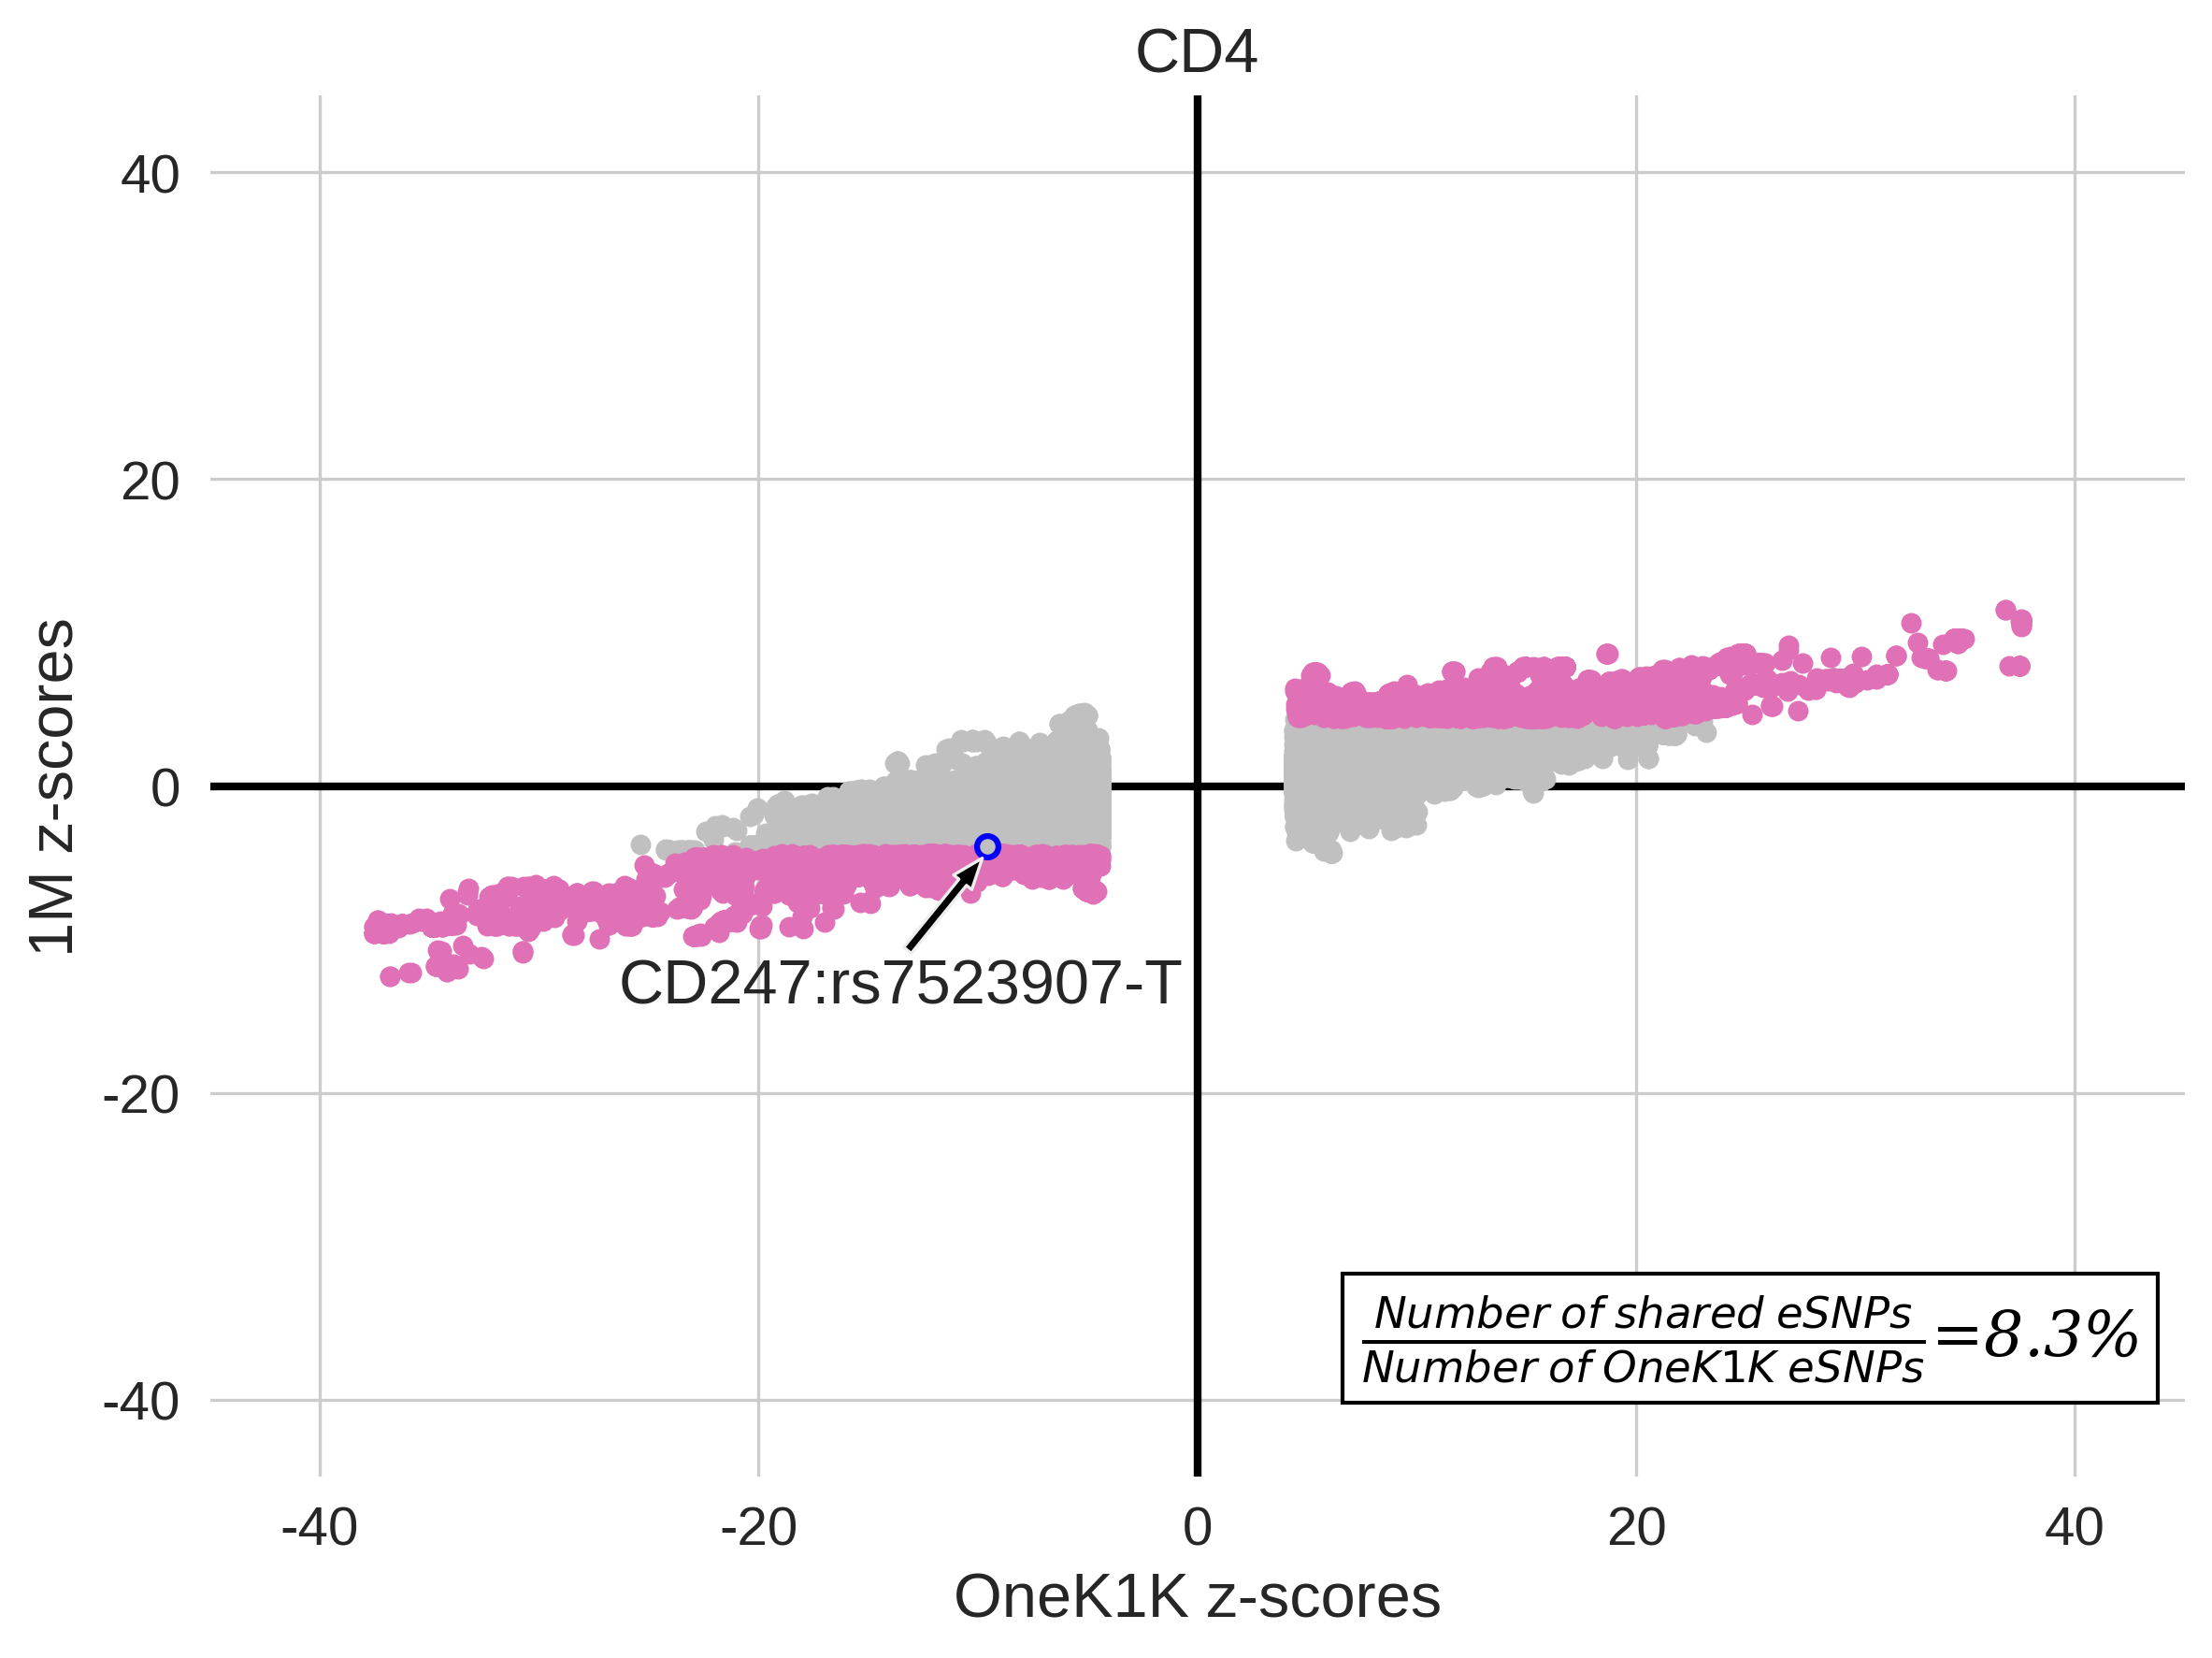

In [872]:
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982']
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['text.usetex'] = False
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[cell_ids]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_1m_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_1m2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_1m_con, color=c1, s=s)
# mark one snp
ax.scatter(mark_z_1k1k, mark_z, edgecolor='blue', facecolor=c2, s=s*1.5, linewidth=1.5)
ax.annotate('CD247:rs7523907-T',
            xy=(-9.8, -4.7),  # theta, radius
            xytext=(-13.5, -15),    # fraction, fraction
            fontsize=label_font,
            arrowprops=dict(facecolor='black', width=2.5, headwidth=6, headlength=8),
            horizontalalignment='center',
            verticalalignment='bottom',
            )

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)
ax.set_xlabel('OneK1K z-scores', fontsize=label_font)
ax.set_ylabel('1M z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')

font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'normal',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;OneK1K\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

In [873]:
### ibsep vs 1k1k
## sig: blue
pval_thres = 1e-5
sig_merged_blue_1k1k = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL_BLUE < pval_thres)]
sig_merged_only_blue = merged_1m_blue_1k1k.loc[(merged_1m_blue_1k1k.PVAL_1K1K < pval_thres) & (merged_1m_blue_1k1k.PVAL_BLUE >= pval_thres)]
print(sig_merged_blue_1k1k.shape, sig_merged_only_blue.shape)
# both sig
z_blue = sig_merged_blue_1k1k.Z_BLUE.values
z_1k1k = sig_merged_blue_1k1k.Z_1K1K.values
print(len(z_blue), len(z_1k1k))
concord_ids = np.where((z_blue * z_1k1k) >= 0)[0]
disconcord_ids = np.where((z_blue * z_1k1k) < 0)[0]
z_blue_con = z_blue[concord_ids]
z_blue_dis = z_blue[disconcord_ids]
z_1k1k_con = z_1k1k[concord_ids]
z_1k1k_dis = z_1k1k[disconcord_ids]
# only 1m sig
z_blue2 = sig_merged_only_blue.Z_BLUE.values
z_1k1k2 = sig_merged_only_blue.Z_1K1K.values
z_thres = abs(ss.norm.ppf(1e-5))
concord_sig = sum((z_blue * z_1k1k) >= 0)/len((z_blue * z_1k1k) >= 0)
concord_all = (sum((z_blue * z_1k1k) >= 0) + sum((z_blue2 * z_1k1k2) >= 0)) / (len((z_blue * z_1k1k) >= 0) + len((z_blue2 * z_1k1k2) >= 0))
recovered_1k1k_ratio = len(sig_merged_blue_1k1k) / (len(sig_merged_blue_1k1k) + len(sig_merged_only_blue))
print(f'Concordance sig: {concord_sig*100:.1f}%, concordance all: {concord_all*100:.1f}%')
print(f'#Shared eSNPs/#OneK1K1 eSNPs: {recovered_1k1k_ratio*100:.1f}%')

(17952, 21) (79248, 21)
17952 17952
Concordance sig: 98.6%, concordance all: 89.5%
#Shared eSNPs/#OneK1K1 eSNPs: 18.5%


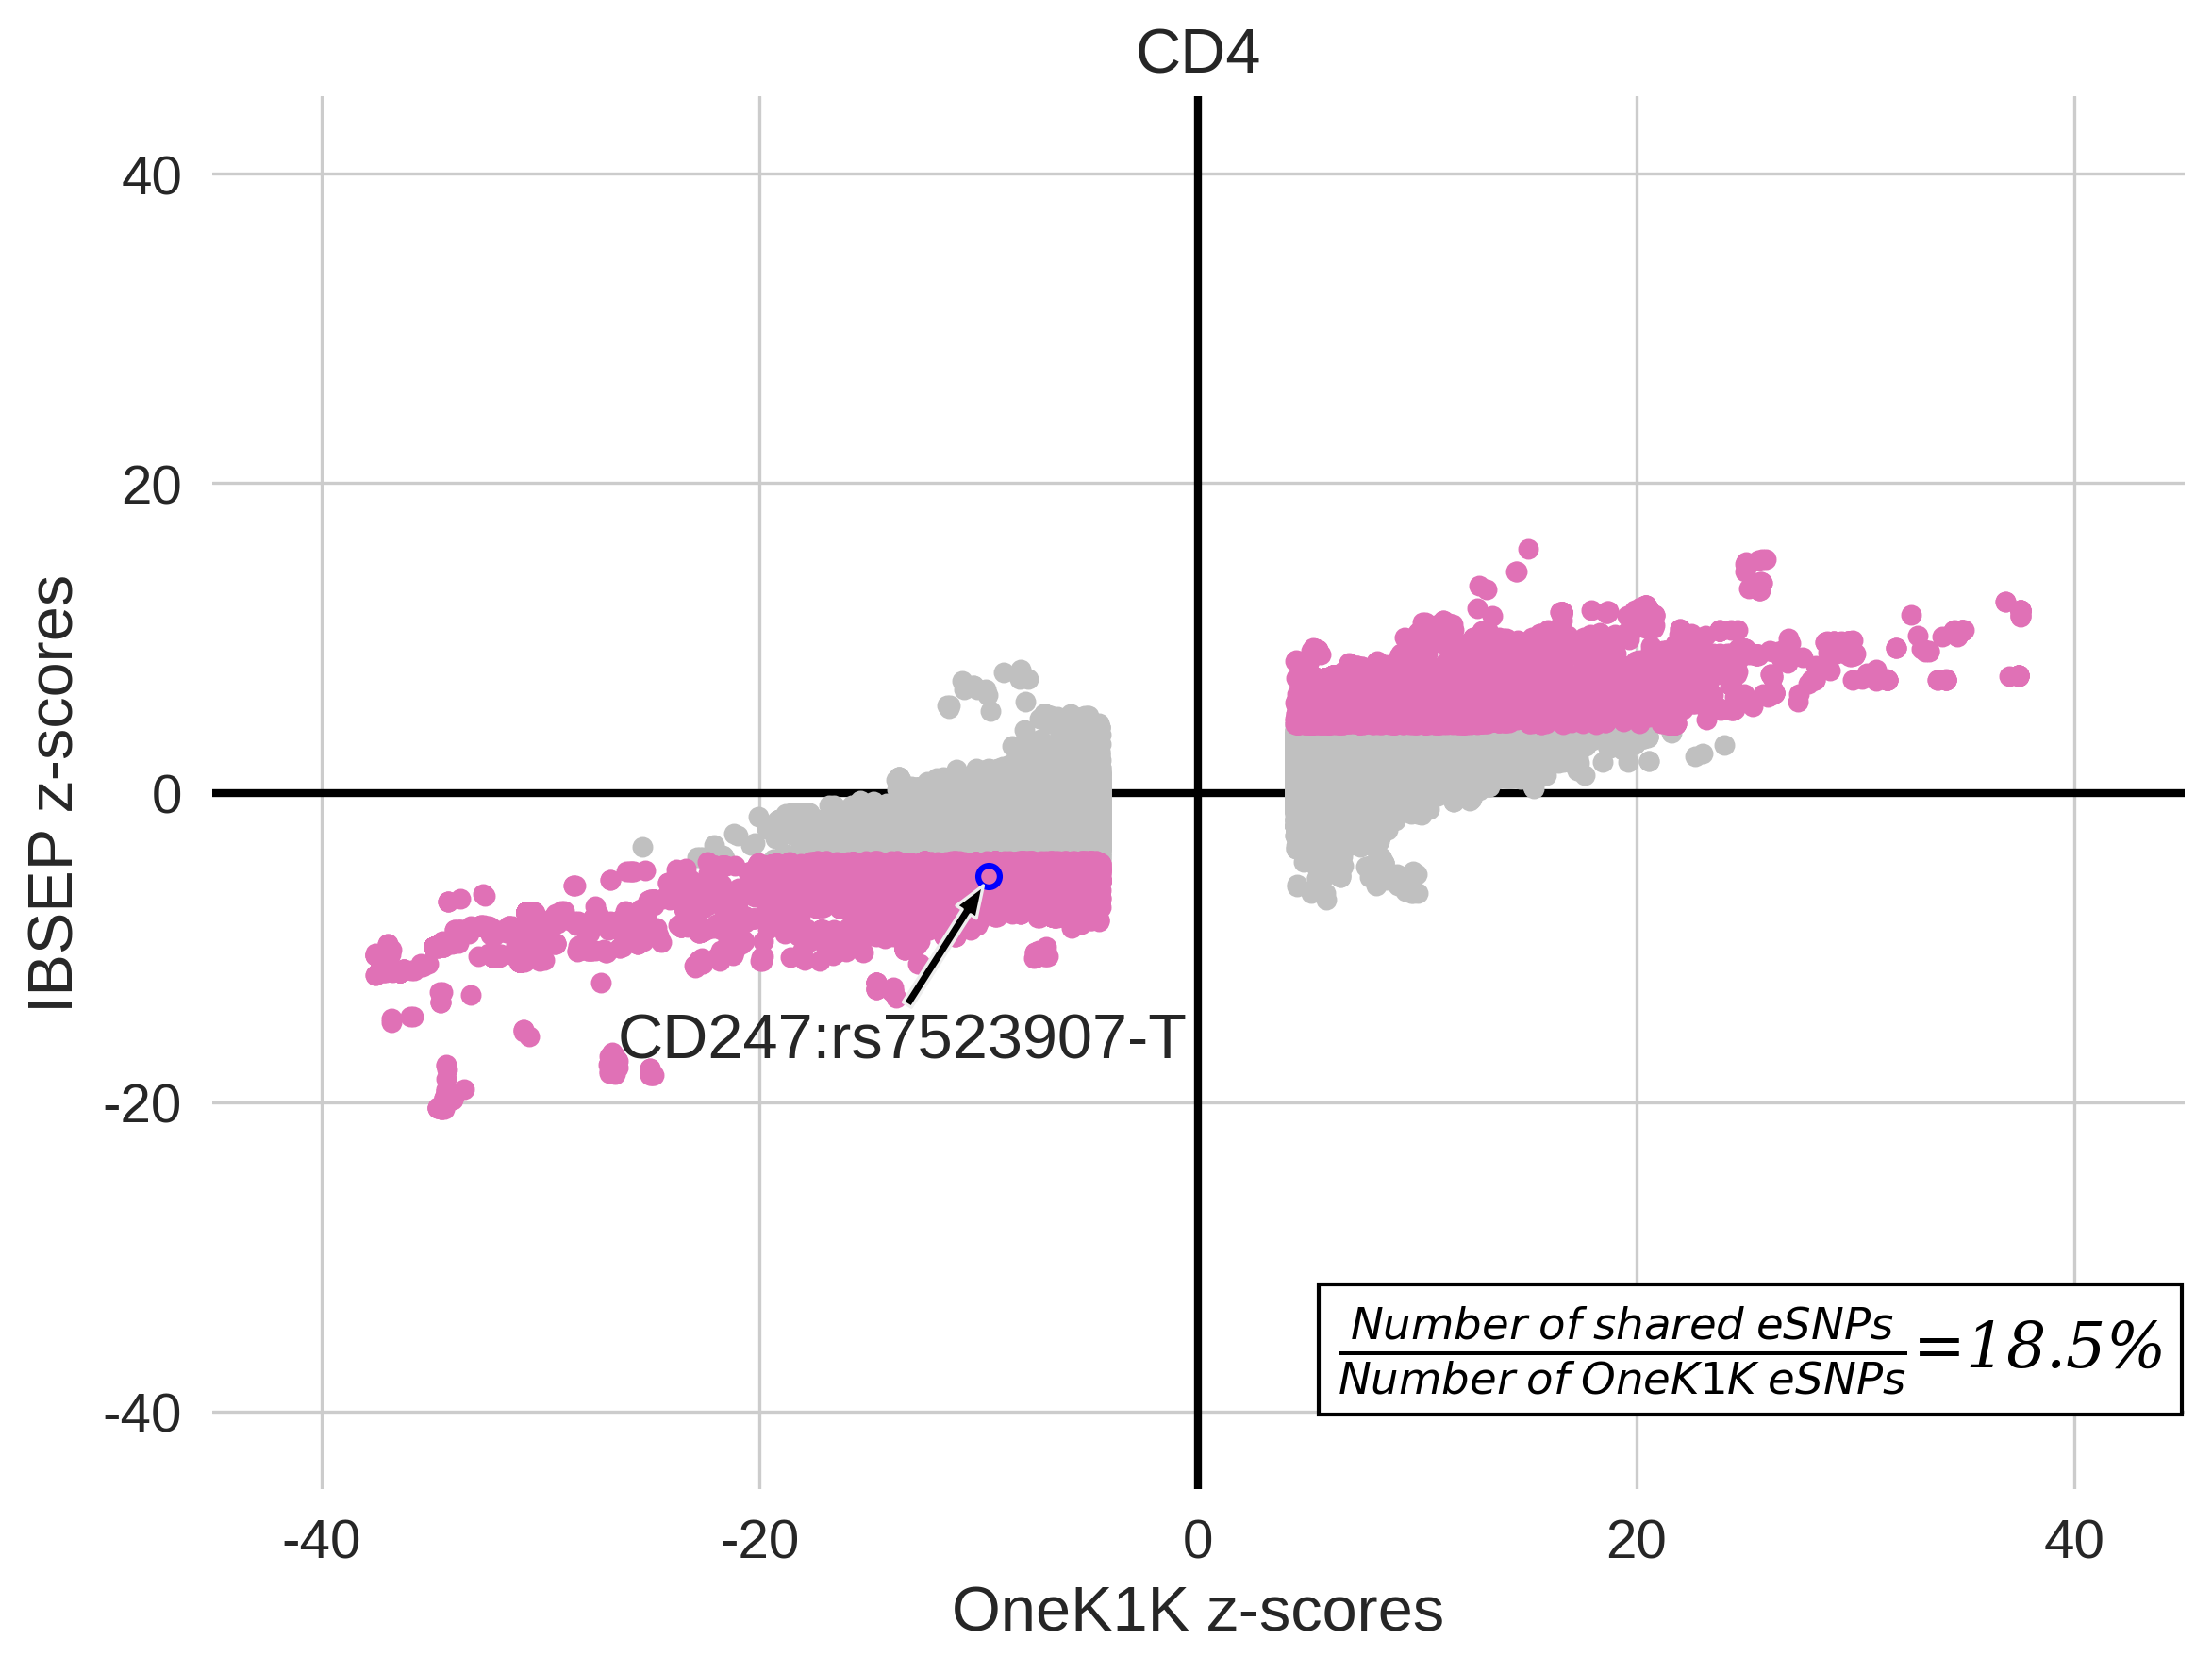

In [874]:
sns.set_context('paper',font_scale=1.)
plt.style.use('seaborn-v0_8-whitegrid')
alpha = 1
s = 20
ls = (0, (5, 10))
tick_font = 14
label_font = 16
title_font = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=300)
c1 = colors[cell_ids]
c2 = '#C0C0C0'

ax.axvline(x=0, color='black', lw=2, zorder=1)
ax.axhline(y=0, color='black', lw=2, zorder=1)
ax.scatter(z_1k1k_dis, z_blue_dis, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k2, z_blue2, color=c2, s=s, alpha=alpha)
ax.scatter(z_1k1k_con, z_blue_con, color=c1, s=s)
# mark one snp
ax.scatter(mark_z_1k1k, mark_z_blue, edgecolor='blue', facecolor=c1, s=s*1.5, linewidth=1.5)
ax.annotate('CD247:rs7523907-T',
            xy=(-9.8, -6),  # theta, radius
            xytext=(-13.5, -18),    # fraction, fraction
            fontsize=label_font,
            arrowprops=dict(facecolor='black', width=2.5, headwidth=6, headlength=8, shrink=1),
            horizontalalignment='center',
            verticalalignment='bottom',
            )

ax.set_xticks(np.arange(-40, 41, 20))
ax.set_xticklabels(np.arange(-40, 41, 20), fontsize=tick_font)
ax.set_yticks(np.arange(-40, 41, 20))
ax.set_yticklabels(np.arange(-40, 41, 20), fontsize=tick_font)

ax.tick_params(axis='both', which='major', length=2, width=0.5, labelsize=tick_font)
ax.tick_params(axis='both', which='minor', length=2, width=0.5, labelsize=tick_font)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xlim(left=-45, right=45)
ax.set_ylim(-45, 45)

ax.set_xlabel('OneK1K z-scores', fontsize=label_font)
ax.set_ylabel('IBSEP z-scores', fontsize=label_font)
ax.set_title(sorted_cell_names[cell_type], fontsize=title_font)
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
font_ratio = {'family': 'serif',
              'style': 'italic',
        'color':  'black',
        'weight': 'regular',
        'size': label_font,
        'bbox': dict(boxstyle="square",
                   facecolor='white',
                   edgecolor='black',
                   lw=1
                   )
        }
ax.text(0.78, 0.1, r'$\frac{Number\;of\;shared\;eSNPs}{Number\;of\;OneK1K\;eSNPs}$=' + f'{recovered_1k1k_ratio*100:.1f}%', 
        fontdict=font_ratio, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.tight_layout()

# Heritability

In [ ]:
gene_mol_map = pd.read_csv('/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/gene_randmol_lookup.csv', sep='\t')
hsqs = {k: [] for k in sorted_cell_types}
for chr in range(1, 23):
    t0 = time.time()
    files = glob.glob(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/chr{chr}/*_Omega_blue.npz')
    tmp = []
    for x in files:
        y = x.split('/')[-1].split('-')[0]
        z = gene_mol_map.loc[gene_mol_map.GENEID==y].MOLID.values[0]
        tmp.append(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/chr{chr}/{y}-{z}_Omega_blue.npz')
    files = list(set(tmp))
    for file in files:
        est = np.load(file)
        for i, c in enumerate(est['cell_types']):
            if 'shrinkOmega' in est.files:
                hsqs[c].append(est['shrinkOmega'][i, i])
            else:
                hsqs[c].append(est['oriOmega'][i, i])
    print(f'CHR {chr}, {len(files)}, {time.time() - t0:.1f}s')

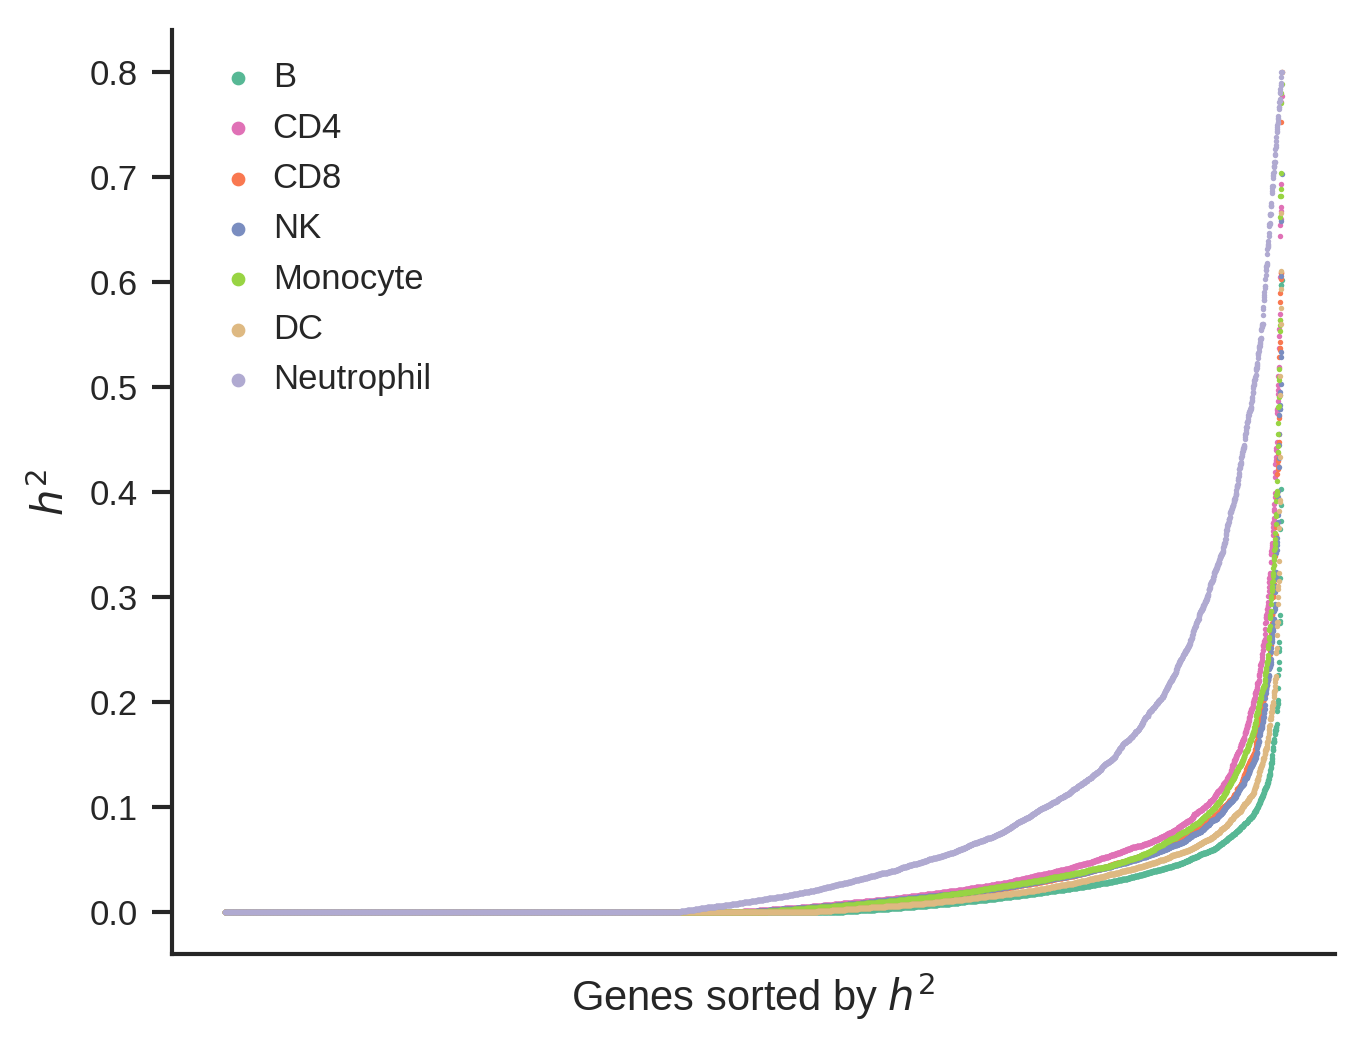

In [211]:
xmax = 10000
sns.set_context('paper',font_scale=1.25)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982', '#B0AAD1']
for i, ct in enumerate(hsqs.keys()):
    x = np.array(hsqs[ct])
    x = np.sort(x[np.where((x > 0) & (x < 0.8))])
    ax.scatter(np.linspace(0, xmax, len(x)), x, c=colors[i], marker='.', s=1, label=sorted_cell_names[ct])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_xlabel('Genes sorted by '+r'$h^2$', fontsize='small')
ax.set_ylabel(r'$h^2$', fontsize='small')
ax.legend(loc='upper left', markerscale=5, fontsize='x-small', handletextpad=0)
ax.tick_params(axis='both', which='major', labelsize='x-small')

# Cell type correlation

In [ ]:
hij_thres = 1e-4
corrs = {}
for c1 in sorted_cell_types:
    for c2 in sorted_cell_types:
        idx1 = sorted_cell_types.index(c1)
        idx2 = sorted_cell_types.index(c2)
        if idx1 < idx2:
            corrs[f'{c1}-{c2}'] = []
for chr in range(1, 23):
    t0 = time.time()
    files = glob.glob(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/chr{chr}/*_Omega_blue.npz')
    tmp = []
    for x in files:
        y = x.split('/')[-1].split('-')[0]
        z = gene_mol_map.loc[gene_mol_map.GENEID==y].MOLID.values[0]
        tmp.append(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/chr{chr}/{y}-{z}_Omega_blue.npz')
    files = list(set(tmp))
    for file in files:
        est = np.load(file)
        cells = est['cell_types']
        nc = len(cells)
        if nc > 1:
            for i in range(nc):
                c1 = cells[i]
                for j in range(nc):
                    c2 = cells[j]
                    idx1 = sorted_cell_types.index(c1)
                    idx2 = sorted_cell_types.index(c2)
                    if idx1 < idx2:
                        hij_z = est['oriOmega'][i, j] / est['oriOmega_se'][i, j]
                        hij_p = ss.norm.sf(abs(hij_z)) * 2
                        if hij_p < hij_thres:
                            corrs[f'{c1}-{c2}'].append(1)
                        else:
                            corrs[f'{c1}-{c2}'].append(0)
    print(f'CHR {chr}, {len(files)}, {time.time() - t0:.1f}s')

In [207]:
corr_ratio = {}
for k, v in corrs.items():
    if len(v) == 0:
        corr_ratio[k] = 0
    else:
        corr_ratio[k] = sum(v) / len(v)
corr_mat = np.empty((len(sorted_cell_types), len(sorted_cell_types)))
corr_mat.fill(np.nan)
for k, v in corr_ratio.items():
    c1, c2 = k.split('-')
    i = sorted_cell_types.index(c1)
    j = sorted_cell_types.index(c2)
    corr_mat[i, j] = v
masked_array = np.ma.array (corr_mat, mask=np.isnan(corr_mat))

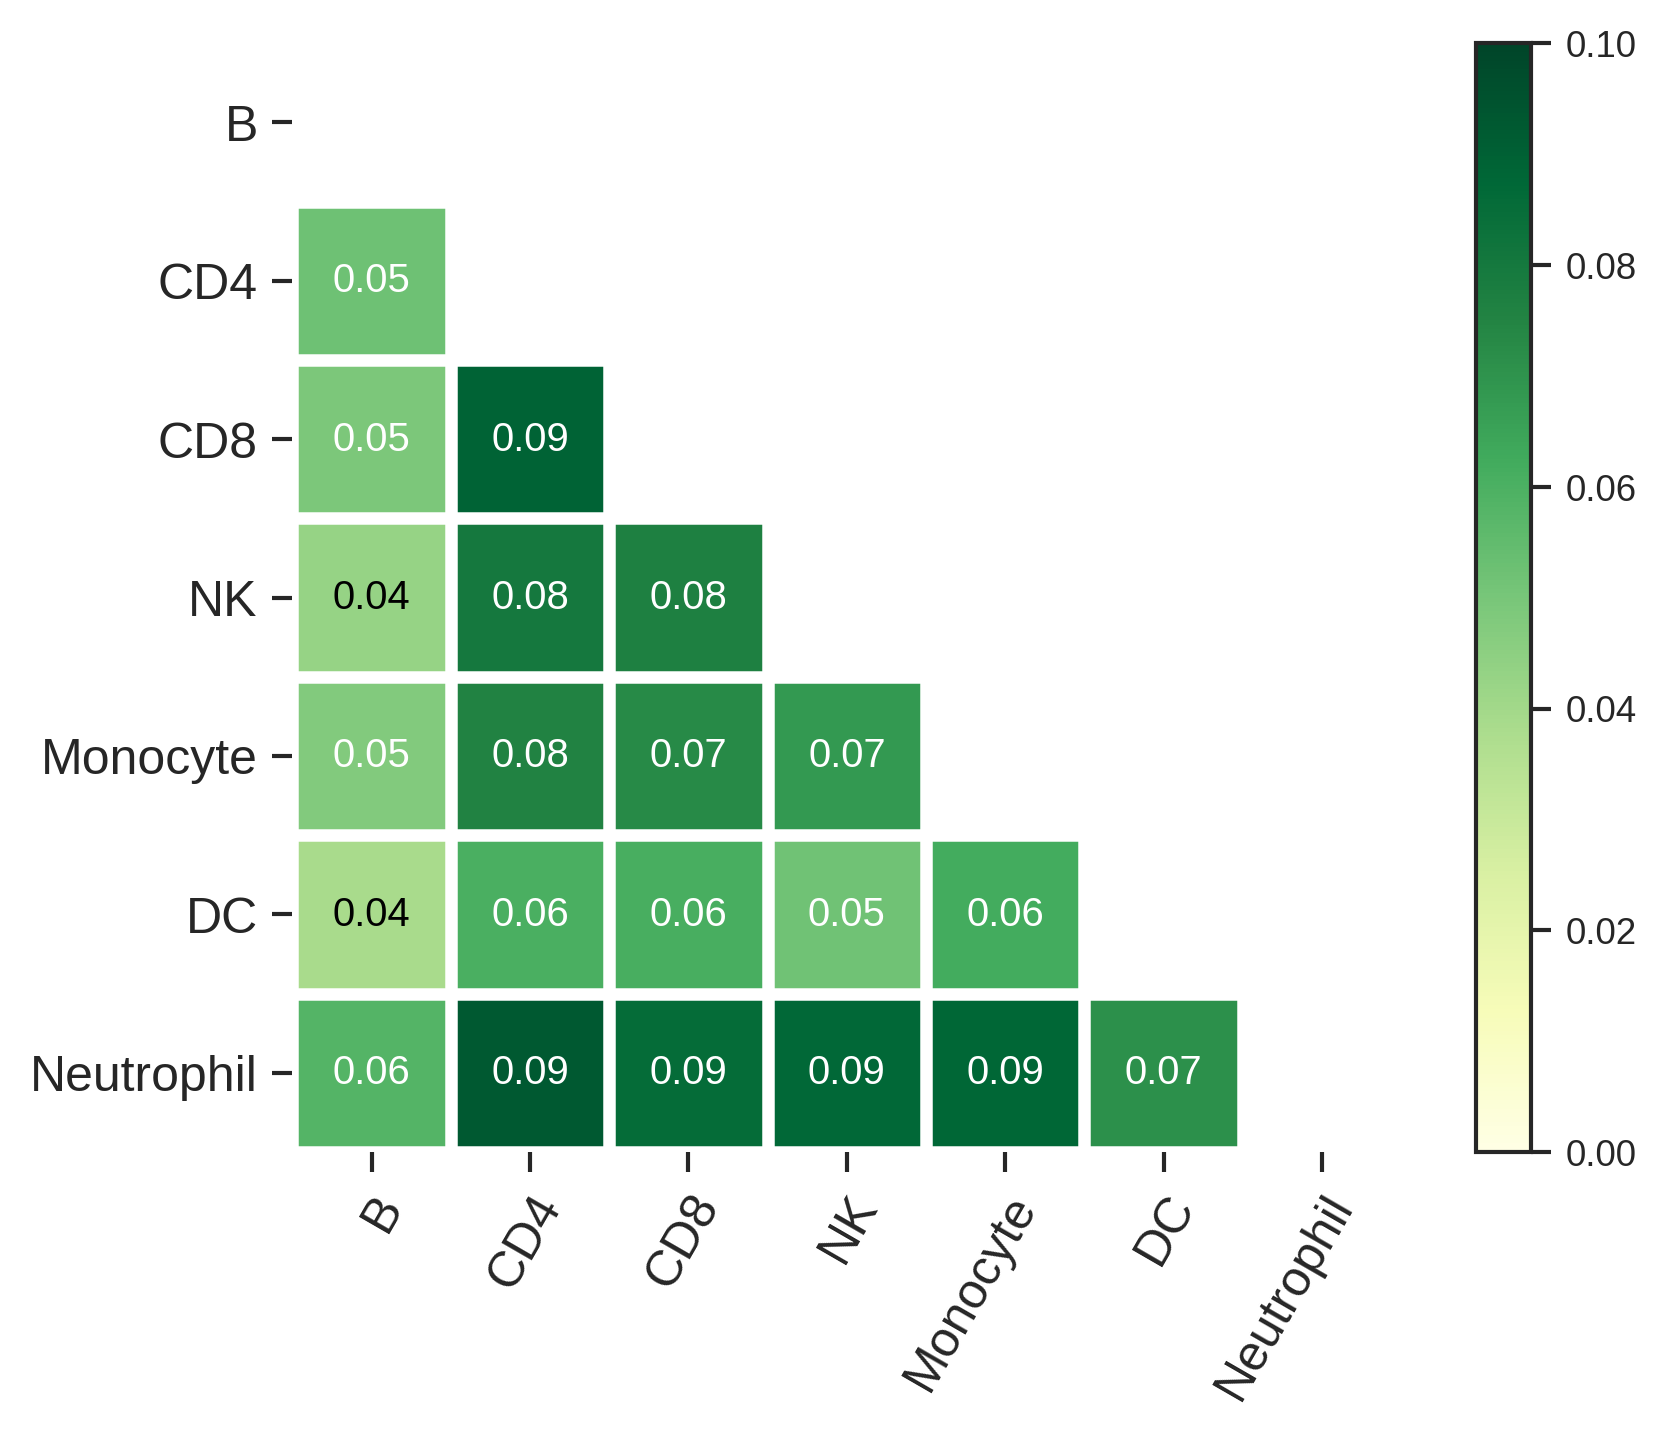

In [208]:
data = masked_array.T
cbarlabel = ''
col_labels = list(sorted_cell_names.values())
row_labels = list(sorted_cell_names.values())
threshold = None
valfmt="{x:.2f}"
textcolors=("black", "white")

fig, ax = plt.subplots(dpi=300)
# Plot the heatmap
cmap = mpl.cm.YlGn
cmap.set_bad('white',1.)
im = ax.imshow(data, cmap=cmap, vmin=0, vmax=0.1)

# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

# Show all ticks and label them with the respective list entries.
ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize=12)
ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize=12)

# Let the horizontal axes labeling appear on bottom.
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")

# Turn spines off and create white grid.
ax.spines[:].set_visible(False)

ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

if not isinstance(data, (list, np.ndarray)):
    data = im.get_array()

# Normalize the threshold to the images color range.
if threshold is not None:
    threshold = im.norm(threshold)
else:
    threshold = im.norm(data.max())/2.

# Set default alignment to center, but allow it to be
# overwritten by textkw.
kw = dict(horizontalalignment="center",
          verticalalignment="center")
# kw.update(textkw)

# Get the formatter in case a string is supplied
if isinstance(valfmt, str):
    valfmt = mpl.ticker.StrMethodFormatter(valfmt)

# Loop over the data and create a `Text` for each "pixel".
# Change the text's color depending on the data.
texts = []
for i in range(1, data.shape[0]):
    for j in range(i):
        kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
        text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
        texts.append(text)


# Number of cell types of egenes (PBMC)

In [325]:
### egenes vs number of cell types
egenes_vs_cts = dict.fromkeys(sorted_cell_types)
all_egenes_1m, all_egenes_ibsep, all_egenes_1k1k = [], [], []
for ct in sorted_cell_types[:-1]:
    all_egenes_1m.extend(genes_lowres[ct]['1M-Blood'])
    all_egenes_ibsep.extend(genes_lowres[ct]['1M-Blood-IBSEP'])
    all_egenes_1k1k.extend(genes_lowres[ct]['OneK1K'])
all_egenes_1m = list(set(all_egenes_1m))
all_egenes_ibsep = list(set(all_egenes_ibsep))
all_egenes_1k1k = list(set(all_egenes_1k1k))
print(len(all_egenes_1m), len(all_egenes_ibsep), len(all_egenes_1k1k))

egenes_vs_cts_1m = {k: [] for k in [1,2,3,4,5,6]}
egenes_vs_cts_ibsep = {k: [] for k in [1,2,3,4,5,6]}
egenes_vs_cts_1k1k = {k: [] for k in [1,2,3,4,5,6]}
for gene in all_egenes_1m:
    n = 0
    for ct in sorted_cell_types[:-1]:
        if gene in genes_lowres[ct]['1M-Blood']:
            n += 1
    egenes_vs_cts_1m[n].append(gene)
for gene in all_egenes_ibsep:
    n = 0
    for ct in sorted_cell_types[:-1]:
        if gene in genes_lowres[ct]['1M-Blood-IBSEP']:
            n += 1
    egenes_vs_cts_ibsep[n].append(gene)
for gene in all_egenes_1k1k:
    n = 0
    for ct in sorted_cell_types[:-1]:
        if gene in genes_lowres[ct]['OneK1K']:
            n += 1
    egenes_vs_cts_1k1k[n].append(gene)

col1, col2, col3 = [], [], []
for k, v in egenes_vs_cts_1m.items():
    col1.append(len(v))
for k, v in egenes_vs_cts_ibsep.items():
    col2.append(len(v))
for k, v in egenes_vs_cts_1k1k.items():
    col3.append(len(v))
egenes_vs_cts_df = pd.DataFrame({'#cell types': [1,2,3,4,5,6], '1m': col1, 'ibsep': col2, 'onek1k': col3})
egenes_vs_cts_df

311 1099 1698


,#cell types,1m,ibsep,onek1k
0,1,186,497,641
1,2,52,249,378
2,3,36,156,295
3,4,12,99,214
4,5,10,61,97
5,6,15,37,73


In [326]:
egenes_vs_cts_df.iloc[0,:]/egenes_vs_cts_df.sum()

#cell types    0.047619
1m             0.598071
ibsep          0.452229
onek1k         0.377503
dtype: float64

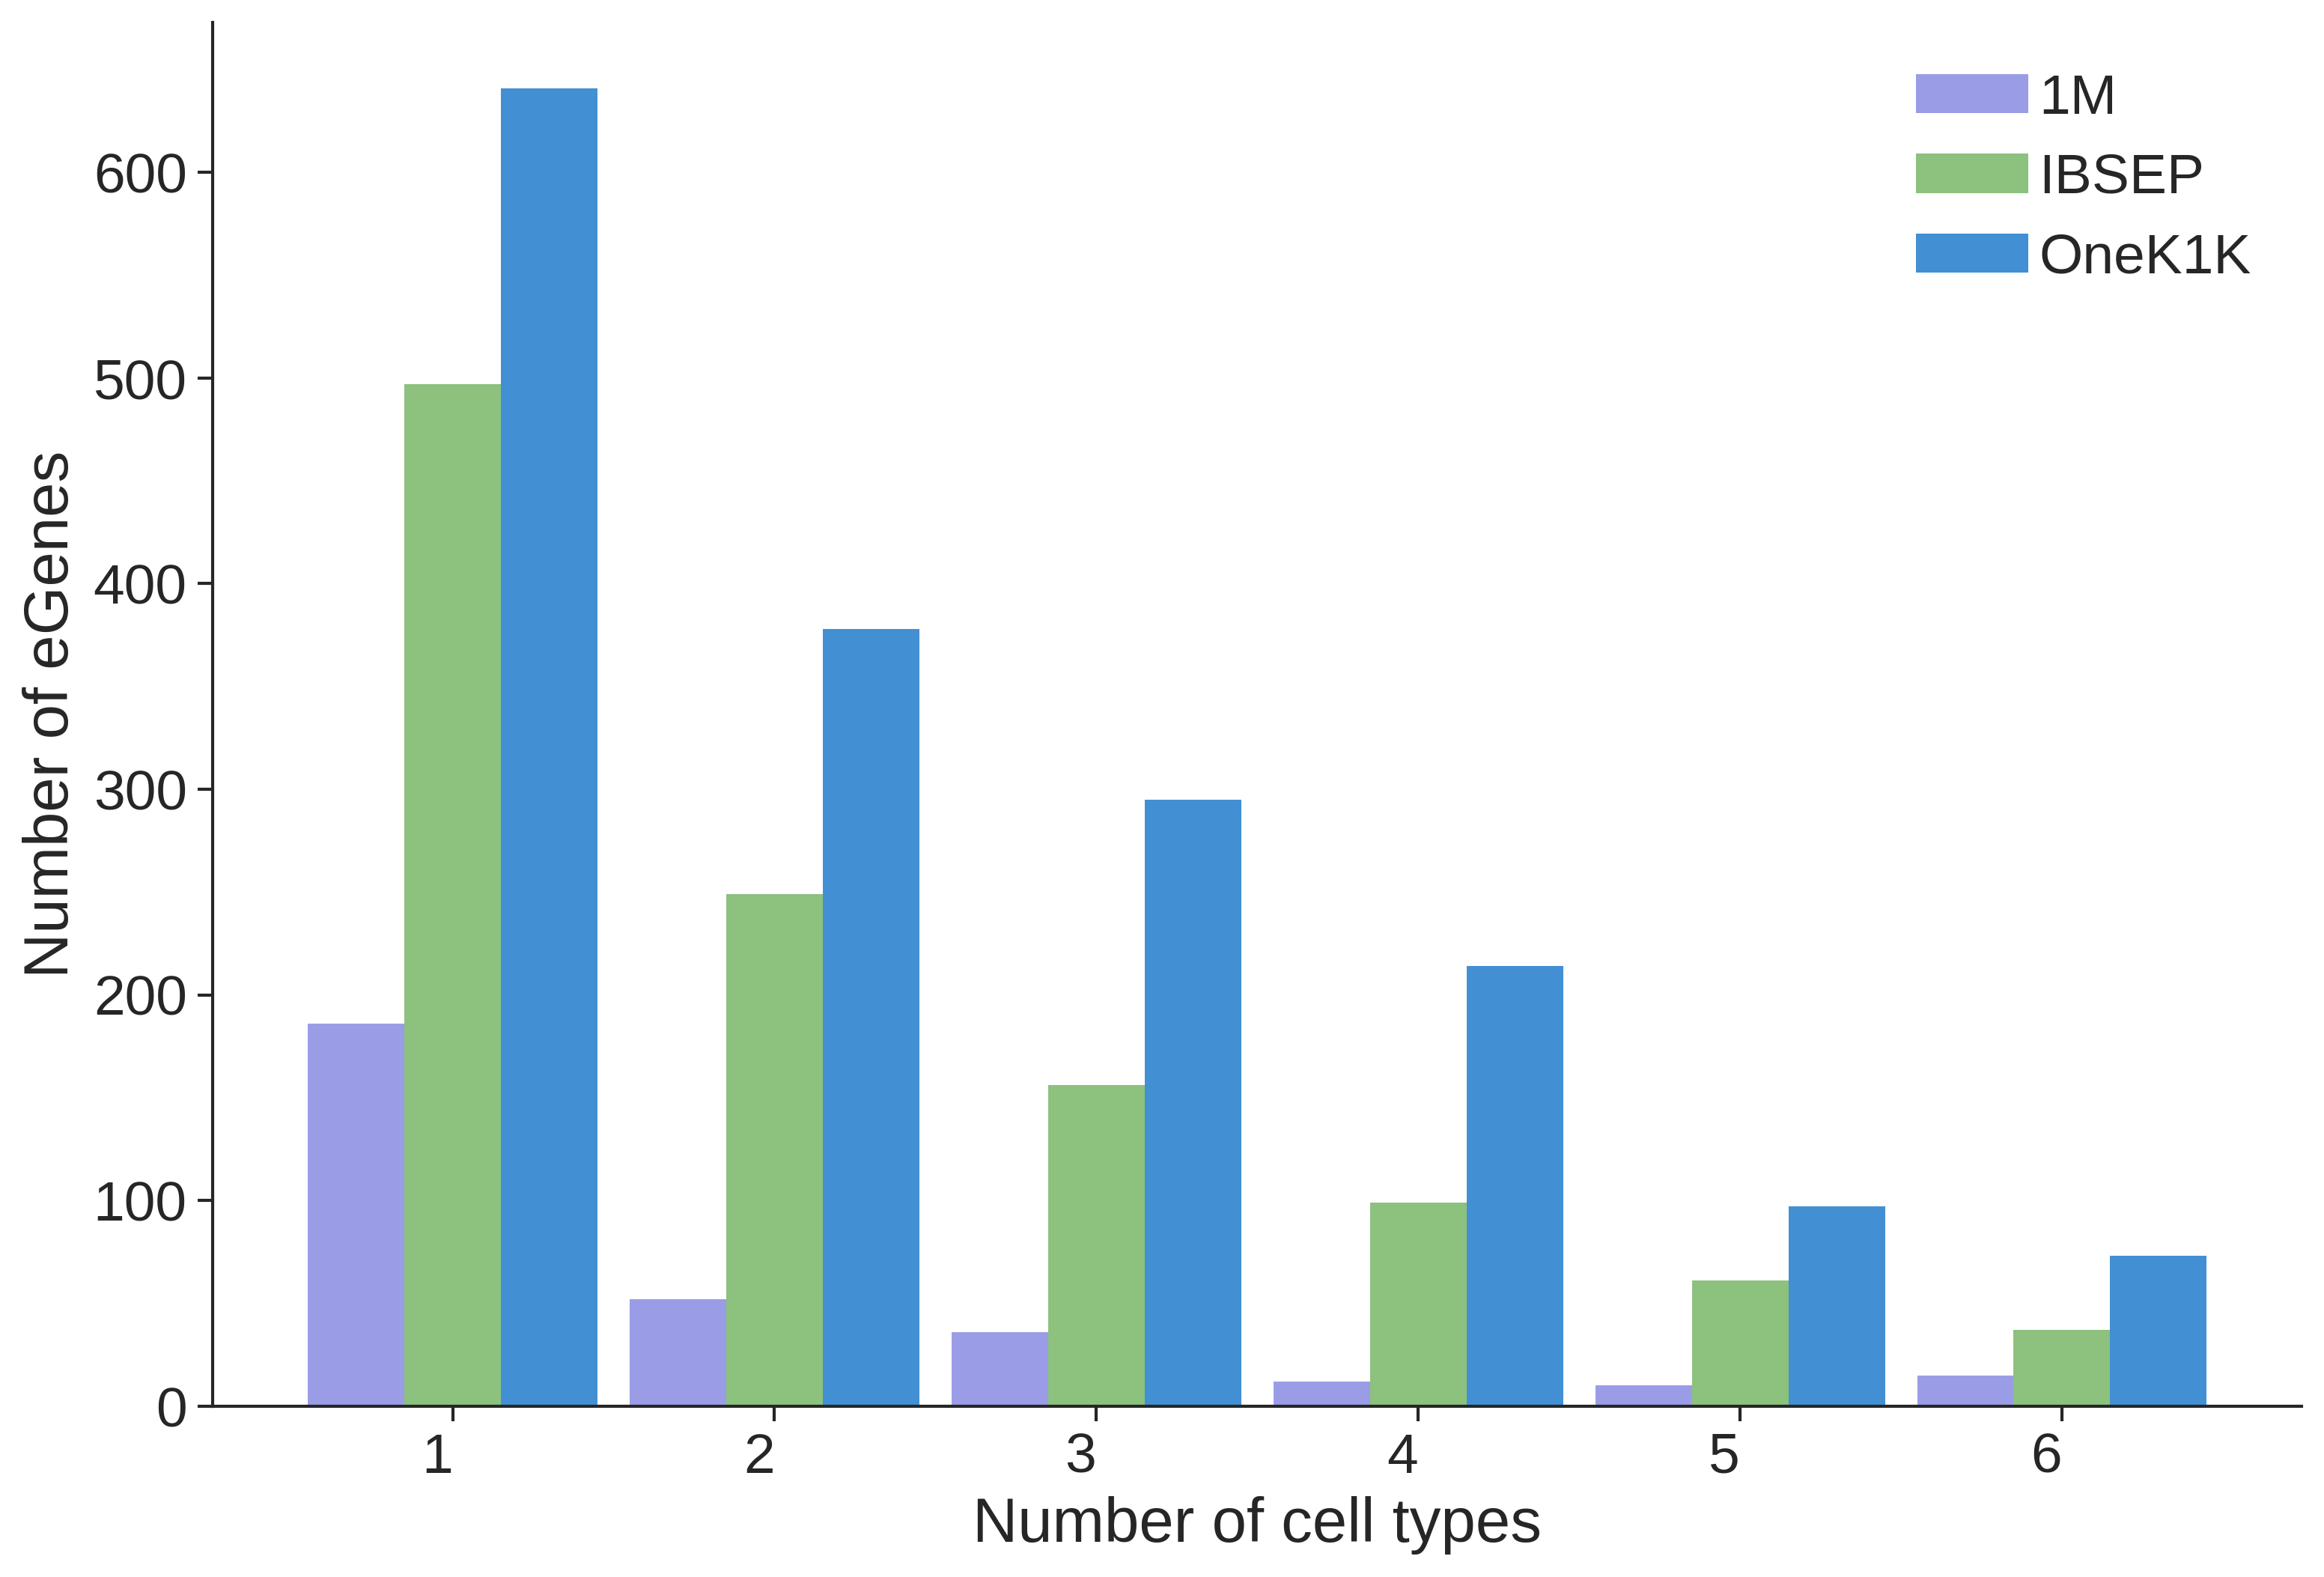

In [341]:
## bar plot: #egenes vs #cell types
style.use('seaborn-v0_8-white')
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(12, 8), dpi=300)
width = 0.3
a = 1
bar1 = ax.bar(np.arange(1,7)-width, egenes_vs_cts_df['1m'].values, width=width, color='#9A9DE6', alpha=a, label='1M')
bar2 = ax.bar(np.arange(1,7)-0*width, egenes_vs_cts_df['ibsep'].values, width=width, color='#8CC17E', alpha=a, label='IBSEP')
bar3 = ax.bar(np.arange(1,7)+width, egenes_vs_cts_df['onek1k'].values, width=width, color='#438FD4', alpha=a, label='OneK1K')

ax.legend(bbox_to_anchor=(1.0, 1.0),fontsize=18,handletextpad=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Number of cell types', fontsize=20)
ax.set_ylabel('Number of eGenes', fontsize=20)
# ax.set_yticks([300, 600, 900, 1200, 1500])
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels([1,2,3,4,5,6], rotation=0, ha='right')
ax.tick_params(axis='both', which='major', labelsize=18)
# plt.grid(None)
plt.show()

# Shared significance test

In [297]:
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_lowres_egenes_1e-5_hij0.0001.json', 'r') as f:
    genes_lowres = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_neutrophil_egenes_1e-5_hij0.0001.json', 'r') as f:
    neutro_genes_lowres = json.load(f)

In [294]:
num_genes = dict.fromkeys(sorted_cell_types)
for ct in sorted_cell_types:
    df = pd.read_csv(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/allChrMols_{ct}_blue_pval0.0001_tau1.0_truncorr.csv', sep='\t')
    tmp = df.GENEID.unique().tolist()
    num_genes[ct] = tmp
for k, v in num_genes.items():
    print(k, len(v))

B 5121
CD4T 5121
CD8T 5121
NK 5121
monocyte 5121
DC 5121
neutrophil 5121


In [299]:
## ibsep vs 1k1k
nums_dict = {'Cell_type': [], 'Total': [], 'Only_OneK1K': [], 'Shared': [], 'Only_IBSEP': []}
for ct in sorted_cell_names.keys():
    nums_dict['Cell_type'].append(ct)
    nums_dict['Total'].append(len(num_genes[ct]))
    if ct != 'neutrophil':
        nums_dict['Only_OneK1K'].append(len(np.setdiff1d(genes_lowres[ct]['OneK1K'], genes_lowres[ct]['1M-Blood-IBSEP'])))
        nums_dict['Shared'].append(len(np.intersect1d(genes_lowres[ct]['OneK1K'], genes_lowres[ct]['1M-Blood-IBSEP'])))
        nums_dict['Only_IBSEP'].append(len(np.setdiff1d(genes_lowres[ct]['1M-Blood-IBSEP'], genes_lowres[ct]['OneK1K'])))
    else:
        nums_dict['Only_OneK1K'].append(len(np.setdiff1d(neutro_genes_lowres['BLUEPRINT'], neutro_genes_lowres['IBSEP'])))
        nums_dict['Shared'].append(len(np.intersect1d(neutro_genes_lowres['BLUEPRINT'], neutro_genes_lowres['IBSEP'])))
        nums_dict['Only_IBSEP'].append(len(np.setdiff1d(neutro_genes_lowres['IBSEP'], neutro_genes_lowres['BLUEPRINT'])))
        
## gtex vs 1k1k
nums_dict2 = {'Cell_type': [], 'Total': [], 'Only_OneK1K': [], 'Shared': [], 'Only_GTEx': []}
for ct in sorted_cell_names.keys():
    nums_dict2['Cell_type'].append(ct)
    nums_dict2['Total'].append(len(num_genes[ct]))
    if ct != 'neutrophil':
        nums_dict2['Only_OneK1K'].append(len(np.setdiff1d(genes_lowres[ct]['OneK1K'], genes_lowres[ct]['GTEx'])))
        nums_dict2['Shared'].append(len(np.intersect1d(genes_lowres[ct]['OneK1K'], genes_lowres[ct]['GTEx'])))
        nums_dict2['Only_GTEx'].append(len(np.setdiff1d(genes_lowres[ct]['GTEx'], genes_lowres[ct]['OneK1K'])))
    else:
        nums_dict2['Only_OneK1K'].append(len(np.setdiff1d(neutro_genes_lowres['BLUEPRINT'], neutro_genes_lowres['GTEx'])))
        nums_dict2['Shared'].append(len(np.intersect1d(neutro_genes_lowres['BLUEPRINT'], neutro_genes_lowres['GTEx'])))
        nums_dict2['Only_GTEx'].append(len(np.setdiff1d(neutro_genes_lowres['GTEx'], neutro_genes_lowres['BLUEPRINT'])))

## sc vs 1k1k
nums_dict3 = {'Cell_type': [], 'Total': [], 'Only_OneK1K': [], 'Shared': [], 'Only_1M': []}
for ct in sorted_cell_names.keys():
    nums_dict3['Cell_type'].append(ct)
    nums_dict3['Total'].append(len(num_genes[ct]))
    if ct != 'neutrophil':
        nums_dict3['Only_OneK1K'].append(len(np.setdiff1d(genes_lowres[ct]['OneK1K'], genes_lowres[ct]['1M-Blood'])))
        nums_dict3['Shared'].append(len(np.intersect1d(genes_lowres[ct]['OneK1K'], genes_lowres[ct]['1M-Blood'])))
        nums_dict3['Only_1M'].append(len(np.setdiff1d(genes_lowres[ct]['1M-Blood'], genes_lowres[ct]['OneK1K'])))
    else:
        nums_dict3['Only_OneK1K'].append(len(np.setdiff1d(neutro_genes_lowres['BLUEPRINT'], neutro_genes_lowres['Neutro2015'])))
        nums_dict3['Shared'].append(len(np.intersect1d(neutro_genes_lowres['BLUEPRINT'], neutro_genes_lowres['Neutro2015'])))
        nums_dict3['Only_1M'].append(len(np.setdiff1d(neutro_genes_lowres['Neutro2015'], neutro_genes_lowres['BLUEPRINT'])))

In [300]:
nums_df = pd.DataFrame(nums_dict)
nums_df2 = pd.DataFrame(nums_dict2)
nums_df3 = pd.DataFrame(nums_dict3)
nums_df

,Cell_type,Total,Only_OneK1K,Shared,Only_IBSEP
0,B,5121,428,81,85
1,CD4T,5121,978,318,120
2,CD8T,5121,754,251,158
3,NK,5121,563,254,276
4,monocyte,5121,141,164,479
5,DC,5121,65,64,136
6,neutrophil,5121,429,1217,733


In [301]:
nums_df2

,Cell_type,Total,Only_OneK1K,Shared,Only_GTEx
0,B,5121,132,377,1937
1,CD4T,5121,388,908,1406
2,CD8T,5121,267,738,1576
3,NK,5121,205,612,1702
4,monocyte,5121,42,263,2051
5,DC,5121,19,110,2204
6,neutrophil,5121,386,1260,856


In [302]:
nums_df3

,Cell_type,Total,Only_OneK1K,Shared,Only_1M
0,B,5121,485,24,1
1,CD4T,5121,1140,156,8
2,CD8T,5121,908,97,9
3,NK,5121,732,85,14
4,monocyte,5121,206,99,37
5,DC,5121,90,39,17
6,neutrophil,5121,1278,368,58


In [305]:
## ibsep shared prop
p_shared_by_cell = dict.fromkeys(nums_df.Cell_type.values)
for k in p_shared_by_cell.keys():
    p_shared_by_cell[k] = nums_df.loc[nums_df.Cell_type==k].Shared.values[0] / (nums_df.loc[nums_df.Cell_type==k].Shared.values[0] + nums_df.loc[nums_df.Cell_type==k].Only_IBSEP.values[0])

## gtex shared prop
p_shared_by_cell2 = dict.fromkeys(nums_df2.Cell_type.values)
for k in p_shared_by_cell.keys():
    p_shared_by_cell2[k] = nums_df2.loc[nums_df2.Cell_type==k].Shared.values[0] / (nums_df2.loc[nums_df2.Cell_type==k].Shared.values[0] + nums_df2.loc[nums_df2.Cell_type==k].Only_GTEx.values[0])

## sc shared prop
p_shared_by_cell3 = dict.fromkeys(nums_df3.Cell_type.values)
for k in p_shared_by_cell.keys():
    p_shared_by_cell3[k] = nums_df3.loc[nums_df3.Cell_type==k].Shared.values[0] / (nums_df3.loc[nums_df3.Cell_type==k].Shared.values[0] + nums_df3.loc[nums_df3.Cell_type==k].Only_1M.values[0])

print(p_shared_by_cell, '\n')
print(p_shared_by_cell2 , '\n')
print(p_shared_by_cell3)

{'B': 0.4879518072289157, 'CD4T': 0.726027397260274, 'CD8T': 0.6136919315403423, 'NK': 0.47924528301886793, 'monocyte': 0.25505443234836706, 'DC': 0.32, 'neutrophil': 0.6241025641025642} 

{'B': 0.16292134831460675, 'CD4T': 0.3923941227312014, 'CD8T': 0.31892826274848746, 'NK': 0.2644770959377701, 'monocyte': 0.11365600691443388, 'DC': 0.04753673292999136, 'neutrophil': 0.5954631379962193} 

{'B': 0.96, 'CD4T': 0.9512195121951219, 'CD8T': 0.9150943396226415, 'NK': 0.8585858585858586, 'monocyte': 0.7279411764705882, 'DC': 0.6964285714285714, 'neutrophil': 0.863849765258216}


B: 0.099 | 0.163 | 0.488
CD4T: 0.253 | 0.392 | 0.726
CD8T: 0.196 | 0.319 | 0.614
NK: 0.160 | 0.264 | 0.479
monocyte: 0.060 | 0.114 | 0.255
DC: 0.025 | 0.048 | 0.320
neutrophil: 0.321 | 0.595 | 0.624


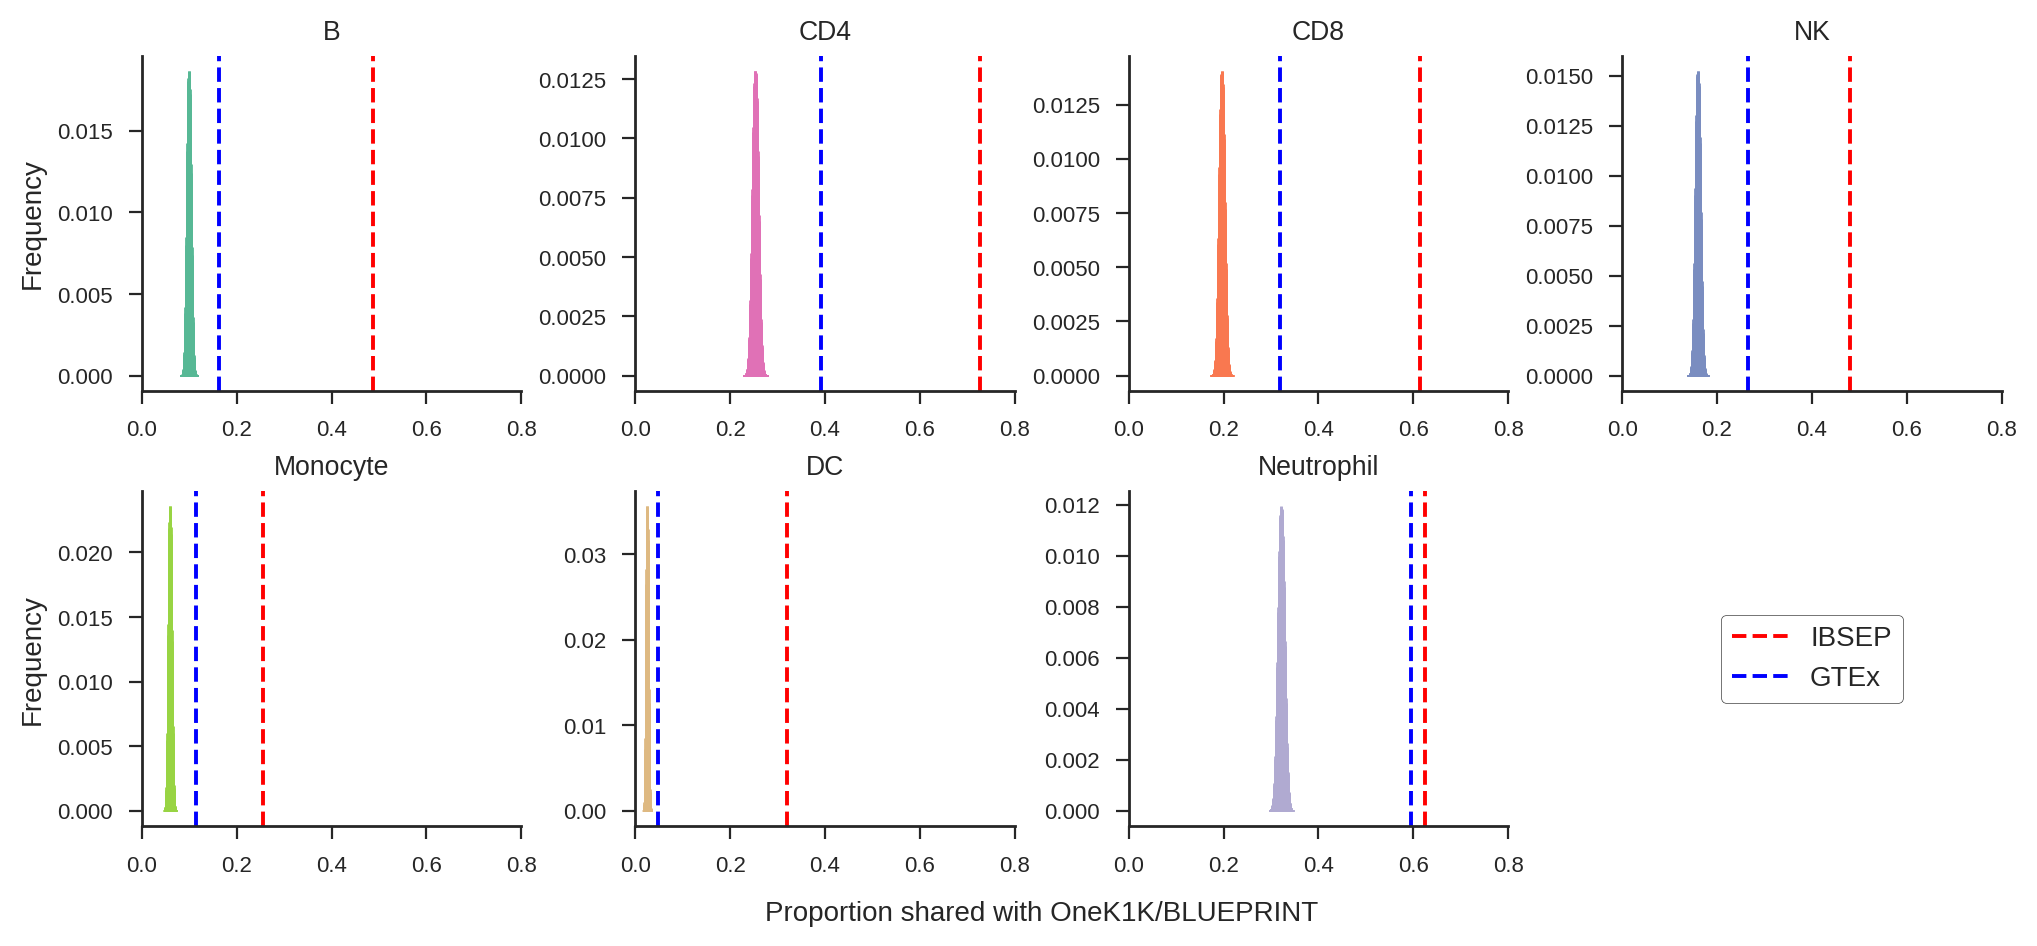

In [801]:
## 2*4
colors = ['#57B895', '#E071B6', '#F97850', '#7A8DC0', '#98D443', '#DEB982', '#B0AAD1']
sns.set_context('paper',font_scale=1.25)
plt.style.use('seaborn-v0_8-paper')
fig, ax = plt.subplots(2,4, figsize=(12,5), dpi=200)

n = 0
for i in range(2):
    for j in range(4):
        if i == 1 and j == 3:
            ax[i,j].axis('off')
            ax[i,j].legend(handles=[l1, l2], loc='center', fontsize=10, frameon=True, fancybox=True, edgecolor='black')
        else:
            ct = list(sorted_cell_names.keys())[n]
            N = nums_df.loc[nums_df.Cell_type==ct, 'Total'].values[0]
            x = np.arange(0, N+1)
            p = (nums_df.loc[nums_df.Cell_type==ct, 'Only_OneK1K'].values[0] + nums_df.loc[nums_df.Cell_type==ct, 'Shared'].values[0]) / N
            print(f'{ct}: {p:.3f} | {p_shared_by_cell2[ct]:.3f} | {p_shared_by_cell[ct]:.3f}')
            y = ss.binom.pmf(x, N, p)
            ax[i,j].vlines(x/N, 0, y, colors=colors[n], linestyles='-', lw=1)
            l1 = ax[i,j].axvline(x=p_shared_by_cell[ct], linestyle='--', color='red', label='IBSEP')
            l2 = ax[i,j].axvline(x=p_shared_by_cell2[ct], linestyle='--', color='blue', label='GTEx')
            ax[i,j].set_xlim([0, 0.8])
            ax[i,j].set_title(sorted_cell_names[ct])
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].spines['right'].set_visible(False)
            n += 1
            ax[i,j].tick_params(axis='both', which='major', labelsize=8)
            if j == 0:
                ax[i,j].set_ylabel('Frequency', fontsize=10)
            # if i == 3 and j == 0:
fig.supxlabel('Proportion shared with OneK1K/BLUEPRINT', fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)
plt.show()

# Metrics (validataion as GT)

In [342]:
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_lowres_egenes_1e-5_hij0.0001.json', 'r') as f:
    genes_by_cell_data = json.load(f)
with open(f'/data2/xiaojiashun/eQTL/data/blood_data/1M_neutro2015/merged_sumstats/omega_shrink_0.9_max_hsq_0.8/randMols_neutrophil_egenes_1e-5_hij0.0001.json', 'r') as f:
    neutro_genes_data = json.load(f)

In [343]:
metrics = {'SC': {'precision': dict.fromkeys(sorted_cell_types),
                  'recall': dict.fromkeys(sorted_cell_types),
                  'f1': dict.fromkeys(sorted_cell_types)}, 
           'IBSEP': {'precision': dict.fromkeys(sorted_cell_types),
                     'recall': dict.fromkeys(sorted_cell_types),
                     'f1': dict.fromkeys(sorted_cell_types)},
           'GTEx': {'precision': dict.fromkeys(sorted_cell_types),
                    'recall': dict.fromkeys(sorted_cell_types),
                    'f1': dict.fromkeys(sorted_cell_types)}}
def get_metrics(truth, pred):
    tp = len(np.intersect1d(pred, truth))
    p = len(truth)
    pp = len(pred)
    precision = tp / pp
    recall = tp / p
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1
    
for ct in sorted_cell_types:
    if ct != 'neutrophil':
        # sc
        precision, recall, f1 = get_metrics(genes_by_cell_data[ct]['OneK1K'], genes_by_cell_data[ct]['1M-Blood'])
        metrics['SC']['precision'][ct] = precision
        metrics['SC']['recall'][ct] = recall
        metrics['SC']['f1'][ct] = f1
        # ibsep
        precision, recall, f1 = get_metrics(genes_by_cell_data[ct]['OneK1K'], genes_by_cell_data[ct]['1M-Blood-IBSEP'])
        metrics['IBSEP']['precision'][ct] = precision
        metrics['IBSEP']['recall'][ct] = recall
        metrics['IBSEP']['f1'][ct] = f1
        # gtex
        precision, recall, f1 = get_metrics(genes_by_cell_data[ct]['OneK1K'], genes_by_cell_data[ct]['GTEx'])
        metrics['GTEx']['precision'][ct] = precision
        metrics['GTEx']['recall'][ct] = recall
        metrics['GTEx']['f1'][ct] = f1
    else:
        # sc
        precision, recall, f1 = get_metrics(neutro_genes_data['BLUEPRINT'], neutro_genes_data['Neutro2015'])
        metrics['SC']['precision'][ct] = precision
        metrics['SC']['recall'][ct] = recall
        metrics['SC']['f1'][ct] = f1
        # ibsep
        precision, recall, f1 = get_metrics(neutro_genes_data['BLUEPRINT'], neutro_genes_data['IBSEP'])
        metrics['IBSEP']['precision'][ct] = precision
        metrics['IBSEP']['recall'][ct] = recall
        metrics['IBSEP']['f1'][ct] = f1
        # gtex
        precision, recall, f1 = get_metrics(neutro_genes_data['BLUEPRINT'], neutro_genes_data['GTEx'])
        metrics['GTEx']['precision'][ct] = precision
        metrics['GTEx']['recall'][ct] = recall
        metrics['GTEx']['f1'][ct] = f1

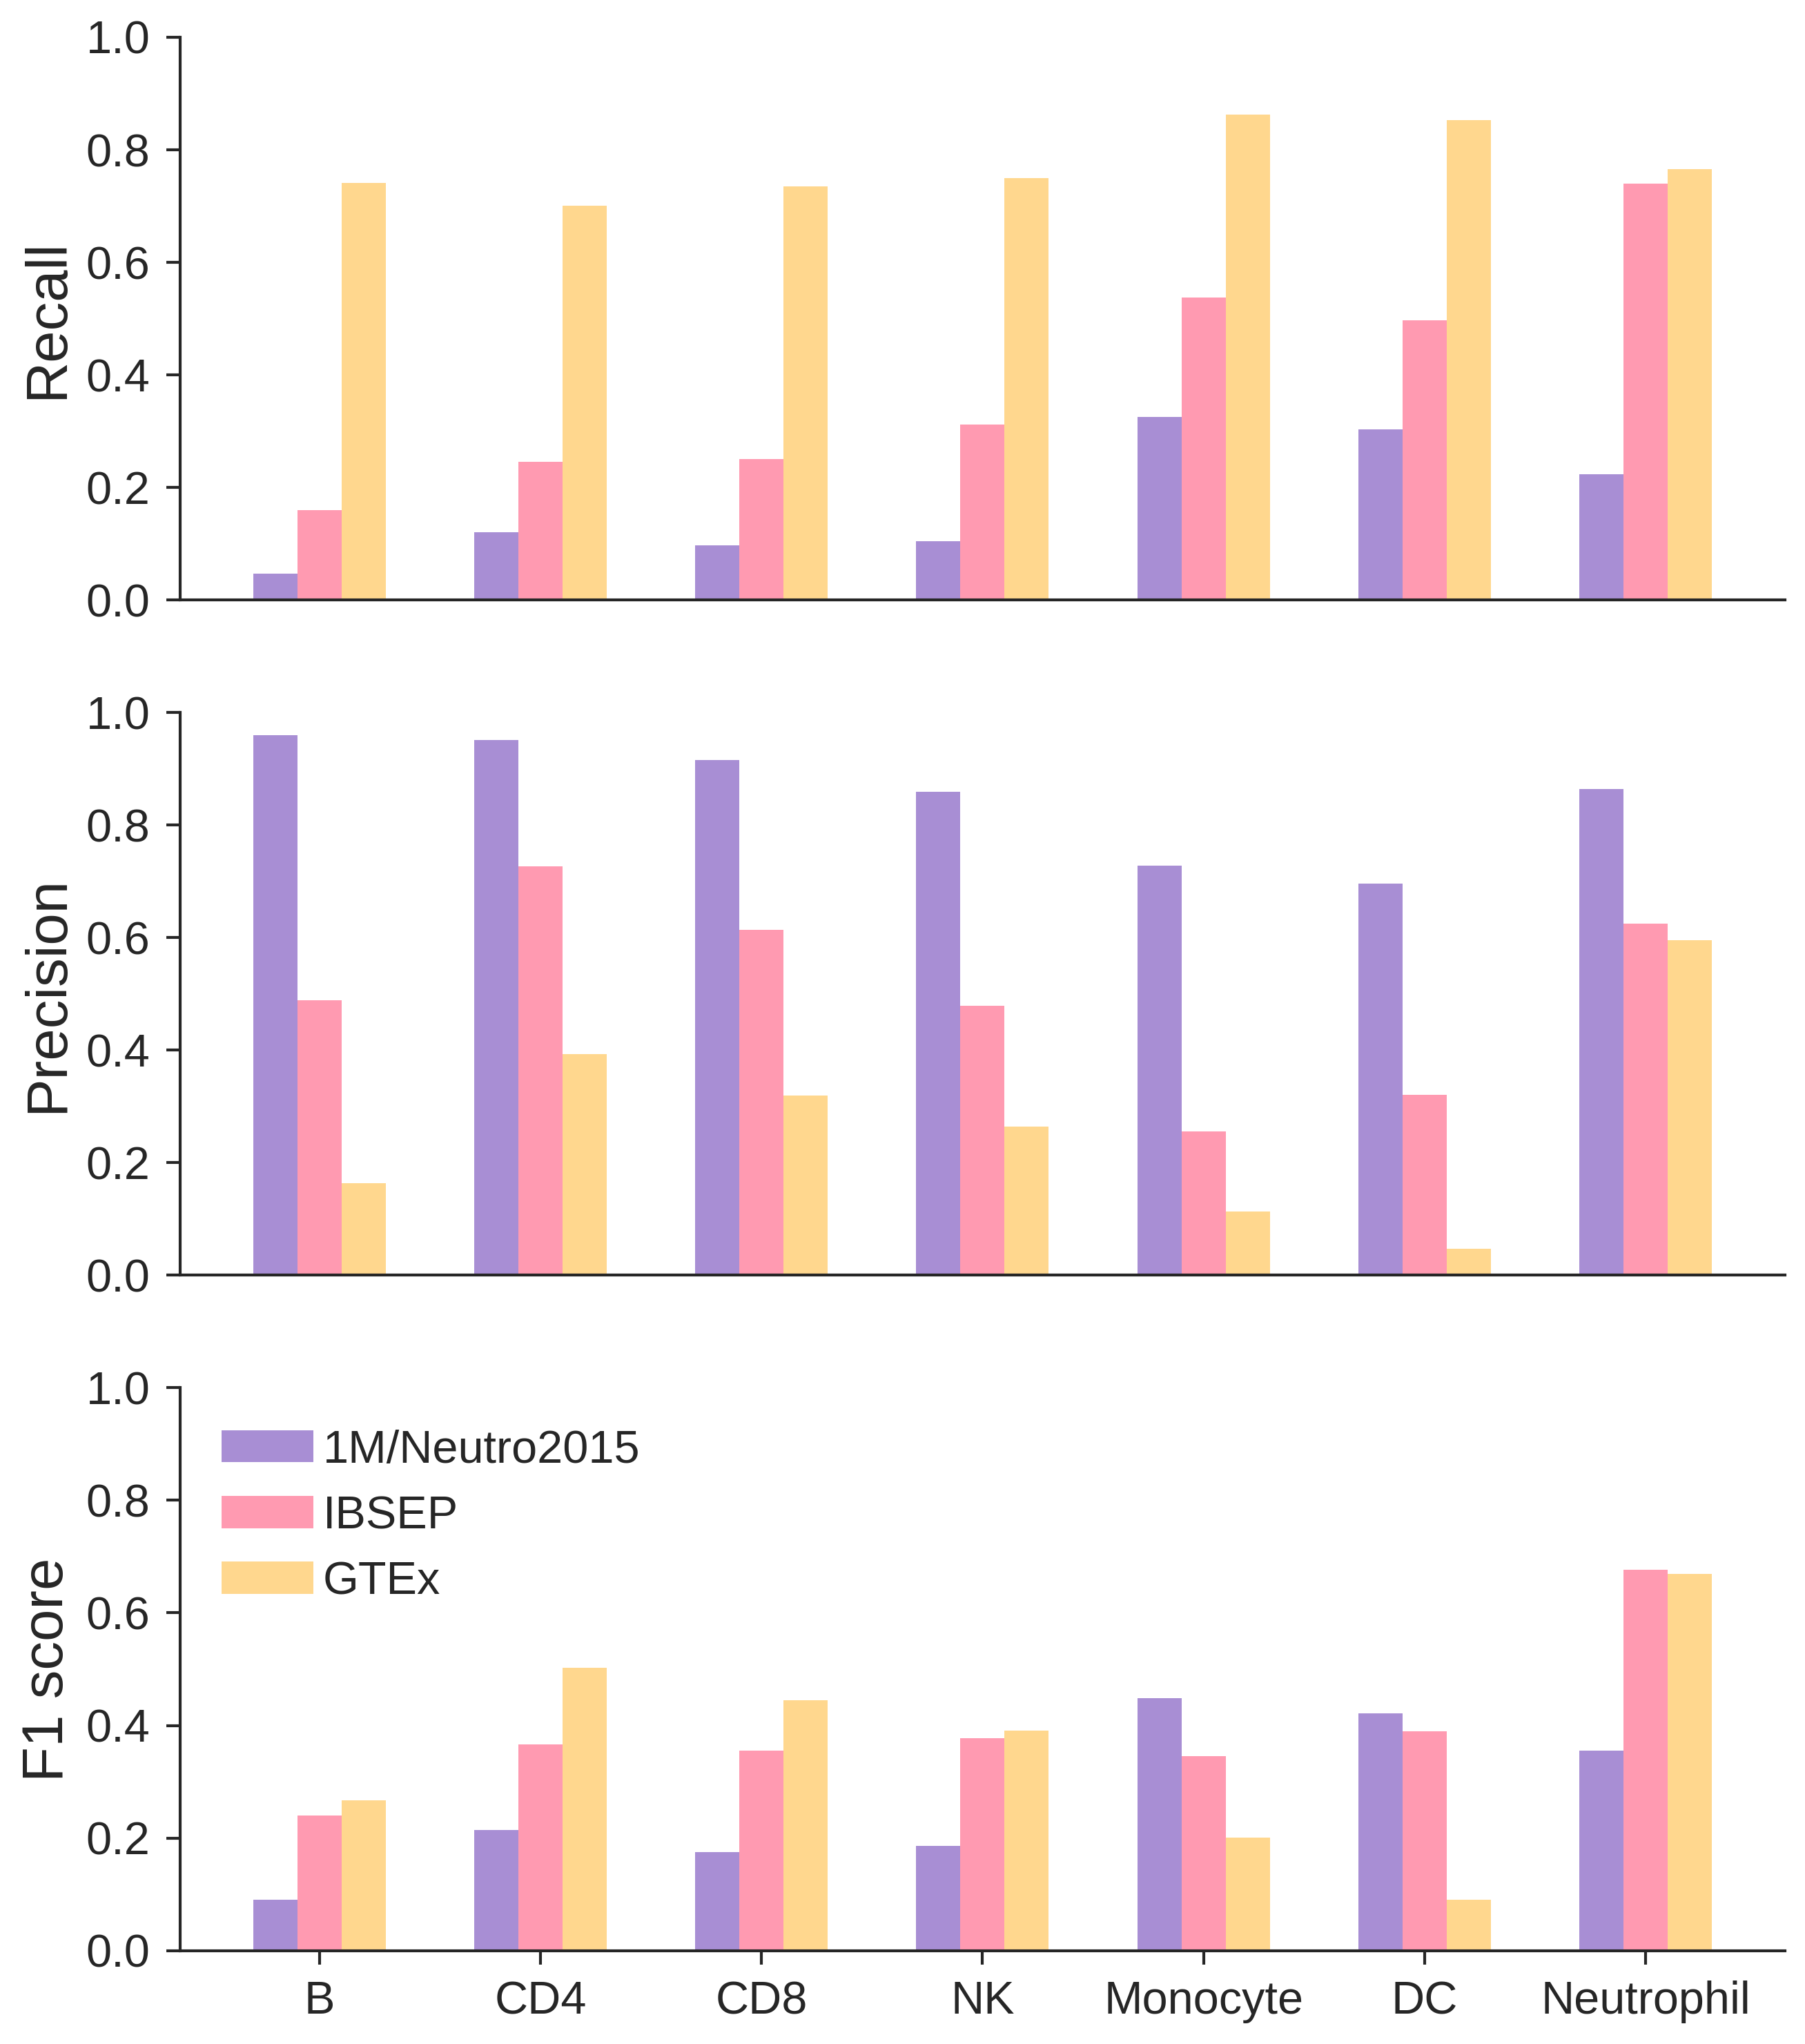

In [710]:
## barplot
style.use('seaborn-v0_8-paper')
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(3, 1,figsize=(10, 12), dpi=300)
width = 0.2
alpha = 0.7
# recall
bar1 = ax[0].bar(np.arange(1,8)-width, metrics['SC']['recall'].values(), width=width, color='#845EC2', alpha=alpha, label='1M/Neutro2015')
bar2 = ax[0].bar(np.arange(1,8)-0*width, metrics['IBSEP']['recall'].values(), width=width, color='#FF6F91', alpha=alpha, label='IBSEP')
bar3 = ax[0].bar(np.arange(1,8)+width, metrics['GTEx']['recall'].values(), width=width, color='#FFC75F', alpha=alpha, label='GTEx')
# precision
bar1 = ax[1].bar(np.arange(1,8)-width, metrics['SC']['precision'].values(), width=width, color='#845EC2', alpha=alpha, label='1M/Neutro2015')
bar2 = ax[1].bar(np.arange(1,8)-0*width, metrics['IBSEP']['precision'].values(), width=width, color='#FF6F91', alpha=alpha, label='IBSEP')
bar3 = ax[1].bar(np.arange(1,8)+width, metrics['GTEx']['precision'].values(), width=width, color='#FFC75F', alpha=alpha, label='GTEx')
# f1
bar1 = ax[2].bar(np.arange(1,8)-width, metrics['SC']['f1'].values(), width=width, color='#845EC2', alpha=alpha, label='1M/Neutro2015')
bar2 = ax[2].bar(np.arange(1,8)-0*width, metrics['IBSEP']['f1'].values(), width=width, color='#FF6F91', alpha=alpha, label='IBSEP')
bar3 = ax[2].bar(np.arange(1,8)+width, metrics['GTEx']['f1'].values(), width=width, color='#FFC75F', alpha=alpha, label='GTEx')

ax[2].legend(loc='upper left',fontsize=16,handletextpad=0.2)
for i in range(3):
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_ylim([0, 1])
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_ylabel(f'Recall', fontsize=20) 
ax[1].set_ylabel(f'Precision', fontsize=20)
ax[2].set_ylabel(f'F1 score', fontsize=20)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([1,2,3,4,5,6,7])
ax[2].set_xticklabels(sorted_cell_names.values(), rotation=0, ha='center')

plt.show()

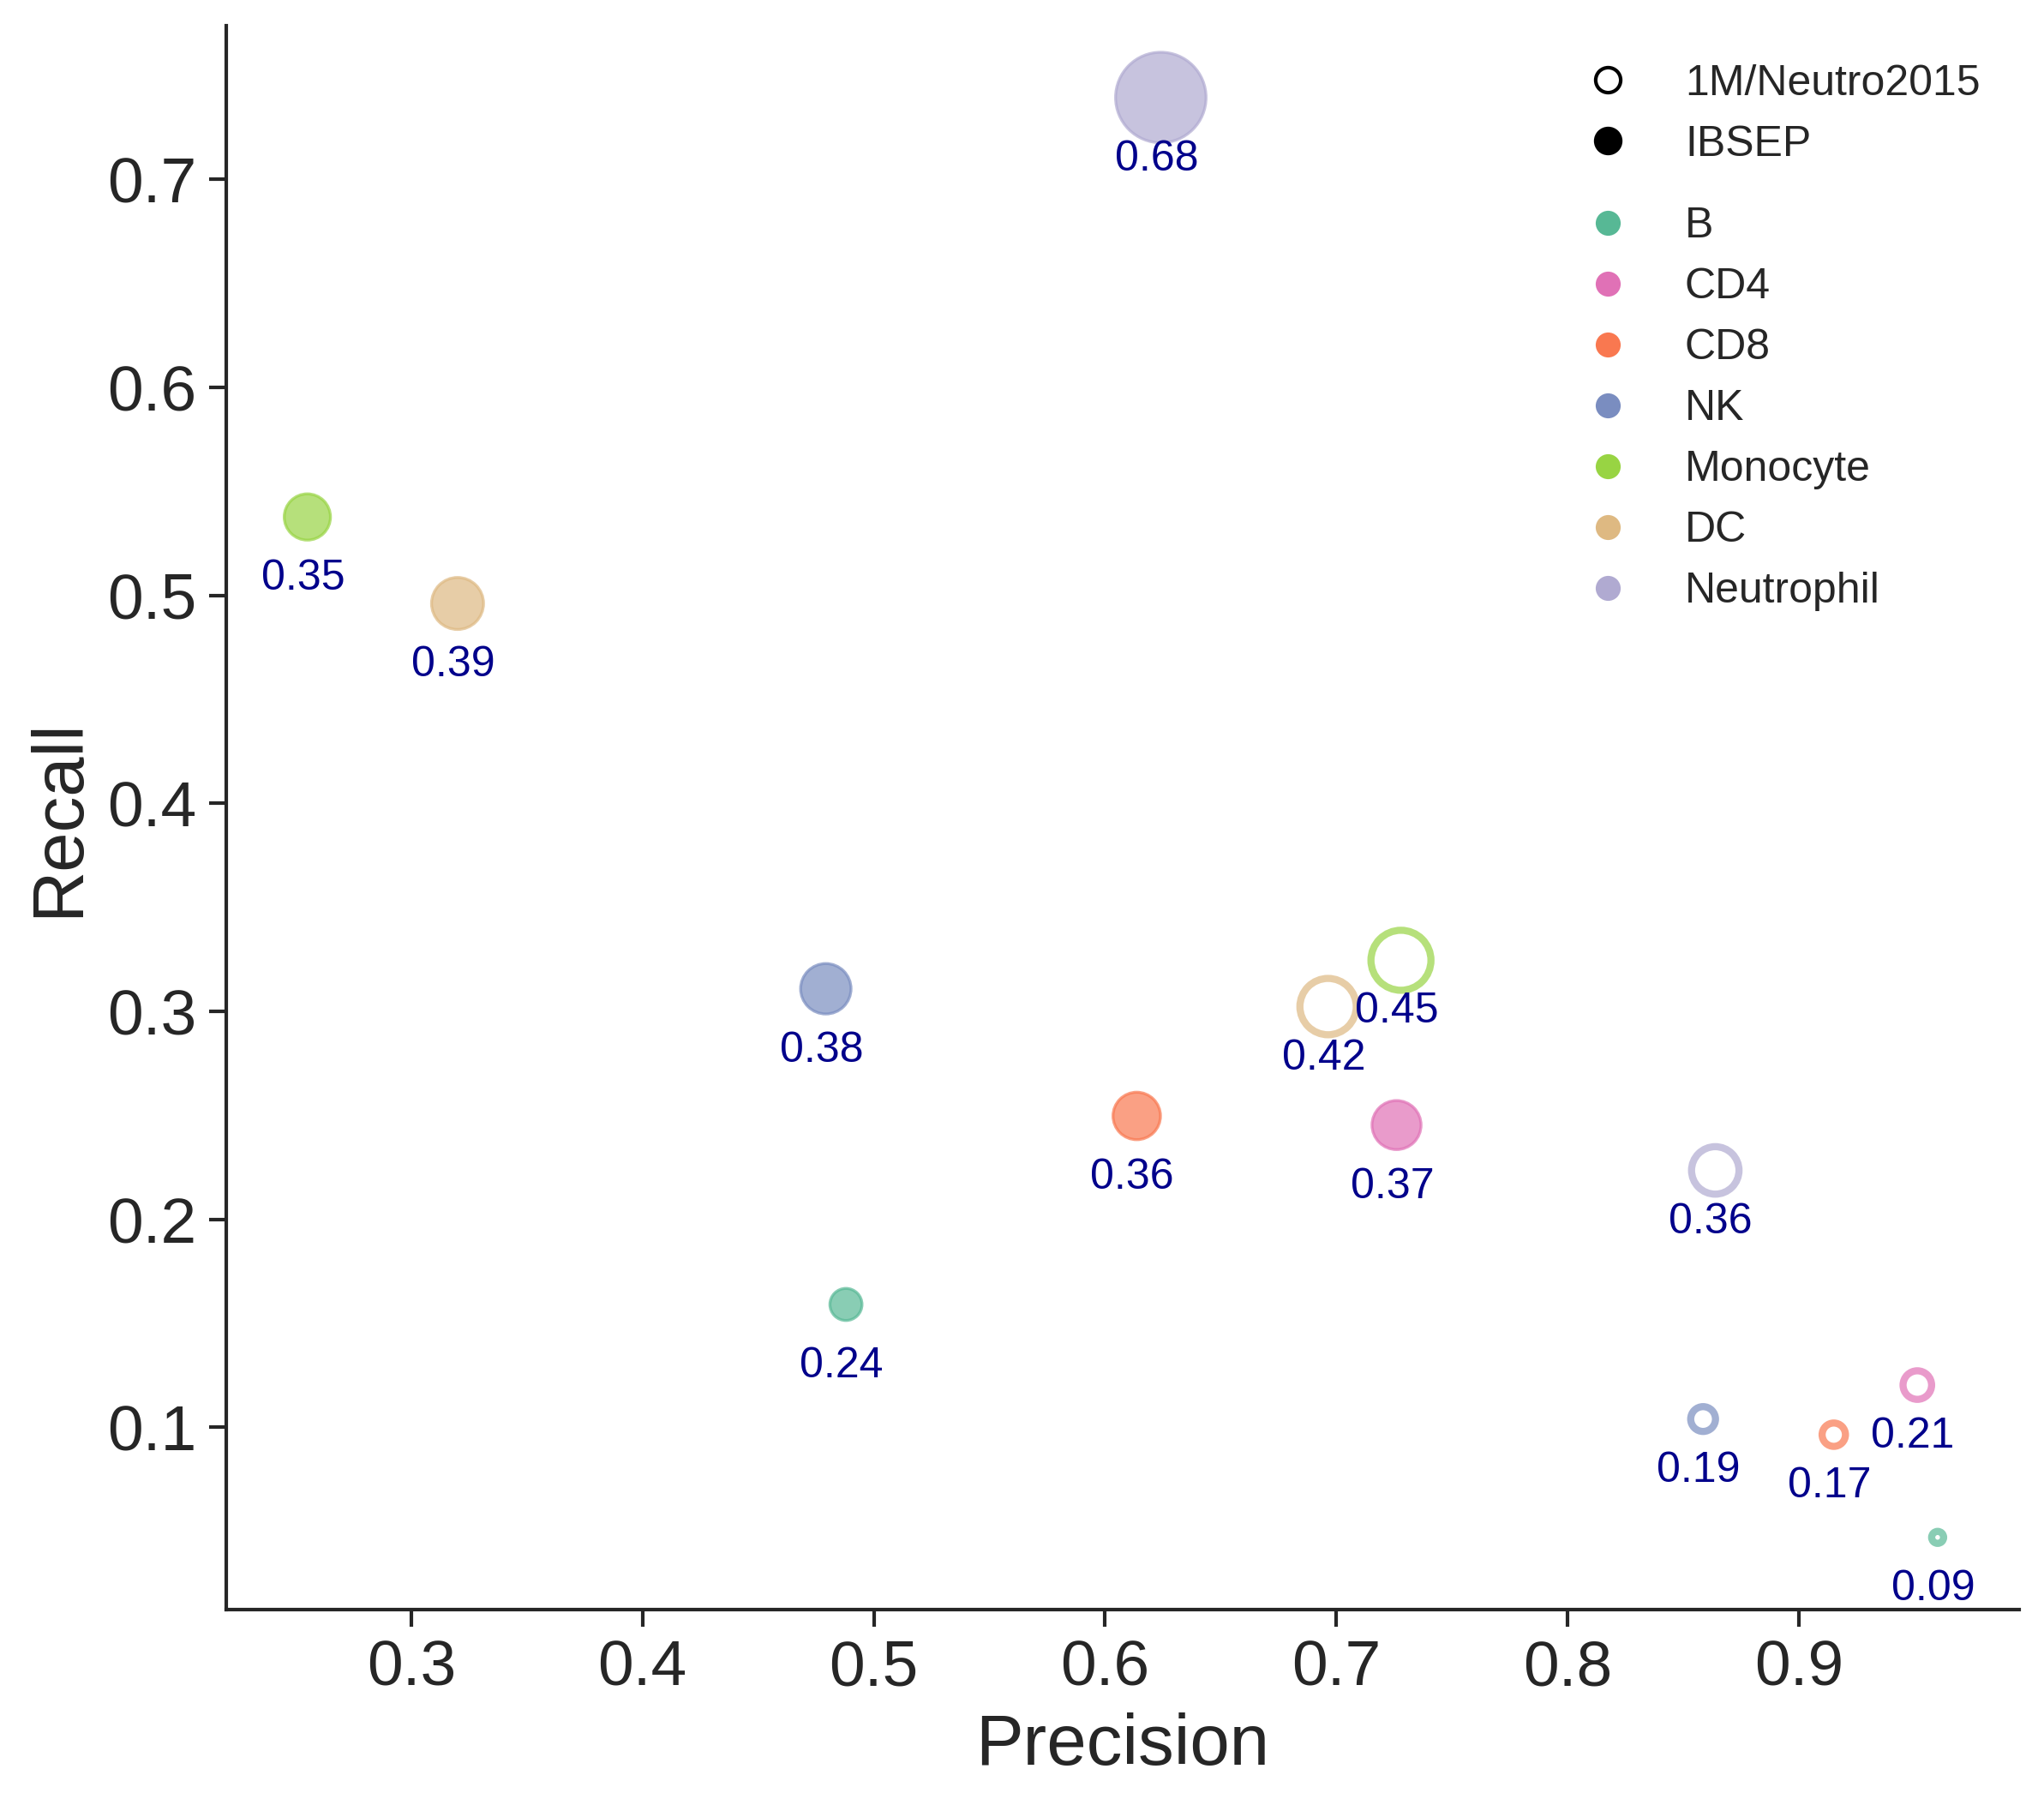

In [484]:
## scatter
style.use('seaborn-v0_8-white')
sns.set_context('paper',font_scale=1)
fig, ax = plt.subplots(1, 1,figsize=(9, 8), dpi=300)
width = 0.2
alpha = 0.7
scale = 1400
marker = 'o'
fs = 12
x1 = np.array(list(metrics['SC']['precision'].values()))
y1 = np.array(list(metrics['SC']['recall'].values()))
z1 = np.array(list(metrics['SC']['f1'].values()))
x2 = np.array(list(metrics['IBSEP']['precision'].values()))
y2 = np.array(list(metrics['IBSEP']['recall'].values()))
z2 = np.array(list(metrics['IBSEP']['f1'].values()))

ax.scatter(x1, y1, linewidth=2, s=z1**2*scale, marker=marker, c='none', edgecolor=colors, alpha=alpha)
ax.scatter(x2, y2, s=z2**2*scale, marker=marker, c=colors, alpha=alpha)
for i, (x1_, y1_, z1_) in enumerate(zip(x1, y1, z1)):
    offx = 0.02
    offy = 0.03
    texts.append(ax.text(x=x1_-offx, y=y1_-offy, s=round(z1_,2), fontsize=fs, color='darkblue'))
for i, (x2_, y2_, z2_) in enumerate(zip(x2, y2, z2)):
    offx = 0.02
    offy = 0.035
    texts.append(ax.text(x=x2_-offx, y=y2_-offy, s=round(z2_,2), fontsize=fs, color='darkblue'))
ax.set_zorder(1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
legend1_patches, legend2_patches = [], []
for i, ct in enumerate(sorted_cell_names):
    legend1_patches.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=8, label=sorted_cell_names[ct], alpha=1))
legend2_patches = [Line2D([0], [0], marker='o', color='w', markeredgecolor='k', markerfacecolor='w', markersize=7, label='1M/Neutro2015', alpha=1),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor='k', markerfacecolor='k', markersize=7, label='IBSEP', alpha=1)]
legend1 = ax.legend(handles=legend1_patches, bbox_to_anchor=[0.944,0.91], fontsize=fs)
legend2 = ax.legend(handles=legend2_patches, bbox_to_anchor=[1,1], fontsize=fs)
ax.add_artist(legend1)
# ax.add_artist(legend2)

ax.set_xlabel(f'Precision', fontsize=20)
ax.set_ylabel(f'Recall', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.show()